# Lesson 2 : LangGraph Components

In [ ]:
# !brew install graphviz
# export C_INCLUDE_PATH=$(brew --prefix graphviz)/include
# export LIBRARY_PATH=$(brew --prefix graphviz)/lib
# pip install pygraphviz

# get free Tavily key at https://app.tavily.com/sign-in and put in .env

In [2]:
from dotenv import load_dotenv
_ = load_dotenv()

In [3]:
import os
import shutil
import glob
from datetime import datetime, timedelta
import time
from typing import TypedDict, Annotated
import operator
import re
from IPython.display import Image, display, HTML, Markdown

import pandas as pd

import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse

import sec_parser as sp
from sec_downloader import Downloader

# for Mac desktop automation
import pyautogui
import AppKit
from AppKit import NSApplication, NSApp, NSWorkspace

import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
# use firefox because it updates less often, can disable updates
# recommend importing profile from Chrome for cookies, passwords
# looks less like a bot with more user cruft in the profile
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import openai
from openai import OpenAI
import tiktoken

import asyncio
import aiohttp

from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain.tools import BaseTool, StructuredTool, tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver
from langchain_core.pydantic_v1 import BaseModel, Field

import wikipedia

import openbb
from openbb import obb

from newsapi import NewsApiClient



In [4]:
MODEL='gpt-4o'

DOWNLOAD_DIR = 'download'
OUTPUT_Dir = 'output'
DEFAULT_DOWNLOAD_DIR='/Users/drucev/Downloads/'


# Basic LangChain prompt completion


In [5]:
model = ChatOpenAI(model=MODEL)

messages = [
    SystemMessage(content="Translate the following from English into French"),
    HumanMessage(content="Listen to me. You are beautiful. You are flawless and I love you."),
]

response = model.invoke(messages)

print(response.content)


Écoute-moi. Tu es belle. Tu es parfaite et je t'aime.


# With a prompt template


In [ ]:
system_template = "Translate the following into {language}:"
user_template = "Listen to me. You are {adjective1}. You are {adjective2} and I love you."

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

# stream tokens as they are generated
response = ""
for r in chain.stream({"language": "German", "adjective1": "tops", "adjective2": "amazing"}):
    print(r, end="")
    response += r

# response


# Using a graph and a tool

In [ ]:
mytool = TavilySearchResults(max_results=4) #increased number of results
print(type(mytool))
print(mytool.name)


In [ ]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [ ]:
memory = AsyncSqliteSaver.from_conn_string(":memory:")

class Agent:

    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Sending tool results back to the model!")
        return {'messages': results}


In [ ]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You can make multiple calls (either simultaneously or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model=MODEL)
lg_agent = Agent(model, [mytool], memory, system=prompt)


In [ ]:
Image(lg_agent.graph.get_graph().draw_png())


In [ ]:
messages = [HumanMessage(content="What is the current weather in Brooklyn and as of what time?")]
thread = {"configurable": {"thread_id": "1"}}
all_content=""
async for event in lg_agent.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":  # stream content
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="")
            all_content += content

display(Markdown("**Final result**"))

display(Markdown(all_content))


# Using 2 tools in parallel

In [ ]:
messages = [HumanMessage(content="What is the weather in San Francisco, Eureka, and Denver? and as of what time")]
thread = {"configurable": {"thread_id": "2"}}
all_content=""
async for event in lg_agent.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="")
            all_content += content

display(Markdown(all_content))


# 2 or more tools in sequence, where answer from 2nd depends on result from 1st

In [ ]:
query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
Who are the statewide elected officials of that state? Answer each question."
messages = [HumanMessage(content=query)]
thread = {"configurable": {"thread_id": "3"}}
all_content=""
async for event in lg_agent.graph.astream_events({"messages": messages}, thread, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="")
            all_content += content

display(Markdown(all_content))


# Summarize a Wikipedia page


In [6]:
def delete_files(download_dir):
    """
    Deletes non-hidden files in the specified directory.

    Args:
        download_dir (str): The path to the directory containing the files.

    Raises:
        OSError: If there is an error while deleting a file.

    Note:
        This function does not delete subdirectories. If you want to remove subdirectories as well, use os.rmdir().

    Example:
        >>> delete_files('/path/to/directory')
    """

    # Iterate over all files in the directory
    for filename in os.listdir(download_dir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(download_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

delete_files(DOWNLOAD_DIR)


In [7]:
# get a list of wikipedia suggestions for a query using the wikipedia module

symbol = 'LLY'
company = 'Eli Lilly'

def fn_get_wikipedia_suggestions(symbol, company):
    """search for possible Wikipedia pages for a ticker symbol"""
    query_str = f'{company} ({symbol})'
    search_results = wikipedia.search(query_str)
    return search_results

search_results = fn_get_wikipedia_suggestions(symbol, company)
search_results


['Eli Lilly and Company',
 'Eli Lilly',
 'LLY',
 'Ruth Lilly',
 'Josiah K. Lilly Jr.',
 'Abelardo Aguilar',
 'Retatrutide',
 'Eli (name)',
 'Sidney Taurel',
 'Russell 1000 Index']

In [8]:
# use LLM to pick the best page for symbol and company from search_results

# a Pydantic class to get a structured object back from an LLM query

class Wiki_title(BaseModel):
    title: str = Field(description="The title of the main Wikipedia page for a company")


def fn_pick_wiki_page(model, symbol, company, search_results):
    """Given a company, ticker, and a list of wikipedia pages search_results, return the most likely wikipedia page matching the given company and symbol"""

    system_template = """You will act as a Wikipedia page selection helper.
    I will provide a description of a company I am writing a profile of, and a list of
    search results of possible Wikipedia pages to use formatted as a Python array.
    Your task is to select the most relevant Wikipedia page from the search results to
    help write a profile of the company."""

    user_template = """Given the following Wikipedia search results for the company
    named {company} (ticker {symbol}), select the most likely main Wikipedia page for {company}
    and return it as a JSON object with a single field named title:

    Search Results:
    {search_results}
    """

    # use openai json response type
    wikititle_structured_model = model.with_structured_output(Wiki_title, method="json_mode")

    prompt_template = ChatPromptTemplate.from_messages(
        [("system", system_template),
         ("user", user_template)]
    )

    chain = prompt_template | wikititle_structured_model
    response_obj = chain.invoke({"company": company,
                                 "symbol": symbol,
                                 "search_results": search_results},
                            )
    print(response_obj.title, flush=True)
    return response_obj.title

page = fn_pick_wiki_page(model, "TSLA", "Tesla", search_results)
page

Eli Lilly and Company


'Eli Lilly and Company'

In [9]:
# fetch the wikipedia page

def fn_get_wiki_page(page):
    """Given the name of existing wikipedia page, return the content of the page"""
    return wikipedia.page(title=page, auto_suggest=False).content

page_content = fn_get_wiki_page(page)
page_content[:1000]

'Eli Lilly and Company is an American pharmaceutical company headquartered in Indianapolis, Indiana, with offices in 18 countries. Its products are sold in approximately 125 countries. The company was founded in 1876 by Eli Lilly, a pharmaceutical chemist and Union Army veteran of the American Civil War for whom the company was later named.\nAs of 2024, the company is ranked 127th on the Fortune 500 with revenue of $34.12 billion. It is ranked 221st on the Forbes Global 2000 list of the world\'s largest publicly-traded companies and 252nd on the Forbes list of "America\'s Best Employers". It is recognized as the top entry-level employer in Indianapolis.\nLilly is known for its clinical depression drugs Prozac (fluoxetine) (1986), Cymbalta (duloxetine) (2004), and its antipsychotic medication Zyprexa (olanzapine) (1996). The company\'s primary revenue drivers are the diabetes drugs Humalog (insulin lispro) (1996) and Trulicity (dulaglutide) (2014).\nLilly was the first company to mass-p

In [10]:
# use the LLM to summarize the page based on a prompt, and save it to a file
def summarize_wiki_page(model, symbol, company, content):
    """Given the content of the company's wikipedia page, summarize the content of the page"""

    system_prompt = """You will act as a securities analyst with deep knowledge of financial markets,
securities analysis, and portfolio management. You will maintain a professional yet engaging tone,
in the style of a senior investment bank research analyst. You will provide facts
relevant to investors and avoid opinions unless specifically requested.
    """

    user_prompt = f"""You will focus on {company} ({symbol}). You will summarize the provided content below from
Wikipedia for {company} and summarize all topics of interest to investors on this page in 3000
words or less, in particular the following topics:

Company Profile: An overview of {company}, including its history, commercial operations and sales
by lines of business and geography, and recent key developments.

Products and services: {company} offerings, their features and benefits, target markets, recent
changes such as launches and discontinuations of products and services.

Strategic Initiatives: Information on deals, partnerships, mergers, acquisitions, divestitures,
joint ventures, strategic initiatives, restructurings, and any other major developments.

Recent Events: Significant recent news events, management changes, controversies
and other developments related to {company} or its industry which might impact its stock.

Use only the provided content below:
{content}
"""

    messages = [SystemMessage(content=system_prompt), HumanMessage(content=user_prompt)]
    prompt_template = ChatPromptTemplate.from_messages(messages)

    parser = StrOutputParser()

    chain = prompt_template | model | parser

    response_str = ""
    for r in chain.stream(dict(symbol=symbol, company=company, page_content=page_content)):
        print(r, end="", flush=True)
        response_str += r

    outfile_name = "wiki_summary.txt"
    with open(f"{DOWNLOAD_DIR}/{outfile_name}", "w") as outfile:
        outfile.write(response_str)
    return response_str

page_summary = summarize_wiki_page(model, symbol, company, page_content)
display(Markdown(page_summary))


### Eli Lilly: Comprehensive Investor Overview

#### Company Profile

**Eli Lilly and Company**, founded in 1876 by Colonel Eli Lilly, is a leading American pharmaceutical firm headquartered in Indianapolis, Indiana. The company operates in 18 countries, with its products available in approximately 125 countries. As of 2024, Eli Lilly is ranked 127th on the Fortune 500 list with revenues of $34.12 billion and 221st on the Forbes Global 2000 list. Historically, Eli Lilly was the first company to mass-produce both insulin and the polio vaccine, showcasing its innovative prowess in the pharmaceutical industry.

Eli Lilly’s primary revenue streams stem from its diabetes medications, including Humalog (insulin lispro) and Trulicity (dulaglutide). The company’s commitment to mental health is evident from its well-known drugs such as Prozac (fluoxetine) and Cymbalta (duloxetine). Additionally, the company has faced legal challenges, notably a $1.415 billion fine in 2009 for the illegal market

### Eli Lilly: Comprehensive Investor Overview

#### Company Profile

**Eli Lilly and Company**, founded in 1876 by Colonel Eli Lilly, is a leading American pharmaceutical firm headquartered in Indianapolis, Indiana. The company operates in 18 countries, with its products available in approximately 125 countries. As of 2024, Eli Lilly is ranked 127th on the Fortune 500 list with revenues of $34.12 billion and 221st on the Forbes Global 2000 list. Historically, Eli Lilly was the first company to mass-produce both insulin and the polio vaccine, showcasing its innovative prowess in the pharmaceutical industry.

Eli Lilly’s primary revenue streams stem from its diabetes medications, including Humalog (insulin lispro) and Trulicity (dulaglutide). The company’s commitment to mental health is evident from its well-known drugs such as Prozac (fluoxetine) and Cymbalta (duloxetine). Additionally, the company has faced legal challenges, notably a $1.415 billion fine in 2009 for the illegal marketing of Zyprexa.

#### Products and Services

Eli Lilly offers a diverse portfolio of products aimed at treating various conditions, with a strong emphasis on diabetes, mental health, cancer, and immunological disorders. Key products include:

- **Trulicity (dulaglutide)**: A GLP-1 receptor agonist for type 2 diabetes.
- **Humalog (insulin lispro)**: A rapid-acting insulin for diabetes.
- **Prozac (fluoxetine)**: An SSRI for depression.
- **Cymbalta (duloxetine)**: A serotonin-norepinephrine reuptake inhibitor for depression and anxiety.
- **Zyprexa (olanzapine)**: An antipsychotic for schizophrenia and bipolar disorder.
- **Mounjaro (Tirzepatide)**: For type 2 diabetes.
- **Verzenio, Taltz, Jardiance, Cyramza, Olumiant, Emgality, Tyvyt, Retevmo, Alimta, and Zepbound**: Various treatments for cancer, autoimmune diseases, and other conditions.

Recent product launches include Zepbound for obesity, while notable acquisitions have expanded Eli Lilly’s portfolio, such as the acquisition of Loxo Oncology, which added Vitrakvi (Larotrectinib) to its offerings.

#### Strategic Initiatives

Eli Lilly has a robust history of strategic initiatives, including:

- **Acquisitions**: Key acquisitions include Icos Corporation (2007), CoLucid Pharmaceuticals (2017), Loxo Oncology (2019), Dermira (2020), Disarm Therapeutics (2020), Prevail Therapeutics (2020), and Versanis (2023).
- **Partnerships**: In January 2011, Eli Lilly entered a significant partnership with Boehringer Ingelheim to develop diabetes therapies.
- **Divestitures**: Sold its share in DowElanco to Dow Chemical in 1997.
- **Joint Ventures**: Formed collaborations like the one with Innovent Biologics in 2015, which was expanded in 2022.
- **Restructuring**: Strategically narrowed its focus under CEO Randall L. Tobias in the 1990s, resulting in divestitures and increased research funding.

#### Recent Events

**Significant Developments**:

- **COVID-19 Response**: Collaborated with AbCellera to develop monoclonal antibody treatments for COVID-19, leading to the emergency use authorization of bamlanivimab and bebtelovimab.
- **Legal and Regulatory**: Faced a $1.415 billion fine in 2009 for illegal marketing of Zyprexa and settled various lawsuits related to this drug.
- **Leadership Changes**: Recent leadership includes John C. Lechleiter (CEO from 2008) and newer executives steering the company towards innovative drug development.
- **Product Developments**: Recent FDA approval of tirzepatide for obesity treatment and ongoing focus on diabetes, obesity, Alzheimer's, and autoimmune drug development.
- **Market Adjustments**: Announced a $35 cap on monthly insulin prices in March 2023 in response to public and governmental pressure.

**Controversies**:

- **Prozac and Zyprexa Lawsuits**: Faced numerous lawsuits over adverse effects and illegal marketing.
- **Insulin Pricing**: Under scrutiny for high insulin prices, leading to recent price reductions.

#### Conclusion

Eli Lilly remains a key player in the pharmaceutical industry with a strong focus on innovative treatments for diabetes, mental health, cancer, and immune disorders. Its strategic acquisitions, partnerships, and product developments continue to enhance its market position. Despite facing legal challenges and controversies, the company's proactive measures in pricing and product innovation underscore its commitment to growth and patient care. Investors should consider Eli Lilly's robust pipeline, strategic initiatives, and market responsiveness as crucial factors in its long-term investment potential.

In [11]:
def fn_perplexity_profile(symbol, company):
    """Return a company profile from Perplexity"""

    perplexity_url = "https://api.perplexity.ai/chat/completions"
    # https://docs.perplexity.ai/docs/model-cards
    perplexity_model = 'llama-3-70b-instruct'

    system_prompt = """
You will act as a securities analyst and investment advisor with deep knowledge of financial markets,
securities analysis, portfolio management. You will maintain a professional yet engaging tone,
in the style of a senior investment bank research analyst."
"""

    user_prompt = f"""You will focus on {company} ({symbol}), and provide a comprehensive profile
covering the following topics:

Company Profile: An overview of {company}, including its history, commercial operations and sales
by lines of business and geography, and recent key developments.

Recent Events: Significant recent news events related to {company} or its industry impacting its stock.

Financial Performance: Recent earnings reports and stock performance compared to expectations,
changes in dividends or stock buybacks.

Analyst Coverage: Summarize recent changes to analysts' ratings noting which analyst and firm
made upgrades or downgrades on which date; summarize any recent short seller reports noting the
firm and analyst.

Product Announcements: Launch of new products, strategic initiatives, or restructurings.

Strategic Initiatives: Information on deals, partnerships, mergers, acquisitions, divestitures,
joint ventures, and major new business and revenue.

Securities Offerings: Announcements related to stock or bond issuances, buybacks, special
dividends, or stock splits.

Management Changes: Significant personnel changes within {company}.

Stock Price Movements: Stock price trends and notable deviations from trend and reasons for them.
"""

    payload = {
        "model": perplexity_model,
        "messages": [
            {
                "role": "system",
                "content": system_prompt,
            },
            {
                "role": "user",
                "content": user_prompt,
            }
        ]
    }

    perplexity_headers = {
        "Authorization": f"Bearer {os.getenv('PERPLEXITY_API_KEY')}",
        "accept": "application/json",
        "content-type": "application/json"
    }

    response = requests.post(perplexity_url, json=payload, headers=perplexity_headers)
    if response.status_code == 200:
        response_str = response.json()['choices'][0]['message']['content']
        response_str = response_str.replace("$", "\\\$")
        with open(f"{DOWNLOAD_DIR}/profile_px.txt", "w") as outfile:
            outfile.write(response_str)
    else:
        response_str = response.content
    return response_str


profile_px = fn_perplexity_profile(symbol, company)

display(Markdown(profile_px))


**Eli Lilly (LLY) Comprehensive Analysis**

**Company Profile:**
Eli Lilly and Company is a global pharmaceutical company founded in 1876 by Colonel Eli Lilly. Headquartered in Indianapolis, Indiana, the company is a leading developer, manufacturer, and marketer of pharmaceutical products. Lilly's commercial operations span across the globe, with a diverse portfolio of human pharmaceutical products, animal health products, and diagnostics.

**Sales by Lines of Business and Geography:**

* Human Pharmaceuticals: 85% of total revenue (2022)
	+ Neuroscience (e.g., Zyprexa, Cymbalta): 24%
	+ Diabetes (e.g., Humalog, Humulin): 23%
	+ Oncology (e.g., Verzenio, Cyramza): 17%
	+ Immunology (e.g., Taltz, Olumiant): 12%
	+ Cardiovascular (e.g., Trulicity, Jardiance): 9%
* Animal Health: 13% of total revenue (2022)
* Diagnostics: 2% of total revenue (2022)

**Geographic Breakdown:**

* United States: 44% of total revenue (2022)
* Europe: 24%
* Japan: 11%
* Rest of World: 21%

**Recent Key Developments:**

* Lilly announced a strategic review of its Elanco Animal Health business, exploring options for a potential initial public offering (IPO) or spin-off.
* The company received FDA approval for its oral GLP-1 receptor agonist, tirzepatide, for the treatment of type 2 diabetes.

**Recent Events:**

* On February 1, 2023, Lilly announced a voluntary recall of a specific lot of its diabetes medication, Humalog 100 insulin lispro, due to potential contamination.
* The company's shares were impacted by the broader market volatility in response to the COVID-19 pandemic and interest rate changes.

**Financial Performance:**

* Q4 2022 Earnings Report: Lilly reported revenue of \\$7.34 billion, beating estimates by 2.5%. Adjusted EPS of \\$2.09 exceeded expectations by 5.6%.
* Stock Performance: LLY shares have underperformed the S&P 500 index over the past 12 months, with a total return of -10.5% compared to the index's 2.5% return.
* Dividend and Buyback: Lilly maintained its quarterly dividend of \\$0.98 per share and authorized an additional \\$5 billion share repurchase program.

**Analyst Coverage:**

* Upgrades:
	+ J.P. Morgan (February 2, 2023): Upgraded to Overweight from Neutral, citing the company's strong pipeline and potential upside from tirzepatide.
	+ Cowen (January 25, 2023): Upgraded to Outperform from Market Perform, highlighting Lilly's diversified portfolio and growth opportunities.
* Downgrades:
	+ Morgan Stanley (January 10, 2023): Downgraded to Equal-weight from Overweight, citing concerns over the company's near-term growth prospects.
* Short Seller Reports:
	+ Citron Research (February 15, 2023): Initiated a short position in LLY, citing concerns over the company's valuation and potential competition in the diabetes market.

**Product Announcements:**

* Tirzepatide (Mounjaro): FDA-approved oral GLP-1 receptor agonist for the treatment of type 2 diabetes.
* Donanemab: Phase 2 study results for the treatment of Alzheimer's disease were presented at the 2022 Alzheimer's Association International Conference.

**Strategic Initiatives:**

* Lilly announced a collaboration with Foghorn Therapeutics to develop novel oncology therapies.
* The company acquired Prevail Therapeutics, expanding its gene therapy capabilities.

**Securities Offerings:**

* Lilly issued \\$2.5 billion in senior notes in January 2023 to refinance existing debt.

**Management Changes:**

* David A. Ricks, Chairman and CEO, announced his retirement, effective June 30, 2023. He will be succeeded by Patrik Jonsson, currently President and COO.

**Stock Price Movements:**

* LLY shares have been trading in a range of \\$240-\\$280 over the past 12 months, with a recent uptrend driven by the tirzepatide approval and strong Q4 earnings report.
* Notable deviations from trend include a 10% decline in January 2023 following the Morgan Stanley downgrade and a 5% increase in February 2023 after the J.P. Morgan upgrade.

Overall, Eli Lilly's diversified portfolio, strong pipeline, and recent product approvals position the company for long-term growth. However, near-term challenges and competitive pressures in the diabetes market may impact the stock's performance.

In [12]:
def fn_get_obb_profile(symbol):

    obb_results = obb.equity.profile(symbol=symbol)
    profile_openbb = obb_results.results[0].long_description

    with open(f"{DOWNLOAD_DIR}/profile_openbb.txt", "w") as outfile:
        outfile.write(profile_openbb)

    return profile_openbb

print(fn_get_obb_profile(symbol))


Eli Lilly & Co. engages in the discovery, development, manufacture, and sale of pharmaceutical products. The firm's products consist of diabetes, oncology, immunology, neuroscience, and other products and therapies. The company was founded by Eli Lilly in May 1876 and is headquartered in Indianapolis, IN.


In [13]:
def get_10k_item1_from_symbol(symbol):
    """
    Get item 1 of the latest 10-K annual report filing for a given symbol.

    Args:
        symbol (str): The symbol of the equity.

    Returns:
        str: The item 1 of the latest 10-K annual report filing, or None if not found.

    """
    item1_text = None
    try:
        # sec needs you to identify yourself for rate limiting
        dl = Downloader(os.getenv("SEC_FIRM"), os.getenv("SEC_USER"))
        html = dl.get_filing_html(ticker=symbol, form="10-K")
        elements: list = sp.Edgar10QParser().parse(html)
        tree = sp.TreeBuilder().build(elements)
        sections = [n for n in tree.nodes if n.text.lower().strip().startswith("item")]
        item1_node = sections[0]
        item1_text = "\n\n".join([n.text for n in sections[0].get_descendants()])
    except Exception as exc:
        return str(exc)
    # always return a list of dicts
    return item1_text


def summarize_10k(symbol, company, profile_10k):

    system_prompt = """You will act as a securities analyst with deep knowledge of financial markets,
securities analysis, and portfolio management. You will maintain a professional yet engaging tone,
in the style of a senior investment bank research analyst. You will provide facts
relevant to investors and avoid opinions unless specifically requested.
    """

    user_prompt = f"""You will focus on {company} ({symbol}). I will provide a profile of
{company} from its 10k. Please summarize this page in 3000 words or less, covering
topics of interest to investors, in particular the following topics:


Company Profile: An overview of {company}, including its history, commercial operations and sales
by lines of business and geography, and recent key developments.

Products and services: {company} offerings, their features and benefits, target markets, recent
changes such as launches and discontinuations of products and services.

Strategic Initiatives: Information on deals, partnerships, mergers, acquisitions, divestitures,
joint ventures, strategic initiatives, restructurings, and any other major developments.

Recent Events: Significant recent news events, management changes, controversies
and other developments related to {company} or its industry which might impact its stock.

Use only the provided content below:
{profile_10k}
"""

    messages = [SystemMessage(content=system_prompt), HumanMessage(content=user_prompt)]
    prompt_template = ChatPromptTemplate.from_messages(messages)

    parser = StrOutputParser()

    chain = prompt_template | model | parser

    response_str = ""
    for r in chain.stream(dict(symbol=symbol, company=company, page_content=page_content)):
        print(r, end="", flush=True)
        response_str += r

    outfile_name = "profile_10k.txt"
    with open(f"{DOWNLOAD_DIR}/{outfile_name}", "w") as outfile:
        outfile.write(response_str)
    return response_str


profile_10k = get_10k_item1_from_symbol(symbol)

profile_10k_summary = summarize_10k(symbol, company, profile_10k)

summary = profile_10k_summary.replace("$", "\\\$")  # so Markdown doesn't interpret as latex escape
display(Markdown(summary))


/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/sec_parser/processing_engine/core.py:153: UserWarning: Invalid section type for part1item1a. Defaulting to InvalidTopSectionIn10Q.
  elements = step.process(elements)
/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/sec_parser/processing_engine/core.py:153: UserWarning: Invalid section type for part2item7. Defaulting to InvalidTopSectionIn10Q.
  elements = step.process(elements)
/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/sec_parser/processing_engine/core.py:153: UserWarning: Invalid section type for part2item7a. Defaulting to InvalidTopSectionIn10Q.
  elements = step.process(elements)
/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/sec_parser/processing_engine/core.py:153: UserWarning: Invalid section type for part2item8. Defaulting to InvalidTopSectionIn10Q.
  elements = step.process(elements)
/opt/anaconda3/envs/langgraph/lib/python3.11/site-packages/sec_parser/processing_engine/core.py:15

### Eli Lilly and Company (LLY) Summary

#### Company Profile
Eli Lilly and Company (referred to as "Lilly" or "the company") was founded in Indianapolis, Indiana, in 1876 by Colonel Eli Lilly and incorporated in Indiana in 1901. Lilly specializes in the discovery, development, manufacturing, and marketing of human pharmaceutical products. Operating in a single business segment—human pharmaceutical products—the company emphasizes its mission of uniting caring with discovery to produce medicines that improve lives globally. Most of Lilly’s current product portfolio was discovered or developed internally by its scientists. The company's long-term viability is tied to its capacity to innovate continually, either through internal research or acquisitions.

Lilly's manufacturing and distribution network spans the United States (including Puerto Rico), Europe, and Asia, with products sold in approximately 105 countries. The company employs a robust marketing strategy tailored to local market

### Eli Lilly and Company (LLY) Summary

#### Company Profile
Eli Lilly and Company (referred to as "Lilly" or "the company") was founded in Indianapolis, Indiana, in 1876 by Colonel Eli Lilly and incorporated in Indiana in 1901. Lilly specializes in the discovery, development, manufacturing, and marketing of human pharmaceutical products. Operating in a single business segment—human pharmaceutical products—the company emphasizes its mission of uniting caring with discovery to produce medicines that improve lives globally. Most of Lilly’s current product portfolio was discovered or developed internally by its scientists. The company's long-term viability is tied to its capacity to innovate continually, either through internal research or acquisitions.

Lilly's manufacturing and distribution network spans the United States (including Puerto Rico), Europe, and Asia, with products sold in approximately 105 countries. The company employs a robust marketing strategy tailored to local markets, leveraging a combination of direct engagement with healthcare professionals, online promotions, literature distribution, and attendance at medical conferences. In the U.S., Lilly supplements its sales force with contract sales organizations and maintains significant relationships with three major wholesale distributors—McKesson Corporation, Cencora, Inc., and Cardinal Health, Inc.

#### Products and Services
Lilly's product portfolio is diverse, targeting multiple therapeutic areas with notable products including:

1. **Diabetes, Obesity, and Cardiometabolic Products:**
   - **Basaglar®**: Long-acting insulin for diabetes.
   - **Humalog®**: Human insulin analogs for diabetes.
   - **Jardiance®**: For type 2 diabetes and cardiovascular conditions.
   - **Mounjaro®**: For type 2 diabetes.
   - **Trulicity®**: For type 2 diabetes in adults and pediatrics.
   - **Zepbound®**: For obesity and weight-related comorbidities.

2. **Oncology Products:**
   - **Alimta®**: For non-small cell lung cancer (NSCLC) and malignant pleural mesothelioma.
   - **Cyramza®**: For various advanced cancers including gastric and hepatocellular carcinoma.
   - **Erbitux®**: For colorectal and head and neck cancers.
   - **Jaypirca®**: For mantle cell lymphoma (MCL) and chronic lymphocytic leukemia.
   - **Retevmo®**: For NSCLC and thyroid cancers with RET gene mutations.
   - **Tyvyt®**: For Hodgkin's lymphoma and other cancers in China.
   - **Verzenio®**: For HR+, HER2- metastatic and early breast cancer.

3. **Immunology Products:**
   - **Ebglyss®**: For atopic dermatitis.
   - **Olumiant®**: For rheumatoid arthritis, alopecia areata, and COVID-19.
   - **Omvoh™**: For ulcerative colitis.
   - **Taltz®**: For psoriasis, psoriatic arthritis, and axial spondyloarthritis.

4. **Neuroscience Products:**
   - **Cymbalta®**: For major depressive disorder, diabetic neuropathic pain, and fibromyalgia.
   - **Emgality®**: For migraine prevention and cluster headaches.
   - **Reyvow®**: For migraine treatment.

5. **Other Products and Therapies:**
   - **Cialis®**: For erectile dysfunction and benign prostatic hyperplasia.
   - **Forteo®**: For osteoporosis.

#### Strategic Initiatives
Lilly has actively pursued partnerships and collaborations to bolster its research and development capabilities. For instance, the company has a global agreement with Boehringer Ingelheim to develop and commercialize diabetes products, including Jardiance®, Trajenta®, and Basaglar®. Additionally, Lilly works with Innovent Biologics on Tyvyt® in China and collaborates with Incyte Corporation on Olumiant®.

Lilly is also expanding its manufacturing footprint to meet projected demand increases, with new sites planned in Concord, North Carolina; Limerick, Ireland; Alzey, Germany; and Lebanon, Indiana.

#### Recent Events
Key recent developments include the launch of new products like Zepbound® and the submission of regulatory reviews for new treatments such as Donanemab for early Alzheimer’s disease and Lebrikizumab for atopic dermatitis. Additionally, the FDA’s selection of Jardiance as one of the first ten medicines subject to government-set pricing under the Inflation Reduction Act of 2022 will likely impact future revenue streams.

Lilly's executive leadership has also seen changes, with executives such as David Ricks (CEO), Anat Ashkenazi (CFO), and others playing pivotal roles in steering the company's strategic direction. The company remains committed to maintaining a diverse and inclusive workforce, with significant representation of minority group members and women in leadership roles.

Lilly faces ongoing challenges, including competitive pressures, regulatory scrutiny, and the need to innovate continually. However, its diversified product portfolio, strategic partnerships, and focus on expanding manufacturing capabilities position it well for future growth.

#### Intellectual Property
Lilly holds numerous patents and trademarks critical to protecting its innovations and maintaining market exclusivity. The company faces challenges from generic pharmaceuticals and biosimilars, which can erode market share and revenue upon patent expiration. Lilly is proactive in securing patent term extensions and supplementary protection certificates in key markets to extend product life cycles. The company also engages in patent litigation to defend its intellectual property rights.

#### Regulatory Compliance
Lilly's operations are subject to extensive regulation by numerous government agencies, including the FDA in the U.S. and equivalent bodies in other countries. Compliance with regulations concerning product safety, efficacy, manufacturing standards, and marketing practices is essential. The company invests significantly in maintaining high-quality standards across its operations to ensure compliance and minimize risks associated with regulatory scrutiny.

#### Human Capital Management
With approximately 43,000 employees worldwide, Lilly emphasizes creating a supportive and inclusive work environment. The company regularly surveys its workforce to gather feedback and implement improvements. Lilly's commitment to diversity, equity, and inclusion is reflected in its recruitment, training, and development strategies, ensuring a skilled and motivated workforce.

### Conclusion
Eli Lilly and Company is a prominent player in the pharmaceutical industry with a rich history and a strong focus on innovative drug development. Its diverse product portfolio, strategic partnerships, and commitment to expanding manufacturing capabilities underscore its potential for sustained growth. However, the company must navigate challenges such as regulatory pressures, competitive threats, and the need for continuous innovation to maintain its market position and drive future success.

In [20]:
def get_finviz_news(symbol):
    url = f"https://www.finviz.com/quote.ashx?t={symbol}"
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0'}
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"Failed to retrieve data for {symbol}")
        return []

    soup = BeautifulSoup(response.content, 'html.parser')
    news_table = soup.find('table', {'id': 'news-table'})

    if not news_table:
        print(f"No news found for {symbol}")
        return []

    news_list = []
    for row in news_table.find_all('tr'):
        date_data = row.td.text.split(' ')
        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]

        a_tag = row.a
        if a_tag:
            headline = a_tag.text
            link = a_tag['href']
            news_list.append((date, time, headline, link))

    md_list = [f"[{headline}]({link})  " for _, _, headline, link in news_list]

    outfile_name = "finviz_news.txt"
    with open(f"{DOWNLOAD_DIR}/{outfile_name}", "w") as outfile:
        outfile.write("\n".join(md_list))

    finviz_list = [{'date': datetime.now(), 'title': headline, 'url': link, 'src': 'finviz' } for _, _, headline, link in news_list]
    finviz_news_df = pd.DataFrame(finviz_list)
    return finviz_news_df
    return news_list

finviz_news_df = get_finviz_news(symbol)
for row in finviz_news_df.itertuples():
    md_str = f"[{row.date} {row.title}]({row.url})"
    display(Markdown(md_str))


[2024-06-26 21:42:08.584989 How consumer spending, election impact markets: Market Domination](https://finance.yahoo.com/video/consumer-spending-election-impact-markets-215807921.html)

[2024-06-26 21:42:08.585001 Eli Lilly (LLY) Stock Drops Despite Market Gains: Important Facts to Note](https://www.zacks.com/stock/news/2293935/eli-lilly-lly-stock-drops-despite-market-gains-important-facts-to-note)

[2024-06-26 21:42:08.585001 Lawmakers to vote on if Medicare could cover obesity drugs](https://finance.yahoo.com/video/lawmakers-vote-medicare-could-cover-195358353.html)

[2024-06-26 21:42:08.585002 Lilly joins fellow pharma giants in OpenAI partnership](https://finance.yahoo.com/m/a76ab61c-6e40-3ed7-8fbb-8e49720dc1c1/lilly-joins-fellow-pharma.html)

[2024-06-26 21:42:08.585003 The S&P 500 and Nvidia, Chipotle stock split: Morning Brief](https://finance.yahoo.com/video/p-500-nvidia-chipotle-stock-165526472.html)

[2024-06-26 21:42:08.585003 Novo Nordisk, Eli Lilly still top 2 pharma stocks: Analyst](https://finance.yahoo.com/video/novo-nordisk-eli-lilly-still-144857840.html)

[2024-06-26 21:42:08.585004 Augustine raises  17m to advance lead candidate into trials for neuro conditions](https://www.pharmaceutical-business-review.com/news/augustine-lead-candidate-trials/)

[2024-06-26 21:42:08.585006 The Next 7 Trillion-Dollar Stocks to Buy: June 2024 Edition](https://investorplace.com/2024/06/the-next-7-trillion-dollar-stocks-to-buy-june-2024-edition/)

[2024-06-26 21:42:08.585006 The War Over Cheaper Ozempic Wont End Well for Some Investors](https://finance.yahoo.com/m/086ba0a3-0fca-3aae-a076-3d18b9a000a8/the-war-over-cheaper-ozempic.html)

[2024-06-26 21:42:08.585007 2 Reasons Why Eli Lilly's Stock Likely Hasn't Peaked](https://finance.yahoo.com/m/8e0feebc-417b-31cb-92c5-d261799dfe3e/2-reasons-why-eli-lilly%27s.html)

[2024-06-26 21:42:08.585008 Why Drugmaker Eli Lilly Is Partnering With ChatGPT Maker OpenAI](https://www.investopedia.com/why-drugmaker-eli-lilly-is-partnering-with-chatgpt-maker-openai-8668887)

[2024-06-26 21:42:08.585009 AI Work Assistants Need a Lot of Handholding](https://finance.yahoo.com/m/033bbbc6-eb7d-35c6-9224-00c436a525d2/ai-work-assistants-need-a-lot.html)

[2024-06-26 21:42:08.585009 Top Stock Movers Now: Carnival, Nvidia, SolarEdge Technologies, and More](https://www.investopedia.com/top-stock-movers-now-carnival-nvidia-solaredge-technologies-and-more-8668829)

[2024-06-26 21:42:08.585010 Insulet Points Its Insulin Pump at the Big Diabetes Market: Type 2](https://finance.yahoo.com/m/df4b2385-1cf7-3c77-b36f-411552519883/insulet-points-its-insulin.html)

[2024-06-26 21:42:08.585010 Eli Lilly inks OpenAI deal for discovering new antibiotics](https://www.fiercebiotech.com/biotech/eli-lilly-inks-openai-deal-discovering-new-antibiotics)

[2024-06-26 21:42:08.585011 Novo Nordisk Rises as Wegovy Is Approved in China](https://www.investopedia.com/novo-nordisk-rises-as-wegovy-is-approved-in-china-8668690)

[2024-06-26 21:42:08.585012 From Sci-Fi Dream to Market Maze: Eli Lilly's Weight-Loss Medication Faces Hurdles](https://finance.yahoo.com/news/sci-fi-dream-market-maze-140002588.html)

[2024-06-26 21:42:08.585012 Lilly collaborates with OpenAI to discover novel medicines to treat drug-resistant bacteria](https://www.prnewswire.com/news-releases/lilly-collaborates-with-openai-to-discover-novel-medicines-to-treat-drug-resistant-bacteria-302180973.html)

[2024-06-26 21:42:08.585013 NVO Stock: Novo Nordisk Pops as China Approves Wegovy Weight Loss Drug](https://investorplace.com/2024/06/nvo-stock-novo-nordisk-pops-as-china-approves-wegovy-weight-loss-drug/)

[2024-06-26 21:42:08.585013 Is Eli Lilly (LLY) a Buy on Tirzepatide Success in Sleep Apnea?](https://www.zacks.com/stock/news/2292780/is-eli-lilly-lly-a-buy-on-tirzepatide-success-in-sleep-apnea)

[2024-06-26 21:42:08.585014 Novo to spend $4B on US plant, adding to obesity drug production push](https://finance.yahoo.com/m/39e1d1ea-fa9e-388e-831b-212a608d867f/novo-to-spend-%244b-on-us.html)

[2024-06-26 21:42:08.585015 ADA 2024: Altimmunes GLP-1 drug shows weight loss potential](https://finance.yahoo.com/m/3ea56d3f-8a05-3f05-8811-374b8b296e98/ada-2024%3A-altimmune%E2%80%99s-glp-1.html)

[2024-06-26 21:42:08.585016 Why Investors Haven't Feasted on Two New Weight-Loss ETFs](https://www.investopedia.com/why-investors-have-not-feasted-on-two-new-weight-loss-etfs-8668085)

[2024-06-26 21:42:08.585016 Crypto under pressure, Good Buy or Goodbye: Market Domination](https://finance.yahoo.com/video/crypto-under-pressure-good-buy-220224103.html)

[2024-06-26 21:42:08.585017 S&P 500 Gains and Losses Today: Oil Stocks Surge Amid Global Tensions, Summer Demand](https://www.investopedia.com/s-and-p-500-gains-and-losses-today-oil-stocks-surge-amid-global-tensions-summer-demand-8668542)

[2024-06-26 21:42:08.585018 Novo Nordisk to invest $4.1B in NC facility for GLP-1 drugs](https://finance.yahoo.com/video/novo-nordisk-invest-4-1b-203556543.html)

[2024-06-26 21:42:08.585018 These Stocks Are Moving the Most Today: Nvidia, Apple, Trump Media, RXO, ResMed, Alnylam, Affirm, IBM, and More](https://finance.yahoo.com/m/d8631de2-c51b-3543-9d87-5a0592db133c/these-stocks-are-moving-the.html)

[2024-06-26 21:42:08.585019 Eli Lilly's Weight-Loss Drug Takes Down ResMed, Inspire Medical  Again](https://finance.yahoo.com/m/bbe694a5-ece2-3639-a09e-40da9dfddad5/eli-lilly%27s-weight-loss-drug.html)

[2024-06-26 21:42:08.585019 Lilly Weight-Loss Drug Data Spurs Selloff in Sleep Apnea Stocks](https://finance.yahoo.com/news/lilly-weight-loss-drug-data-161219351.html)

[2024-06-26 21:42:08.585020 It's Not Just a Bad Day for Chip Stocks. ResMed Is the S&P 500s Top Decliner.](https://finance.yahoo.com/m/1135d694-5a3d-377b-bc2e-3dd006cfb40b/it%27s-not-just-a-bad-day-for.html)

[2024-06-26 21:42:08.585021 How Lilly is joining Novo in the crusade to circumvent Medicare's block on weight loss drugs](https://finance.yahoo.com/news/how-lilly-is-joining-novo-in-the-crusade-to-circumvent-medicares-block-on-weight-loss-drugs-180112580.html)

[2024-06-26 21:42:08.585022 ResMed Stock Dives. Blame Eli Lillys Zepbound Trials for Sleep Apnea.](https://finance.yahoo.com/m/8ee8ce4d-a010-3f7b-b1de-5f4a79c1fede/resmed-stock-dives.-blame-eli.html)

[2024-06-26 21:42:08.585022 Tech sector growth, EU considers fining Apple: Morning Brief](https://finance.yahoo.com/video/tech-sector-growth-eu-considers-163240487.html)

[2024-06-26 21:42:08.585023 Top Stock Movers Now: Affirm, Nvidia, ResMed, and More](https://www.investopedia.com/top-stock-movers-now-affirm-nvidia-resmed-and-more-8668184)

[2024-06-26 21:42:08.585023 ADA 2024: Altimmunes GLP-1 drug shows weight loss potential](https://finance.yahoo.com/m/f85e3c7e-b079-3f15-829b-c76a67d967ba/ada-2024%3A-altimmune%E2%80%99s-glp-1.html)

[2024-06-26 21:42:08.585024 Lilly Declares Third-Quarter 2024 Dividend](https://www.prnewswire.com/news-releases/lilly-declares-third-quarter-2024-dividend-302180441.html)

[2024-06-26 21:42:08.585024 ALT Stock Alert: Altimmune Pops on Weight-Loss Drug Findings](https://investorplace.com/2024/06/alt-stock-alert-altimmune-pops-on-weight-loss-drug-findings/)

[2024-06-26 21:42:08.585025 Why a Pair of Eli Lilly Clinical Trials Sent ResMed Stock Tumbling](https://www.investopedia.com/why-a-pair-of-eli-lilly-clinical-trials-sent-resmed-stock-tumbling-8668009)

[2024-06-26 21:42:08.585026 Eli Lilly seeks to expand Zepbound use to treat sleep apnea](https://finance.yahoo.com/video/eli-lilly-seeks-expand-zepbound-143600056.html)

[2024-06-26 21:42:08.585026 What Makes Eli Lilly & Company (LLY) a Hot Healthcare Stock Right Now?](https://www.insidermonkey.com/blog/what-makes-eli-lilly-company-lly-a-hot-healthcare-stock-right-now-1317293/)

[2024-06-26 21:42:08.585027 Investors Heavily Search Eli Lilly and Company (LLY): Here is What You Need to Know](https://www.zacks.com/stock/news/2292048/investors-heavily-search-eli-lilly-and-company-lly-here-is-what-you-need-to-know)

[2024-06-26 21:42:08.585027 Eli Lilly's Zepbound For Weight Loss Shows Disease Resolution In Obese Sleep Apnea Patients, Lays Further Groundwork For Label Expansion](https://finance.yahoo.com/news/eli-lillys-zepbound-weight-loss-122943468.html)

[2024-06-26 21:42:08.585028 How To Invest After A Follow-Through Day](https://finance.yahoo.com/m/57d307ed-7000-38b5-8f88-ea57a4bae109/how-to-invest-after-a.html)

[2024-06-26 21:42:08.585028 ResMed Stock Is Sinking. Blame Eli Lillys Zepbound Trials for Sleep Apnea.](https://finance.yahoo.com/m/b5888f6e-8324-3393-bc72-48b3dafe0fb0/resmed-stock-is-sinking..html)

[2024-06-26 21:42:08.585029 ResMed Stock Is Sinking. Blame Lillys Zepbound Trials for Sleep Apnea.](https://finance.yahoo.com/m/8ee8ce4d-a010-3f7b-b1de-5f4a79c1fede/resmed-stock-is-sinking..html)

[2024-06-26 21:42:08.585030 Lillys tirzepatide reduces OSA severity in Phase III clinical trials](https://finance.yahoo.com/m/7f3010b1-6f61-34c7-bca5-92f9bae22b6c/lilly%E2%80%99s-tirzepatide-reduces.html)

[2024-06-26 21:42:08.585030 Broadcom, Eli Lilly and Trump Media rise premarket; Under Armour falls](https://finance.yahoo.com/news/broadcom-eli-lilly-trump-media-072221862.html)

[2024-06-26 21:42:08.585031 Did Eli Lilly and Company (LLY) Achieve Its 10th Consecutive Year of Dividend Growth?](https://www.insidermonkey.com/blog/did-eli-lilly-and-company-lly-achieve-its-10th-consecutive-year-of-dividend-growth-1316939/)

[2024-06-26 21:42:08.585031 10 Dividend Zombies and Kings with Longest Dividend Payouts](https://www.insidermonkey.com/blog/10-dividend-zombies-and-kings-with-longest-dividend-payouts-1315561/)

[2024-06-26 21:42:08.585032 Lilly's tirzepatide reduced obstructive sleep apnea (OSA) severity, with up to 51.5% of participants meeting the criteria for disease resolution](https://www.prnewswire.com/news-releases/lillys-tirzepatide-reduced-obstructive-sleep-apnea-osa-severity-with-up-to-51-5-of-participants-meeting-the-criteria-for-disease-resolution-302179373.html)

[2024-06-26 21:42:08.585032 Three-Stock Lunch: Nvidia, Eli Lilly](https://www.youtube.com/watch?v=Xbfto0Up2no)

[2024-06-26 21:42:08.585033 3 Biotech Stocks to Buy Now: June 2024](https://investorplace.com/2024/06/3-biotech-stocks-to-buy-now-june-2024/)

[2024-06-26 21:42:08.585034 Eli Lillys Weight-Loss Franchise Has Been a Massive Winner Under Dave Ricks](https://finance.yahoo.com/m/59f79c85-29e8-378e-b67b-ea4288ec57a1/eli-lilly%E2%80%99s-weight-loss.html)

[2024-06-26 21:42:08.585034 WHO warns of harmful fake Ozempic in circulation in Americas and Europe](https://finance.yahoo.com/m/3d60f3dc-a1b8-36bb-9ad9-da8ad6999f5e/who-warns-of-%E2%80%9Charmful%E2%80%9D-fake.html)

[2024-06-26 21:42:08.585035 AI Stocks Are Soaring on Hope. Why Their Dominance Puts Markets at Peril.](https://finance.yahoo.com/m/5577ece3-6962-3b23-9539-a795fdd9a5f9/ai-stocks-are-soaring-on.html)

[2024-06-26 21:42:08.585035 AI Stocks Are Soaring on Hope. Why Their Dominance Puts Markets at Peril, and 4 Other Things to Know Today.](https://finance.yahoo.com/m/7bd2a723-6f85-3117-b511-456ca5174df4/ai-stocks-are-soaring-on.html)

[2024-06-26 21:42:08.585036 Hype Busters: 3 Overvalued Stocks Ready for a Reality Check](https://investorplace.com/2024/06/hype-busters-3-overvalued-stocks-ready-for-a-reality-check/)

[2024-06-26 21:42:08.585037 Forget Eli Lilly, Buy This Magnificent Biotech Stock Instead](https://finance.yahoo.com/m/f9ecfb63-a384-309c-bf61-c295efcb5215/forget-eli-lilly%2C-buy-this.html)

[2024-06-26 21:42:08.585037 Fake weight loss drugs, and Novo Nordisk's CEO will face Bernie Sanders: Pharma news roundup](https://qz.com/fake-ozempic-weight-loss-drugs-novo-nordisk-pharma-news-1851551818)

[2024-06-26 21:42:08.585038 Eli Lilly (LLY) Registers a Bigger Fall Than the Market: Important Facts to Note](https://www.zacks.com/stock/news/2291076/eli-lilly-lly-registers-a-bigger-fall-than-the-market-important-facts-to-note)

[2024-06-26 21:42:08.585038 Why Wall Street Is Chasing Ozempic Wannabes](https://finance.yahoo.com/m/ee249c47-646a-3f70-a794-c0086a6d9590/why-wall-street-is-chasing.html)

[2024-06-26 21:42:08.585039 Obesity-Drug Developers Look at Whats Next for a $100 Billion Market](https://finance.yahoo.com/m/3bcb1d26-07e2-3f3b-b95c-9e52cca7ef23/obesity-drug-developers-look.html)

[2024-06-26 21:42:08.585039 Eli Lilly Has a New Drug That Could Push the Stock Higher](https://finance.yahoo.com/m/39ffd5e9-b63c-33c3-92c2-4a8e7addabb9/eli-lilly-has-a-new-drug-that.html)

[2024-06-26 21:42:08.585040 WHO and Eli Lilly caution patients against falling for fake versions of popular weight-loss drugs](https://finance.yahoo.com/news/eli-lilly-caution-patients-against-180741023.html)

[2024-06-26 21:42:08.585041 Is Eli Lilly Stock A Buy After FDA Advisors Back Its Alzheimer's Drug?](https://finance.yahoo.com/m/75ad41f4-79f0-3b48-af19-38b6a6e1e059/is-eli-lilly-stock-a-buy.html)

[2024-06-26 21:42:08.585042 Wall Street Favorites: 7 Growth Stocks With Strong Buy Ratings for June 2024](https://investorplace.com/2024/06/wall-street-favorites-7-growth-stocks-with-strong-buy-ratings-for-june-2024/)

[2024-06-26 21:42:08.585042 Eli Lilly Files More Lawsuits at Sellers of Counterfeit Mounjaro, Zepbound](https://finance.yahoo.com/m/8c6db41e-4b44-3b02-a7e3-8c005198e349/eli-lilly-files-more-lawsuits.html)

[2024-06-26 21:42:08.585043 Eli Lilly is cracking down on knock off versions of its popular weight loss and diabetes drug](https://qz.com/eli-lilly-fake-zepbound-1851550525)

[2024-06-26 21:42:08.585043 Here's Why Eli Lilly (LLY) is Probably the Best Drug Stock Now](https://www.zacks.com/stock/news/2290782/here-s-why-eli-lilly-lly-is-probably-the-best-drug-stock-now)

[2024-06-26 21:42:08.585044 Eli Lilly's Growth Prospects Just Got a Huge Upgrade](https://finance.yahoo.com/m/adaa448e-7e2e-3b33-a28c-d7ae482e3fea/eli-lilly%27s-growth-prospects.html)

[2024-06-26 21:42:08.585044 The Fed Needs to Cut Rates Eventually Amid This Economic Slowdown. Heres Why, and 4 Other Things to Know Today.](https://finance.yahoo.com/m/c7216779-db1c-3a46-b0f3-d535d75de6d6/the-fed-needs-to-cut-rates.html)

[2024-06-26 21:42:08.585045 50 Largest Companies in Every State in the US](https://www.insidermonkey.com/blog/50-largest-companies-in-every-state-in-the-us-1296919/)

[2024-06-26 21:42:08.585045 Why the GLP-1 impact on other industries 'will take years'](https://finance.yahoo.com/news/why-the-glp-1-impact-on-other-industries-will-take-years-195120285.html)

[2024-06-26 21:42:08.585046 New Weight-Loss Drugs and Devices Are Coming This Week](https://finance.yahoo.com/m/c2d8322b-4f66-3290-ae20-855fc4292eb3/new-weight-loss-drugs-and.html)

[2024-06-26 21:42:08.585046 Amazon Widens RxPass Eligibility To Include Prime Members With Medicare](https://www.investopedia.com/amazon-widens-rxpass-eligibility-to-include-prime-members-with-medicare-8665120)

[2024-06-26 21:42:08.585047 Stocks close higher, Trump tax cuts: Market Domination Overtime](https://finance.yahoo.com/video/stocks-close-higher-trump-tax-215338577.html)

[2024-06-26 21:42:08.585047 Eli Lilly unveils new North Carolina plant for GLP-1 drugs](https://finance.yahoo.com/video/eli-lilly-unveils-north-carolina-210054637.html)

[2024-06-26 21:42:08.585048 Top Weight-Loss Rivals Share This Risk After Eye-Popping Runs](https://finance.yahoo.com/m/bb981237-9854-343b-9452-73de558100f5/top-weight-loss-rivals-share.html)

[2024-06-26 21:42:08.585049 Broadcom Is on Track to Edge Past Eli Lillys Market Value. AI Is Helping It Do So.](https://finance.yahoo.com/m/02610377-0198-3d01-a705-78cc58935fcb/broadcom-is-on-track-to-edge.html)

[2024-06-26 21:42:08.585049 Two Is Better Than One in the Alzheimers Market](https://finance.yahoo.com/m/bf1ea8cf-3d77-3d0a-a2cf-e451f125a548/two-is-better-than-one-in-the.html)

[2024-06-26 21:42:08.585050 Lillys Phase II results in Alzheimers disease have most experts saying donanemab is done](https://finance.yahoo.com/m/a4ab855e-236b-377f-8e0c-3bdc976cd771/lilly%E2%80%99s-phase-ii-results-in.html)

[2024-06-26 21:42:08.585050 Thinking of Buying Madrigal Pharmaceuticals Stock? Eli Lilly Would Like to Have a Word.](https://finance.yahoo.com/m/a037cb37-74ab-3127-a591-b4e02e03cd38/thinking-of-buying-madrigal.html)

[2024-06-26 21:42:08.585051 Mounjaro Is Targeting Another Multibillion-Dollar Market: Is Eli Lilly Stock a Buy?](https://finance.yahoo.com/m/1c9db29c-dab7-3502-9cbe-ebd278ad762c/mounjaro-is-targeting-another.html)

[2024-06-26 21:42:08.585052 Eli Lilly Scores Another Major Win and Lines Up Its Next Blockbuster](https://finance.yahoo.com/m/5c9b9df2-f1a4-3c97-871c-f77e202bf707/eli-lilly-scores-another.html)

[2024-06-26 21:42:08.585052 3 Growth Stocks You Can Buy Right Now Without Any Hesitation](https://finance.yahoo.com/m/81951870-b48d-36bd-8f55-1d5c315baa28/3-growth-stocks-you-can-buy.html)

[2024-06-26 21:42:08.585053 Exit Alert: 3 Stocks to Offload Before the Downturn](https://investorplace.com/2024/06/exit-alert-3-stocks-to-offload-before-the-downturn/)

[2024-06-26 21:42:08.585053 Gilead Sciences Jumps After Its Weight-Loss Drug Emerges From Under The Radar](https://finance.yahoo.com/m/67de46c0-3f75-3fc8-8899-ef3ae85642e2/gilead-sciences-jumps-after.html)

[2024-06-26 21:42:08.585054 Eli Lilly unveils new manufacturing plant for GLP-1 pens](https://finance.yahoo.com/news/eli-lilly-unveils-new-manufacturing-plant-for-glp-1-pens-200808212.html)

[2024-06-26 21:42:08.585054 June consumer sentiment disappoints, Tesla short-selling: Catalysts](https://finance.yahoo.com/video/june-consumer-sentiment-disappoints-tesla-171749071.html)

[2024-06-26 21:42:08.585055 Pre-diabetes rates increase amidst a renaissance for type 2 diabetes research](https://finance.yahoo.com/m/1e93f3ad-c874-3b7c-acc2-2b5f23fe7216/pre-diabetes-rates-increase.html)

[2024-06-26 21:42:08.585055 Food companies worried about weight loss drugs can just make healthier food, Eli Lilly CEO says](https://qz.com/weight-loss-drugs-food-companies-eli-lilly-zepbound-1851540483)

[2024-06-26 21:42:08.585056 Eli Lilly and Novo Nordisk are a 'duopoly' in GLP-1 market](https://finance.yahoo.com/video/eli-lilly-novo-nordisk-duopoly-155816856.html)

[2024-06-26 21:42:08.585056 Eli Lilly wants to replace Zepbound with an even stronger weight loss drug](https://qz.com/eli-lilly-successor-1851540206)

[2024-06-26 21:42:08.585057 7 A-Rated Biotech Stocks Worth Betting on in June](https://investorplace.com/market360/2024/06/7-a-rated-biotech-stocks-worth-betting-on-in-june/)

[2024-06-26 21:42:08.585058 3 Stocks to Sell as Ozempic Surges in Popularity](https://investorplace.com/2024/06/3-stocks-to-sell-as-ozempic-surges-in-popularity/)

[2024-06-26 21:42:08.585058 Wegovy's Precarious Position: 3 Drugs Most Likely to Dethrone Novo Nordisk's Blockbuster Obesity Drug](https://finance.yahoo.com/m/dd6ad51e-5c21-3668-9279-2bdc037796d6/wegovy%27s-precarious-position%3A.html)

[2024-06-26 21:42:08.585059 Lillys Weight-Loss Drug Is a Huge Hit. Its CEO Wants to Replace It ASAP.](https://finance.yahoo.com/m/f725b402-9d2b-3ac4-9d85-2482b9850f42/lilly%E2%80%99s-weight-loss-drug-is-a.html)

[2024-06-26 21:42:08.585059 Why Eli Lilly (LLY) is a Top Momentum Stock for the Long-Term](https://www.zacks.com/stock/news/2287885/why-eli-lilly-lly-is-a-top-momentum-stock-for-the-long-term)

[2024-06-26 21:42:08.585060 Billionaire Israel Englander is Buying This Weight Loss Stock in 2024](https://finance.yahoo.com/news/billionaire-israel-englander-buying-weight-114646707.html)

[2024-06-26 21:42:08.585060 Want to Get Richer? 2 Top Stocks to Buy Now and Hold Forever.](https://finance.yahoo.com/m/d5cf8979-a294-3558-b70e-0463d590748a/want-to-get-richer%3F-2-top.html)

In [21]:
outputdir = "download"
firefox_app_path = '/Applications/Firefox.app'
# Path to geckodriver
geckodriver_path = '/Users/drucev/webdrivers/geckodriver'
# Set up Firefox options to use your existing profile
# important for some sites that need a login, also a generic profile fingerprint that looks like a bot might get blocked
firefox_profile_path = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

def init_driver(firefox_profile_path=firefox_profile_path,
                geckodriver_path=geckodriver_path,
               ):
    """open pages via selenium and firefox"""

    print(datetime.now().strftime('%H:%M:%S'), "Starting init_driver", flush=True)

    options = Options()
    options.profile = firefox_profile_path
    print(datetime.now().strftime('%H:%M:%S'), "Initialized profile", flush=True)

    # Create a Service object with the path
    service = Service(geckodriver_path)
    print(datetime.now().strftime('%H:%M:%S'), "Initialized service", flush=True)

    # Set up the Firefox driver
    driver = webdriver.Firefox(service=service, options=options)

    print(datetime.now().strftime('%H:%M:%S'), "Initialized webdriver", flush=True)
    return driver

driver = init_driver()


21:43:17 Starting init_driver
21:43:30 Initialized profile
21:43:30 Initialized service
21:44:10 Initialized webdriver


In [22]:
# Function to make sure the browser is in the foreground

def activate_app(app_name="Firefox"):
    for app_instance in NSWorkspace.sharedWorkspace().runningApplications():
        if  app_instance.localizedName() == app_name:
            app_instance.activateWithOptions_(AppKit.NSApplicationActivateIgnoringOtherApps)
            break

activate_app("Firefox")


In [23]:
# Function to check if the Selenium driver is still active
def is_driver_active(driver):
    try:
        session_id = driver.session_id
        if session_id:
            return True
        else:
            return False
    except WebDriverException:
        return False


In [24]:
def get_file(title, url, symbol, company, driver, scroll=0, click=None, initial_sleep=0):
    """
    Fetches a URL using a Selenium driver and parameters defined in sources.yaml.
    Updates sourcedict['latest'] with the path to the downloaded file.

    Args:
        title: a title for this page, to save the page
        url: the URL to fetch
        symbol: symbol to search for
        company: company to search for
        driver: the Selenium webdriver
        scroll: number of times to scroll to the bottom of the page for infinite scroll
        click: an xpath to click on (todo: make it a list of buttons to click, pausing sleeptime after each one)
        initial_sleep: how long to wait initially for long-loading pages

    Returns:
        str: The path to the downloaded file.

    Raises:
        Exception: If there is an error during the execution of the function.

    """
    sleeptime = 5

    # Open the page
    driver.get(url)

    # Wait for the page to load
    if not initial_sleep:
        initial_sleep = sleeptime
    time.sleep(initial_sleep)  # Adjust the sleep time as necessary

    if click:
        print(datetime.now().strftime('%H:%M:%S'), f"Attempting to click on {click}", f'get_file({title})')
        button = driver.find_element(By.XPATH, click)
        if button:
            button.click()
            print(datetime.now().strftime('%H:%M:%S'), f"Clicked", 'get_files')

    wait = WebDriverWait(driver, 10)
    search_input = wait.until(
        EC.presence_of_element_located((By.CSS_SELECTOR, 'input[aria-label="Search for topics, locations & sources"]'))
    )

    # Click on the input element
    search_input.click()

    # Type "Salesforce (CRM)" into the input element
    search_str = f"{company} ({symbol})"
    search_input.send_keys(search_str)
    search_input.send_keys(Keys.RETURN)

    for _ in range(scroll):
        # scroll to bottom of infinite scrolling window
        driver.execute_script(
            "window.scrollTo(0, document.body.scrollHeight);")
        print(datetime.now().strftime('%H:%M:%S'), "Loading additional infinite scroll items",
            f'get_files({title})')
        time.sleep(sleeptime)  # wait for it to load additional items

    # Get the HTML source of the page
    time.sleep(sleeptime)
    html_source = driver.page_source

    # check encoding, default utf-8
    encoding = "utf-8"  # Default to UTF-8 if not specified
    # Retrieve the content-type meta tag from the HTML. For now just use utf-8
    #     try:
    #         meta_tag = driver.find_element(
    #             By.XPATH, "//meta[@http-equiv='Content-Type']")
    #         content_type = meta_tag.get_attribute("content")
    #         # Typical format is "text/html; charset=UTF-8"
    #         charset_start = content_type.find("charset=")
    #         if charset_start != -1:
    #             encoding = content_type[charset_start + 8:]
    #     except Exception as err:
    #         log(str(err))

    # Save the HTML to a local file
    datestr = datetime.now().strftime("%m_%d_%Y %I_%M_%S %p")
    outfile = f'{title} ({datestr}).html'
    print(datetime.now().strftime('%H:%M:%S'), f"Saving {outfile} as {encoding}", f'get_files({title})')
    destpath = DOWNLOAD_DIR + "/" + outfile
    with open(destpath, 'w', encoding=encoding) as file:
        file.write(html_source)

    return destpath

# try:
#     google_news_file = get_file('Google', 'https://news.google.com/home?hl=en-US&gl=US&ceid=US:en', 'CRM', 'Salesforce')
# except Exception as exc:
#     print("Get_file error", exc)
#     print("Retrying with new driver")
#     driver = init_driver()
#     google_news_file = get_file('Google', 'https://news.google.com/home?hl=en-US&gl=US&ceid=US:en')



In [25]:
def get_path_from_url(url):
    parsed_url = urlparse(url)
    return parsed_url.path


def trimmed_href(link):
    """
    Trims everything in the link after a question mark such as a session ID.

    :param link: The input string or bs4 link.
    :return: The trimmed string.
    """
    # Find the position of the question mark
    if type(link) is str:
        s = link
    else:
        s = link.get("href")
    if s:
        question_mark_index = s.find("?")

        # If a question mark is found, trim the string up to that point
        if question_mark_index != -1:
            return s[:question_mark_index]
        else:
            # Return the original string if no question mark is found
            return s
    else:
        return s

def get_google_news(symbol, company, driver=None):

    if not driver:
        driver = init_driver()

    try:
        filename = get_file('Google', 'https://news.google.com/home?hl=en-US&gl=US&ceid=US:en', symbol, company, driver)
    except Exception as exc:
        print("Get_file error", exc)
        print("Retrying with new driver")
        driver = init_driver()
        google_news_file = get_file('Google', 'https://news.google.com/home?hl=en-US&gl=US&ceid=US:en', symbol, company, driver)

    retlist = []
    with open(filename, "r") as file:
        html_content = file.read()

        # Parse the HTML content
        soup = BeautifulSoup(html_content, "html.parser")

        # Find all <a> tags
        if soup:
            links = soup.find_all("a")
        else:
            print(datetime.now().strftime(f"Skipping {url}, unable to parse"))
        print(datetime.now().strftime(f"found {len(links)} raw links"))

        # drop empty text
        links = [link for link in links if link.get_text(strip=True)]
        # drop some ArsTechnica links that are just the number of comments and dupe the primary link
        links = [link for link in links if not re.match(
            "^(\d+)$", link.get_text(strip=True))]

        # convert relative links to absolute links using base URL if present
        base_tag = soup.find('base')
        base_url = base_tag.get('href') if base_tag else url
        for link in links:
            link["href"] = urljoin(base_url, link.get('href', ""))

        # drop empty url path, i.e. url = toplevel domain
        links = [link for link in links if len(
            get_path_from_url(trimmed_href(link))) > 1]
        # drop anything that is not http, like javascript: or mailto:
        links = [link for link in links if link.get(
            "href") and link.get("href").startswith("http")]

    #     if exclude:
    #         for pattern in exclude:
    #             # filter links by exclusion pattern
    #             links = [
    #                 link
    #                 for link in links
    #                 if link.get("href") is not None and not re.match(pattern, link.get("href"))
    #             ]

    #     if include:
    #         for pattern in include:
    #             newlinks = []
    #             for link in links:
    #                 href = link.get("href")
    #                 if href and re.match(pattern, href):
    #                     newlinks.append(link)
    #             links = newlinks

        for link in links:
            url = trimmed_href(link)
            title = link.get_text(strip=True)
            if title == "LINK":
                # try to update title
                og_dict = get_og_tags(url)
                if og_dict.get("og:title"):
                    title = og_dict.get("og:title")

            # skip some low quality links that don't have full headline, like link to a Twitter or Threads account
            if len(title) <= 10 and title != "LINK":
                continue

            retlist.append({"title": title, "url": url})

        print(datetime.now().strftime(f"found {len(retlist)} filtered links"))

    retdf = pd.DataFrame(retlist)
    retdf["src"] = "Google News"
    retdf["date"] = pd.to_datetime(datetime.now())
    return retdf[["date", "title", "url", "src"]]



In [27]:
google_news_df = get_google_news(symbol, company, driver)


21:45:07 Saving Google (06_26_2024 09_45_07 PM).html as utf-8 get_files(Google)
found 350 raw links
found 156 filtered links


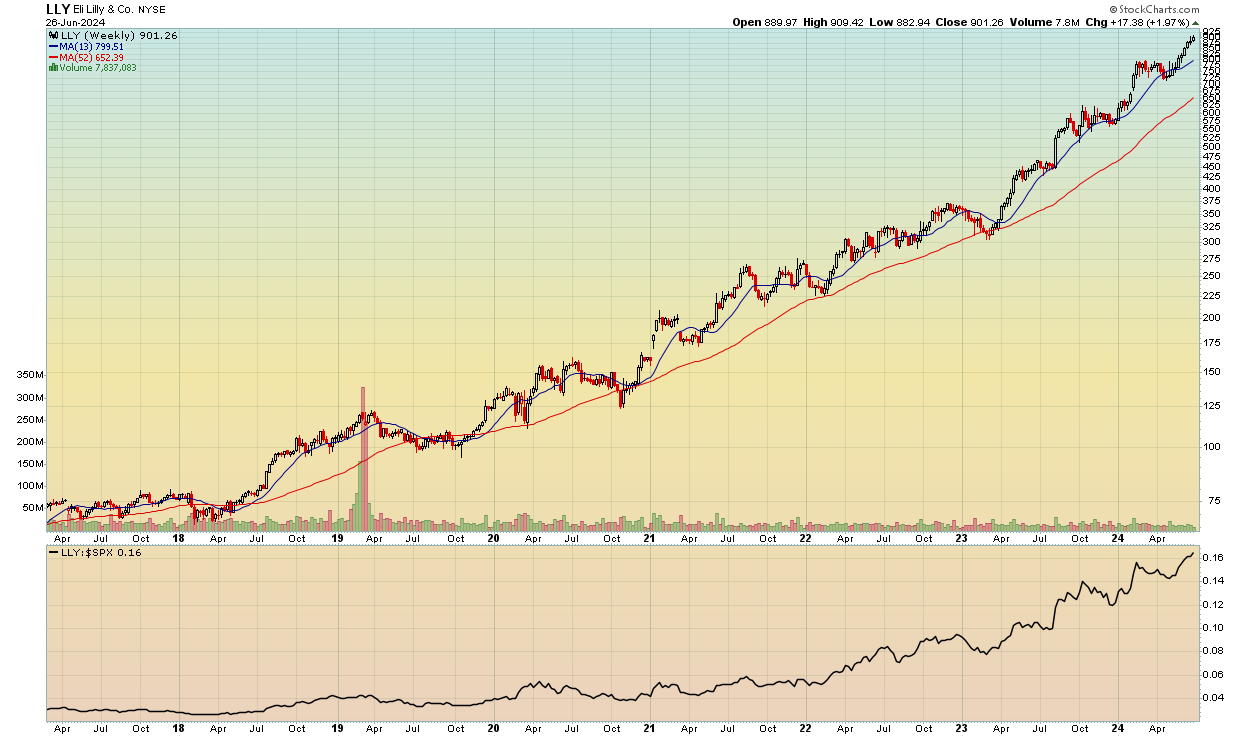

In [28]:
def fn_get_chart(driver, symbol):

    # switch to Firefox
    activate_app("Firefox")

    # Open the page
    url = f"https://stockcharts.com/h-sc/ui?s={symbol}&id=p33407302522&def=Y&listNum=1#"
    driver.get(url)

    # Locate the img tag containing the chart image
    chart_img = driver.find_element(By.ID, 'chartImg')

    # Create a selenium ActionChains object
    action_chains = ActionChains(driver)
    # Right click the image to get the context menu to appear
    action_chains.context_click(chart_img).perform()
    # Wait for the context menu to appear
    time.sleep(1)

    # this is a aystem menu, can't use Selenium so use pyautogui
    # Simulate keyboard presses to navigate and select the "Save Image As..." option
    pyautogui.press('down')
    pyautogui.press('down')
    pyautogui.press('enter')
    time.sleep(1)

    # Wait for the "Save As" dialog to appear
    time.sleep(1)
    # type the filename
    today_date_str = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    save_path = f"{symbol}-{today_date_str}"
    pyautogui.typewrite(save_path)
    pyautogui.press('Enter')

    img_path = save_path + ".png"
    # move it from default firefox download directory
    source_path = f'{DEFAULT_DOWNLOAD_DIR}/{img_path}'
    destination_path = f'{DOWNLOAD_DIR}/{img_path}'
    shutil.move(source_path, destination_path)

    return img_path

activate_app("Firefox")

img_path = fn_get_chart(driver, symbol)

# display the image
with open(f"{DOWNLOAD_DIR}/{img_path}", 'rb') as f:
    image_data = f.read()
display(Image(image_data))


In [30]:
def get_news_obb(symbol, provider):
    
    current_date = datetime.now()
    one_week_ago = current_date - timedelta(weeks=1)
    formatted_start_date = one_week_ago.strftime("%Y-%m-%d")
    formatted_end_date = current_date.strftime("%Y-%m-%d")

    openbb_results = obb.news.company(symbol=symbol, provider=provider,
                                      start_date=formatted_start_date, end_date=formatted_end_date)

    obb_df = openbb_results.to_dataframe()
    obb_df = obb_df.reset_index()[['date', 'title', 'url']]
    obb_df['src'] = provider
    return obb_df

# polygon_news_df = get_news_obb(symbol, 'polygon')
# polygon_news_df


In [31]:
tmx_news_df = get_news_obb(symbol, 'tmx')
tmx_news_df


,date,title,url,src
0,2019-08-08 09:00:00-04:00,Lilly Announces Positive Results for Emgality(...,https://money.tmx.com/quote/LLY/news/613753718...,tmx
1,2019-11-04 09:00:00-05:00,Boehringer Ingelheim and Lilly modernise allia...,https://money.tmx.com/quote/LLY/news/553574493...,tmx
2,2020-08-05 08:00:00-04:00,Empagliflozin meets primary endpoint in reduci...,https://money.tmx.com/quote/LLY/news/629707626...,tmx
3,2020-09-08 08:00:00-04:00,Empagliflozin reduced the combined relative ri...,https://money.tmx.com/quote/LLY/news/851679265...,tmx
4,2020-10-08 10:30:00-04:00,Lilly provides comprehensive update on progres...,https://money.tmx.com/quote/LLY/news/663147860...,tmx
...,...,...,...,...
62,2024-06-08 09:03:00-04:00,Lilly's tirzepatide was superior to placebo fo...,https://money.tmx.com/quote/LLY/news/568413571...,tmx
63,2024-06-11 08:45:00-04:00,Global Multiple Sclerosis Drugs Market Size Pr...,https://money.tmx.com/quote/LLY/news/715549674...,tmx
64,2024-06-21 15:49:00-04:00,Lilly's tirzepatide reduced obstructive sleep ...,https://money.tmx.com/quote/LLY/news/797025021...,tmx
65,2024-06-24 11:30:00-04:00,Lilly Declares Third-Quarter 2024 Dividend,https://money.tmx.com/quote/LLY/news/468748319...,tmx


In [32]:
yfinance_news_df = get_news_obb(symbol, 'yfinance')
yfinance_news_df


,date,title,url,src
0,2024-06-26 13:00:05,Why Investors Need to Take Advantage of These ...,https://finance.yahoo.com/news/why-investors-a...,yfinance
1,2024-06-26 14:48:57,"Novo Nordisk, Eli Lilly still top 2 pharma sto...",https://finance.yahoo.com/video/novo-nordisk-e...,yfinance
2,2024-06-26 14:55:01,"Yahoo Video: Novo Nordisk, Eli Lilly still top...",https://finance.yahoo.com/news/yahoo-video-nov...,yfinance
3,2024-06-26 16:55:26,"The S&P 500 and Nvidia, Chipotle stock split: ...",https://finance.yahoo.com/video/p-500-nvidia-c...,yfinance
4,2024-06-26 19:22:05,Lilly joins fellow pharma giants in OpenAI par...,https://finance.yahoo.com/m/a76ab61c-6e40-3ed7...,yfinance
5,2024-06-26 19:53:58,Lawmakers to vote on if Medicare could cover o...,https://finance.yahoo.com/video/lawmakers-vote...,yfinance
6,2024-06-26 21:45:21,Eli Lilly (LLY) Stock Drops Despite Market Gai...,https://finance.yahoo.com/news/eli-lilly-lly-s...,yfinance
7,2024-06-26 21:58:21,"How consumer spending, election impact markets...",https://finance.yahoo.com/video/consumer-spend...,yfinance


In [33]:
def get_news_alphavantage(symbol):

    ALPHAVANTAGE_API_KEY = os.environ['ALPHAVANTAGE_API_KEY']
    current_date = datetime.now()
    one_week_ago = current_date - timedelta(weeks=1)
    formatted_start_date = one_week_ago.strftime('%Y%m%dT0000')
    formatted_end_date = current_date.strftime('%Y%m%dT%H%M%S')
    url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={symbol}&time_from={formatted_start_date}&limit=100&apikey={ALPHAVANTAGE_API_KEY}'
    r = requests.get(url)
    data = r.json()

    # for item in data['feed']:
    #     markdown_str = ""
    #     date_object = datetime.strptime(item['time_published'], "%Y%m%dT%H%M%S")
    #     item['title'] = item['title'].replace("$", "\\\$")
    #     markdown_str += f"[{str(date_object)} {item['title']}]({item['url']})\n {item['summary']}"
    #     display(Markdown(markdown_str))

    alphavantage_df = pd.DataFrame(data['feed'])
    alphavantage_df['date'] = pd.to_datetime(alphavantage_df['time_published'], format='%Y%m%dT%H%M%S', utc=True)
    alphavantage_df = alphavantage_df[['date', 'title', 'url']]
    alphavantage_df['src'] = 'alphavantage'
    return alphavantage_df

alphavantage_df = get_news_alphavantage(symbol)
alphavantage_df


,date,title,url,src
0,2024-06-26 21:45:21+00:00,Eli Lilly ( LLY ) Stock Drops Despite Market...,https://www.zacks.com/stock/news/2293935/eli-l...,alphavantage
1,2024-06-26 17:06:30+00:00,Active Fund Managers Bet These 6 Stocks Will T...,https://www.benzinga.com/markets/equities/24/0...,alphavantage
2,2024-06-26 12:50:05+00:00,Why Investors Need to Take Advantage of These ...,https://www.zacks.com/stock/news/2293477/why-i...,alphavantage
3,2024-06-26 12:32:00+00:00,La-Z-Boy and Winnebago have been highlighted a...,https://www.zacks.com/stock/news/2293447/la-z-...,alphavantage
4,2024-06-26 11:45:00+00:00,Better Growth Stock: Archer Aviation or Viking...,https://www.fool.com/investing/2024/06/26/bett...,alphavantage
5,2024-06-26 08:35:00+00:00,2 Reasons Why Eli Lilly's Stock Likely Hasn't ...,https://www.fool.com/investing/2024/06/26/2-re...,alphavantage
6,2024-06-25 18:12:26+00:00,Novo Nordisk's Older Generation Weight-Loss Dr...,https://www.benzinga.com/general/biotech/24/06...,alphavantage
7,2024-06-25 16:50:29+00:00,What's Going On With Eli Lilly Stock On Tuesda...,https://www.benzinga.com/general/biotech/24/06...,alphavantage
8,2024-06-25 14:22:00+00:00,Novo Nordisk ( NVO ) to Invest $4.1B in Clay...,https://www.zacks.com/stock/news/2293002/novo-...,alphavantage
9,2024-06-25 14:00:00+00:00,Lilly collaborates with OpenAI to discover nov...,https://www.prnewswire.com/news-releases/lilly...,alphavantage


In [34]:
def get_news_newsapi(symbol):

    api = NewsApiClient(api_key=os.environ['NEWSAPI_API_KEY'])
    current_date = datetime.now()
    one_week_ago = current_date - timedelta(weeks=1)
    formatted_start_date = one_week_ago.strftime('%Y-%m-%d')
    formatted_end_date = current_date.strftime('%Y-%m-%d')
    
    all_articles = api.get_everything(q=symbol,
    #                                       sources='bbc-news,the-verge',
    #                                       domains='bbc.co.uk,techcrunch.com',
                                          from_param=formatted_start_date,
                                          to=formatted_end_date,
                                          language='en',
                                          sort_by='relevancy',
                                          page=1)

#     for item in all_articles['articles']:
#         markdown_str = ""
#         datestr = item['publishedAt'].split(".")[0]
#         if datestr[-1]=='Z':
#             datestr = datestr[:-1]
#         date_object = datetime.strptime(datestr, "%Y-%m-%dT%H:%M:%S")
#         item['title'] = item['title'].replace("$", "\\\$")
#         item['description'] = item['description'].replace("$", "\\\$")
#         markdown_str += f"[{str(date_object)} {item['title']}]({item['url']})\n {item['description']}"
#         display(Markdown(markdown_str))

    newsapi_df = pd.DataFrame(all_articles['articles'])
    newsapi_df['date'] = pd.to_datetime(newsapi_df['publishedAt'], utc=True)
    newsapi_df = newsapi_df[['date', 'title', 'url']]
    newsapi_df['src'] = 'NewsApi'
    return newsapi_df

# newsapi_df = get_news_newsapi(symbol)
# newsapi_df


In [35]:
newsapi_df = get_news_newsapi(symbol)
newsapi_df


,date,title,url,src
0,2024-06-23 20:14:16+00:00,Did Eli Lilly and Company (LLY) Achieve Its 10...,https://consent.yahoo.com/v2/collectConsent?se...,NewsApi
1,2024-06-24 14:33:56+00:00,What Makes Eli Lilly & Company (LLY) a Hot Hea...,https://finance.yahoo.com/news/makes-eli-lilly...,NewsApi
2,2024-06-21 19:25:37+00:00,How Long Can Extreme Concentration Last?,https://www.forbes.com/sites/randywatts/2024/0...,NewsApi
3,2024-06-20 18:07:41+00:00,WHO and Eli Lilly caution patients against fal...,https://finance.yahoo.com/news/eli-lilly-cauti...,NewsApi
4,2024-06-21 15:22:49+00:00,US Stocks Are Showing Signs Of Extreme Divergence,https://www.forbes.com/sites/seanhanlon-1/2024...,NewsApi
...,...,...,...,...
95,2024-06-24 19:12:41+00:00,Eli Lilly and Company (NYSE:LLY) Shares Acquir...,https://www.etfdailynews.com/2024/06/24/eli-li...,NewsApi
96,2024-06-26 14:36:46+00:00,Eli Lilly and Company (NYSE:LLY) Shares Sold b...,https://www.etfdailynews.com/2024/06/26/eli-li...,NewsApi
97,2024-06-25 17:04:43+00:00,Eli Lilly and Company (NYSE:LLY) Shares Sold b...,https://www.etfdailynews.com/2024/06/25/eli-li...,NewsApi
98,2024-06-25 18:12:42+00:00,Harbor Investment Advisory LLC Purchases 421 S...,https://www.etfdailynews.com/2024/06/25/harbor...,NewsApi


In [36]:
def get_news_newsfilter(symbol):

    API_KEY = os.environ['NEWSFILTER_API_KEY']
    API_ENDPOINT = "https://api.newsfilter.io/search?token={}".format(API_KEY)
    
    current_date = datetime.now()
    one_week_ago = current_date - timedelta(weeks=1)
    formatted_start_date = one_week_ago.strftime('%Y-%m-%d')
    formatted_end_date = current_date.strftime('%Y-%m-%d')

    # Define the news search parameters
    queryString = f"(source.id:sec-api OR source.id:prNewswire OR source.id:businesswire) AND symbols:{symbol} AND publishedAt:[{formatted_start_date} TO {formatted_end_date}]"
    # queryString = "(source.id:businesswire) AND publishedAt:[2023-08-15 TO 2023-08-16]"
    payload = {
        "queryString": queryString,
        "from": 0,
        "size": 200
    }

    # Send the search query to the Search API
    response = requests.post(API_ENDPOINT, json=payload)

    # Read the response
    articles = response.json()

    if len(articles['articles']) == 0:   # return empty dataframe
        return pd.DataFrame(columns=['date', 'title', 'url', 'src'])

#     for item in articles['articles']:
#         markdown_str = ""
#         date_array = item['publishedAt'].split("T")
#         datestr = date_array[0] + "T" + date_array[1][:8]
#     #     print(item['publishedAt'])
#     #     print(date_array)
#     #     print(datestr)
#         date_object = datetime.strptime(datestr, "%Y-%m-%dT%H:%M:%S")
#         item['title'] = item['title'].replace("$", "\\\$")
#         item['description'] = item['description'].replace("$", "\\\$")
#         markdown_str += f"[{str(date_object)} {item['title']}]({item['url']})\n {item['description']}"
#         display(Markdown(markdown_str))

    newsfilter_df = pd.DataFrame(articles['articles'])
    newsfilter_df['date'] = pd.to_datetime(newsfilter_df['publishedAt'], utc=True)
    newsfilter_df = newsfilter_df[['date', 'title', 'url']]
    newsfilter_df['src'] = 'NewsFilter'
    return newsfilter_df

# newsfilter_df = get_news_newsfilter(symbol)
# newsfilter_df


In [37]:
def get_news_finnhub(symbol):

    FINNHUB_API_KEY = os.environ['FINNHUB_API_KEY']
    current_date = datetime.now()
    one_week_ago = current_date - timedelta(weeks=1)
    formatted_start_date = one_week_ago.strftime('%Y-%m-%d')
    formatted_end_date = current_date.strftime('%Y-%m-%d')
    
    url=f'https://finnhub.io/api/v1/company-news?symbol={symbol}&from={formatted_start_date}&to={formatted_end_date}&token={FINNHUB_API_KEY}'
    response = requests.get(url)
    response_json = response.json()
    finnhub_df = pd.DataFrame(response_json)
    finnhub_df['date'] = pd.to_datetime(finnhub_df['datetime'], unit='s', utc=True)
    finnhub_df = finnhub_df.rename(columns={'headline': 'title'})
    finnhub_df = finnhub_df[['date', 'title', 'url']]
    finnhub_df['src'] = 'Finnhub'
    return finnhub_df

finnhub_df = get_news_finnhub(symbol)
finnhub_df


,date,title,url,src
0,2024-06-26 14:55:01+00:00,"Yahoo Video: Novo Nordisk, Eli Lilly still top...",https://finnhub.io/api/news?id=3e35d5d2c67f9e0...,Finnhub
1,2024-06-26 14:48:57+00:00,"Novo Nordisk, Eli Lilly still top 2 pharma sto...",https://finnhub.io/api/news?id=73d665833f7c343...,Finnhub
2,2024-06-26 13:00:05+00:00,Why Investors Need to Take Advantage of These ...,https://finnhub.io/api/news?id=cfcf37aacb7beee...,Finnhub
3,2024-06-26 12:32:00+00:00,La-Z-Boy and Winnebago have been highlighted a...,https://finnhub.io/api/news?id=46c20809df2c5e3...,Finnhub
4,2024-06-26 11:00:00+00:00,The War Over Cheaper Ozempic Won’t End Well fo...,https://finnhub.io/api/news?id=f16184bd37aabe1...,Finnhub
...,...,...,...,...
143,2024-06-20 06:45:00+00:00,Eli Lilly Expands Fight Against Counterfeit Ob...,https://finnhub.io/api/news?id=be9df28e5f129fd...,Finnhub
144,2024-06-20 06:39:09+00:00,Eli Lilly and : An Open Letter From Eli Lilly ...,https://finnhub.io/api/news?id=88d67a402277978...,Finnhub
145,2024-06-20 06:30:30+00:00,Lilly files additional lawsuits over US sales ...,https://finnhub.io/api/news?id=614425cffd1772b...,Finnhub
146,2024-06-19 17:00:00+00:00,Can Eli Lilly ETFs Surge on Approval of Alzhei...,https://finnhub.io/api/news?id=88a4cccd23398db...,Finnhub


In [38]:
def get_news_df(symbol, company):
    google_news_df = get_google_news(symbol, company)
    finviz_news_df = get_finviz_news(symbol)
    polygon_news_df = get_news_obb(symbol, 'polygon')
    tmx_news_df = get_news_obb(symbol, 'tmx')
    yfinance_news_df = get_news_obb(symbol, 'yfinance')
    alphavantage_df = get_news_alphavantage(symbol)
    finnhub_df = get_news_finnhub(symbol)
    newsapi_df = get_news_newsapi(symbol)
    newsfilter_df = get_news_newsfilter(symbol)

    news_df = pd.concat([google_news_df,
                         finviz_news_df,                         
                         polygon_news_df,
                         tmx_news_df,
                         yfinance_news_df,
                         alphavantage_df,
                         finnhub_df,
                         newsapi_df,
                         newsfilter_df]
                       )
    news_df = news_df.reset_index(drop=True) \
        .reset_index() \
        .rename(columns={'index': 'id'})

    return news_df


news_df = get_news_df(symbol, company)
news_df



21:46:15 Starting init_driver
21:46:28 Initialized profile
21:46:28 Initialized service
21:47:05 Initialized webdriver
21:47:17 Saving Google (06_26_2024 09_47_17 PM).html as utf-8 get_files(Google)
found 349 raw links
found 156 filtered links


,id,date,title,url,src
0,0,2024-06-26 21:47:17.240639,News Showcase,https://news.google.com/showcase,Google News
1,1,2024-06-26 21:47:17.240639,Entertainment,https://news.google.com/topics/CAAqJggKIiBDQkF...,Google News
2,2,2024-06-26 21:47:17.240639,Severe Thunderstorm WatchTHE NATIONAL WEATHER ...,https://www.google.com/search,Google News
3,3,2024-06-26 21:47:17.240639,More on weather.com,https://www.weather.com/wx/today/,Google News
4,4,2024-06-26 21:47:17.240639,Top stories,https://news.google.com/topics/CAAqJggKIiBDQkF...,Google News
...,...,...,...,...,...
636,636,2024-06-24 20:11:10+00:00,11-K Form - Annual report of employee stock pu...,https://newsfilter.io/articles/11-k-form---ann...,NewsFilter
637,637,2024-06-24 15:30:00+00:00,Lilly Declares Third-Quarter 2024 Dividend,https://newsfilter.io/articles/lilly-declares-...,NewsFilter
638,638,2024-06-21 20:00:06+00:00,4 Form - Statement of changes in beneficial ow...,https://newsfilter.io/articles/4-form---statem...,NewsFilter
639,639,2024-06-21 19:49:00+00:00,Lilly&apos;s tirzepatide reduced obstructive s...,https://newsfilter.io/articles/lillyaposs-tirz...,NewsFilter


In [39]:
news_df['date'] = pd.to_datetime(news_df['date'], utc=True)
news_df['date'] = news_df['date'].dt.tz_convert('UTC')
news_df = news_df.sort_values(by='date')
news_df

,id,date,title,url,src
275,275,2019-08-08 13:00:00+00:00,Lilly Announces Positive Results for Emgality(...,https://money.tmx.com/quote/LLY/news/613753718...,tmx
276,276,2019-11-04 14:00:00+00:00,Boehringer Ingelheim and Lilly modernise allia...,https://money.tmx.com/quote/LLY/news/553574493...,tmx
277,277,2020-08-05 12:00:00+00:00,Empagliflozin meets primary endpoint in reduci...,https://money.tmx.com/quote/LLY/news/629707626...,tmx
278,278,2020-09-08 12:00:00+00:00,Empagliflozin reduced the combined relative ri...,https://money.tmx.com/quote/LLY/news/851679265...,tmx
279,279,2020-10-08 14:30:00+00:00,Lilly provides comprehensive update on progres...,https://money.tmx.com/quote/LLY/news/663147860...,tmx
...,...,...,...,...,...
252,252,2024-06-26 21:47:17.447757+00:00,Lillys Weight-Loss Drug Is a Huge Hit. Its CEO...,https://finance.yahoo.com/m/f725b402-9d2b-3ac4...,finviz
253,253,2024-06-26 21:47:17.447758+00:00,Why Eli Lilly (LLY) is a Top Momentum Stock fo...,https://www.zacks.com/stock/news/2287885/why-e...,finviz
254,254,2024-06-26 21:47:17.447758+00:00,Billionaire Israel Englander is Buying This We...,https://finance.yahoo.com/news/billionaire-isr...,finviz
255,255,2024-06-26 21:47:17.447759+00:00,Want to Get Richer? 2 Top Stocks to Buy Now an...,https://finance.yahoo.com/m/d5cf8979-a294-3558...,finviz


In [40]:
# dedupe headlines with exact same title
news_df = news_df.groupby('title').last().reset_index()[['date', 'title', 'url', 'src']]
news_df

,date,title,url,src
0,2024-06-25 09:12:00+00:00,1 Supercharged Vanguard Index Fund to Buy Befo...,https://www.fool.com/investing/2024/06/25/1-in...,polygon
1,2024-06-20 13:50:44+00:00,"1,084 Shares in Eli Lilly and Company (NYSE:LL...",https://www.etfdailynews.com/2024/06/20/1084-s...,NewsApi
2,2024-06-26 21:47:17.447733+00:00,10 Dividend Zombies and Kings with Longest Div...,https://www.insidermonkey.com/blog/10-dividend...,finviz
3,2024-06-25 12:39:00+00:00,10 Health Care Stocks Whale Activity In Today'...,https://finnhub.io/api/news?id=afdba26581f2107...,Finnhub
4,2024-06-24 20:11:10+00:00,11-K Form - Annual report of employee stock pu...,https://newsfilter.io/articles/11-k-form---ann...,NewsFilter
...,...,...,...,...
510,2024-05-16 10:45:00+00:00,"With Once-a-Week Dosing, Insulin Efsitora Alfa...",https://money.tmx.com/quote/LLY/news/617311369...,tmx
511,2024-06-21 11:56:49+00:00,Woodstock Corp Buys 31 Shares of Eli Lilly and...,https://www.etfdailynews.com/2024/06/21/woodst...,NewsApi
512,2024-06-26 14:55:01+00:00,"Yahoo Video: Novo Nordisk, Eli Lilly still top...",https://finance.yahoo.com/news/yahoo-video-nov...,yfinance
513,2024-06-21 07:23:00+00:00,Zealand Pharma extends gains on early-stage da...,https://finnhub.io/api/news?id=758713cd82e1eff...,Finnhub


In [41]:
one_week_ago = pd.Timestamp.now(tz='UTC') - timedelta(weeks=1)
news_df = news_df.loc[news_df['date'] > one_week_ago]
news_df = news_df.reset_index(drop=True)
news_df = news_df.reset_index()
news_df = news_df.rename(columns={'index': 'id'})
news_df


,id,date,title,url,src
0,0,2024-06-25 09:12:00+00:00,1 Supercharged Vanguard Index Fund to Buy Befo...,https://www.fool.com/investing/2024/06/25/1-in...,polygon
1,1,2024-06-20 13:50:44+00:00,"1,084 Shares in Eli Lilly and Company (NYSE:LL...",https://www.etfdailynews.com/2024/06/20/1084-s...,NewsApi
2,2,2024-06-26 21:47:17.447733+00:00,10 Dividend Zombies and Kings with Longest Div...,https://www.insidermonkey.com/blog/10-dividend...,finviz
3,3,2024-06-25 12:39:00+00:00,10 Health Care Stocks Whale Activity In Today'...,https://finnhub.io/api/news?id=afdba26581f2107...,Finnhub
4,4,2024-06-24 20:11:10+00:00,11-K Form - Annual report of employee stock pu...,https://newsfilter.io/articles/11-k-form---ann...,NewsFilter
...,...,...,...,...,...
436,436,2024-06-26 21:47:17.240639+00:00,Windows on Arm finally has legs,https://news.google.com/articles/CBMibWh0dHBzO...,Google News
437,437,2024-06-21 11:56:49+00:00,Woodstock Corp Buys 31 Shares of Eli Lilly and...,https://www.etfdailynews.com/2024/06/21/woodst...,NewsApi
438,438,2024-06-26 14:55:01+00:00,"Yahoo Video: Novo Nordisk, Eli Lilly still top...",https://finance.yahoo.com/news/yahoo-video-nov...,yfinance
439,439,2024-06-21 07:23:00+00:00,Zealand Pharma extends gains on early-stage da...,https://finnhub.io/api/news?id=758713cd82e1eff...,Finnhub


In [42]:
MAXPAGELEN = 50
MAX_INPUT_TOKENS = 8192     # includes text of all headlines


def paginate_df(filtered_df, maxpagelen=MAXPAGELEN, max_input_tokens=MAX_INPUT_TOKENS):
    """
    Splits the filtered dataframe into pages based on the maximum page length in rows and maximum input tokens in titles.

    Args:
        filtered_df (pandas.DataFrame): The filtered dataframe to be paginated.
        maxpagelen (int, optional): The maximum length of each page in characters. Defaults to MAXPAGELEN.
        max_input_tokens (int, optional): The maximum number of tokens allowed in each page. Defaults to MAX_INPUT_TOKENS.

    Returns:
        list: A list of pages, where each page is a list of dictionaries representing the links.

    """

    pages = []
    current_page = []
    pagelength = 0

    enc = tiktoken.encoding_for_model('gpt-4')
    assert enc.decode(enc.encode("hello world")) == "hello world"

    for row in filtered_df.itertuples():
        curlink = {"id": row.Index, "title": row.title}
        curlength = len(enc.encode(json.dumps(curlink)))
        # Check if adding the current string would exceed the limit
        if len(current_page) >= maxpagelen or pagelength + curlength > max_input_tokens:
            # If so, start a new page
            pages.append(current_page)
            current_page = [curlink]
            pagelength = curlength
        else:
            # Otherwise, add the string to the current page
            current_page.append(curlink)
            pagelength += curlength

    # add the last page if it's not empty
    if current_page:
        pages.append(current_page)
    return pages


pages = paginate_df(news_df)
pages


[[{'id': 0,
   'title': '1 Supercharged Vanguard Index Fund to Buy Before It Soars 174%, According to a Wall Street Analyst'},
  {'id': 1,
   'title': '1,084 Shares in Eli Lilly and Company (NYSE:LLY) Purchased by Emprise Bank'},
  {'id': 2,
   'title': '10 Dividend Zombies and Kings with Longest Dividend Payouts'},
  {'id': 3,
   'title': "10 Health Care Stocks Whale Activity In Today's Session"},
  {'id': 4,
   'title': '11-K Form - Annual report of employee stock purchase, savings and similar plans - ELI LILLY & Co (0000059478) (Filer)'},
  {'id': 5,
   'title': '144 Form - Report of proposed sale of securities - ELI LILLY & Co (0000059478) (Subject)'},
  {'id': 6, 'title': "2 Reasons Why Eli Lilly's Stock Likely Hasn't Peaked"},
  {'id': 7, 'title': '2024 NBA Draft: Live Grades for Every Round 1 Pick'},
  {'id': 8,
   'title': '2024 NFL OTAs: Players who surprised us most at minicamp'},
  {'id': 9,
   'title': '297 Shares in Eli Lilly and Company (NYSE:LLY) Bought by Conrad Siegel 

In [43]:
pages = paginate_df(news_df)
pages


[[{'id': 0,
   'title': '1 Supercharged Vanguard Index Fund to Buy Before It Soars 174%, According to a Wall Street Analyst'},
  {'id': 1,
   'title': '1,084 Shares in Eli Lilly and Company (NYSE:LLY) Purchased by Emprise Bank'},
  {'id': 2,
   'title': '10 Dividend Zombies and Kings with Longest Dividend Payouts'},
  {'id': 3,
   'title': "10 Health Care Stocks Whale Activity In Today's Session"},
  {'id': 4,
   'title': '11-K Form - Annual report of employee stock purchase, savings and similar plans - ELI LILLY & Co (0000059478) (Filer)'},
  {'id': 5,
   'title': '144 Form - Report of proposed sale of securities - ELI LILLY & Co (0000059478) (Subject)'},
  {'id': 6, 'title': "2 Reasons Why Eli Lilly's Stock Likely Hasn't Peaked"},
  {'id': 7, 'title': '2024 NBA Draft: Live Grades for Every Round 1 Pick'},
  {'id': 8,
   'title': '2024 NFL OTAs: Players who surprised us most at minicamp'},
  {'id': 9,
   'title': '297 Shares in Eli Lilly and Company (NYSE:LLY) Bought by Conrad Siegel 

In [44]:
MAX_OUTPUT_TOKENS = 4096
MAX_RETRIES = 3
TEMPERATURE = 0

async def get_response_json(
    client,
    messages,
    verbose=False,
    model=MODEL,
    max_output_tokens=MAX_OUTPUT_TOKENS,
    max_retries=MAX_RETRIES,
    temperature=TEMPERATURE,
):
    """
    Calls the OpenAI client with messages and returns the response as a JSON string.
    response_format={"type": "json_object"} forces ChatGPT to return a valid JSON string.

    Args:
        client (OpenAI.ChatCompletionClient): The OpenAI client used to make the API call.
        messages (str or list): The messages to send to the chat model. If a string is provided, it will be converted to a list with a single message.
        verbose (bool, optional): Whether to print the messages to the console. Defaults to False.
        model (str, optional): The model to use for chat completion. Defaults to MODEL.
        max_output_tokens (int, optional): The maximum number of tokens in the response. Defaults to MAX_OUTPUT_TOKENS.
        max_retries (int, optional): The maximum number of retries in case of API errors. Defaults to MAX_RETRIES.
        temperature (float, optional): The temperature parameter for generating diverse responses. Defaults to TEMPERATURE.

    Returns:
        dict: The response from the OpenAI API as a JSON object.

    Raises:
        Exception: If an error occurs during the API call.

    """
    if type(messages) is not list:  # allow passing one string for convenience
        messages = [{"role": "user", "content": messages}]

    if verbose:
        print("\n".join([str(msg) for msg in messages]))

    # truncate number of tokens
    # retry loop, have received untrapped 500 errors like too busy
    for i in range(max_retries):
        if i > 0:
            print(f"Attempt {i+1}...")
        try:
            response = client.chat.completions.create(
                model=model,
                messages=messages,
                temperature=temperature,
                max_tokens=max_output_tokens,
                response_format={"type": "json_object"},
            )
            # no exception thrown
            return response
        except Exception as error:
            print(f"An exception occurred on attempt {i+1}:", error)
            time.sleep(sleeptime)
            continue  # try again
        # retries exceeded if you got this far
    print("Retries exceeded.")
    return None



In [45]:
async def fetch_response(client, prompt, p):
    """Fetches the response from the OpenAI client based on the given prompt and page.

    Args:
        client (OpenAI.Client): The OpenAI client used to make the API request.
        prompt (str): The prompt to be processed by the OpenAI client.
        p (dict): The page containing keys and values to be processed.

    Returns:
        list: The response as a list of keys and values.

    Raises:
        TypeError: If the response is not a dictionary or a list.

    """
    retlist = []
    response = await get_response_json(client, prompt + json.dumps(p))
    response_json = json.loads(response.choices[0].message.content)

    if type(response_json) is dict:
        for k, v in response_json.items():
            if type(v) is list:  # came back correctly as e.g. {'stories': []}
                retlist.extend(v)
            else:  # maybe a weird dict with keys  of id
                retlist.append(v)
        print(f"{datetime.now().strftime('%H:%M:%S')} got dict with {len(retlist)} items ")
    elif type(response_json) is list:
        retlist = response_json
        print(f"{datetime.now().strftime('%H:%M:%S')} got list with {len(retlist)} items ")
    else:
        raise TypeError("Error: Invalid response type")

    sent_ids = [s['id'] for s in p]
    received_ids = [r['id'] for r in response_json['stories']]
    difference = set(sent_ids) - set(received_ids)

    if difference:
        print(f"missing items, {str(difference)}")
        return []
    else:
        return retlist


In [48]:
async def process_pages(client, symbol, company, pages):
    """
    Process a list of pages by sending them individually to the OpenAI API with the given prompt.

    Args:
        client (OpenAI.Client): The OpenAI API client.
        prompt (str): The prompt template to be sent to the OpenAI API.
        pages (list): A list of pages to be processed.

    Returns:
        list: A list of enriched URLs.

    """

    company_str = f"{company} (symbol {symbol})"
    prompt = f"""You will act as a research assistant to categorize news articles based on their relevance
to the topic of the following company {company_str}. You will process and classify news headlines
formatted as JSON objects.

Input Specification:
You will receive a list of news stories formatted as JSON objects.
Each object will include an 'id' and a 'title'. For instance:
[{{'id': 0, 'title': 'Nvidia: Time To Admit My Big Mistake (Rating Upgrade)'}},
 {{'id': 1,
  'title': 'Tesla Faces Uphill Battle: Morgan Stanley Analyst Adam Jonas Cuts Target Price, Forecasts Lower FY24 Sales Volume'}},
 {{'id': 2, 'title': 'Why Investors Slammed the Brakes on Tesla Stock Today'}},
 {{'id': 3,
  'title': 'The 2024 GMC Hummer EV SUV: Reimagined, futuristic, luxurious and an off-road champ'}},
 {{'id': 4,
  'title': 'Jim Cramer Weighs In On Tuesday Market Decline, Says It Reflects A Market Top, Not A Bubble'}}]

Classification Criteria:
Classify each story based on its title to determine whether it primarily pertains to {company_str} .
Narrowly define company-related to be a headline that would be of interest to an investor in the company
because it is related to the company's business, products and services. Do not include headlines that only
mention the company or symbol as part of a broad topic like the day's stock market activity.

Output Specification:
You will return a JSON object with the field 'stories' containing the list of classification results.
For each story, your output will be a JSON object containing the original 'id' and a new field 'related',
a boolean indicating if the story is about {company_str}. The output schema must be strictly adhered to, 
without any additional fields. Example output for company 'Tesla (symbol TSLA)':
{{'stories':
[{{'id': 0, 'related': false}},
 {{'id': 1, 'related': true}},
 {{'id': 2, 'related': true}},
 {{'id': 3, 'related': false}},
 {{'id': 4, 'related': false}}]
}}

Ensure that each output object accurately reflects the corresponding input object in terms of the 'id' field
and that the '':' field accurately represents the relevance of the story to {company_str} as determined by the title.

The list of news stories to classify is:
"""
    print(prompt)
    enriched_urls = []
    tasks = []
    for i, p in enumerate(pages):
        print(f"send page {i+1} of {len(pages)}, {len(p)} items ")
        task = asyncio.create_task(fetch_response(client, prompt, p))
        tasks.append(task)
    responses = await asyncio.gather(*tasks)
    for retlist in responses:
        if retlist:
            enriched_urls.extend(retlist)
        else:
            print("process_pages failed")
    return enriched_urls



In [49]:
client = OpenAI()

result = await process_pages(client, symbol, company, pages)

result


You will act as a research assistant to categorize news articles based on their relevance
to the topic of the following company Eli Lilly (symbol LLY). You will process and classify news headlines
formatted as JSON objects.

Input Specification:
You will receive a list of news stories formatted as JSON objects.
Each object will include an 'id' and a 'title'. For instance:
[{'id': 0, 'title': 'Nvidia: Time To Admit My Big Mistake (Rating Upgrade)'},
 {'id': 1,
  'title': 'Tesla Faces Uphill Battle: Morgan Stanley Analyst Adam Jonas Cuts Target Price, Forecasts Lower FY24 Sales Volume'},
 {'id': 2, 'title': 'Why Investors Slammed the Brakes on Tesla Stock Today'},
 {'id': 3,
  'title': 'The 2024 GMC Hummer EV SUV: Reimagined, futuristic, luxurious and an off-road champ'},
 {'id': 4,
  'title': 'Jim Cramer Weighs In On Tuesday Market Decline, Says It Reflects A Market Top, Not A Bubble'}]

Classification Criteria:
Classify each story based on its title to determine whether it primarily pe

[{'id': 0, 'related': False},
 {'id': 1, 'related': True},
 {'id': 2, 'related': False},
 {'id': 3, 'related': False},
 {'id': 4, 'related': True},
 {'id': 5, 'related': True},
 {'id': 6, 'related': True},
 {'id': 7, 'related': False},
 {'id': 8, 'related': False},
 {'id': 9, 'related': True},
 {'id': 10, 'related': False},
 {'id': 11, 'related': False},
 {'id': 12, 'related': False},
 {'id': 13, 'related': True},
 {'id': 14, 'related': True},
 {'id': 15, 'related': False},
 {'id': 16, 'related': False},
 {'id': 17, 'related': True},
 {'id': 18, 'related': False},
 {'id': 19, 'related': False},
 {'id': 20, 'related': False},
 {'id': 21, 'related': False},
 {'id': 22, 'related': False},
 {'id': 23, 'related': False},
 {'id': 24, 'related': True},
 {'id': 25, 'related': False},
 {'id': 26, 'related': False},
 {'id': 27, 'related': False},
 {'id': 28, 'related': True},
 {'id': 29, 'related': True},
 {'id': 30, 'related': True},
 {'id': 31, 'related': False},
 {'id': 32, 'related': True},


In [50]:
relevance_df = pd.DataFrame(result)
relevance_df


,id,related
0,0,False
1,1,True
2,2,False
3,3,False
4,4,True
...,...,...
436,436,False
437,437,True
438,438,True
439,439,False


In [51]:
merged_df = pd.merge(news_df, relevance_df, on="id", how="outer")
# merged_df['date'] = datetime.now().date()
merged_df


,id,date,title,url,src,related
0,0,2024-06-25 09:12:00+00:00,1 Supercharged Vanguard Index Fund to Buy Befo...,https://www.fool.com/investing/2024/06/25/1-in...,polygon,False
1,1,2024-06-20 13:50:44+00:00,"1,084 Shares in Eli Lilly and Company (NYSE:LL...",https://www.etfdailynews.com/2024/06/20/1084-s...,NewsApi,True
2,2,2024-06-26 21:47:17.447733+00:00,10 Dividend Zombies and Kings with Longest Div...,https://www.insidermonkey.com/blog/10-dividend...,finviz,False
3,3,2024-06-25 12:39:00+00:00,10 Health Care Stocks Whale Activity In Today'...,https://finnhub.io/api/news?id=afdba26581f2107...,Finnhub,False
4,4,2024-06-24 20:11:10+00:00,11-K Form - Annual report of employee stock pu...,https://newsfilter.io/articles/11-k-form---ann...,NewsFilter,True
...,...,...,...,...,...,...
436,436,2024-06-26 21:47:17.240639+00:00,Windows on Arm finally has legs,https://news.google.com/articles/CBMibWh0dHBzO...,Google News,False
437,437,2024-06-21 11:56:49+00:00,Woodstock Corp Buys 31 Shares of Eli Lilly and...,https://www.etfdailynews.com/2024/06/21/woodst...,NewsApi,True
438,438,2024-06-26 14:55:01+00:00,"Yahoo Video: Novo Nordisk, Eli Lilly still top...",https://finance.yahoo.com/news/yahoo-video-nov...,yfinance,True
439,439,2024-06-21 07:23:00+00:00,Zealand Pharma extends gains on early-stage da...,https://finnhub.io/api/news?id=758713cd82e1eff...,Finnhub,False


In [52]:
for row in merged_df.loc[merged_df['related']].itertuples():
    display(Markdown(f"[{row.date} {row.title}]({row.url})  "))


[2024-06-20 13:50:44+00:00 1,084 Shares in Eli Lilly and Company (NYSE:LLY) Purchased by Emprise Bank](https://www.etfdailynews.com/2024/06/20/1084-shares-in-eli-lilly-and-company-nyselly-purchased-by-emprise-bank/)  

[2024-06-24 20:11:10+00:00 11-K Form - Annual report of employee stock purchase, savings and similar plans - ELI LILLY & Co (0000059478) (Filer)](https://newsfilter.io/articles/11-k-form---annual-report-of-employee-stock-purchase-savings-and-similar-plans---eli-lilly--co-00000-d4fa1c9f1b4290e96de061cd7c6074a2)  

[2024-06-20 18:43:03+00:00 144 Form - Report of proposed sale of securities - ELI LILLY & Co (0000059478) (Subject)](https://newsfilter.io/articles/144-form---report-of-proposed-sale-of-securities---eli-lilly--co-0000059478-subject-41d383bbabaad13873e30c52772707b2)  

[2024-06-26 21:47:17.447705+00:00 2 Reasons Why Eli Lilly's Stock Likely Hasn't Peaked](https://finance.yahoo.com/m/8e0feebc-417b-31cb-92c5-d261799dfe3e/2-reasons-why-eli-lilly%27s.html)  

[2024-06-26 21:47:17.240639+00:00 297 Shares in Eli Lilly and Company (NYSE:LLY) Bought by Conrad Siegel Investment Advisors Inc.](https://news.google.com/articles/CBMiiAFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjIvMjk3LXNoYXJlcy1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS1ib3VnaHQtYnktY29ucmFkLXNpZWdlbC1pbnZlc3RtZW50LWFkdmlzb3JzLWluYy5odG1s0gEA)  

[2024-06-26 13:25:08+00:00 314 Shares in Eli Lilly and Company (NYSE:LLY) Acquired by Central Valley Advisors LLC](https://www.etfdailynews.com/2024/06/26/314-shares-in-eli-lilly-and-company-nyselly-acquired-by-central-valley-advisors-llc/)  

[2024-06-26 20:00:05+00:00 4 Form - Statement of changes in beneficial ownership of securities - ELI LILLY & Co (0000059478) (Issuer)](https://newsfilter.io/articles/4-form---statement-of-changes-in-beneficial-ownership-of-securities---eli-lilly--co-0000059478-issue-845aa6c69fa0bcc34f13c0f24a2caefc)  

[2024-06-26 21:47:17.240639+00:00 A 'Heads Up' on Eli Lilly as the Stock Continues to Climb](https://news.google.com/articles/CBMiXWh0dHBzOi8vcHJvLnRoZXN0cmVldC5jb20vdHJhZGUtaWRlYXMvYS1oZWFkcy11cC1vbi1lbGktbGlsbHktYXMtdGhlLXN0b2NrLWNvbnRpbnVlcy10by1jbGltYtIBAA)  

[2024-06-24 19:12:41+00:00 Abacus Planning Group Inc. Cuts Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/abacus-planning-group-inc-cuts-holdings-in-eli-lilly-and-company-nyselly/)  

[2024-06-25 13:04:41+00:00 AdvisorNet Financial Inc Lowers Stock Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/25/advisornet-financial-inc-lowers-stock-position-in-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.240639+00:00 After Earnings, Is Eli Lilly Stock a Buy, a Sell, or Fairly Valued?](https://news.google.com/articles/CBMiYGh0dHBzOi8vd3d3Lm1vcm5pbmdzdGFyLmNvbS9zdG9ja3MvYWZ0ZXItZWFybmluZ3MtaXMtZWxpLWxpbGx5LXN0b2NrLWJ1eS1zZWxsLW9yLWZhaXJseS12YWx1ZWQtMtIBAA)  

[2024-06-21 11:56:49+00:00 Alaska Permanent Fund Corp Has $14.08 Million Stake in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/alaska-permanent-fund-corp-has-14-08-million-stake-in-eli-lilly-and-company-nyselly/)  

[2024-06-23 16:50:42+00:00 Allied Investment Advisors LLC Takes $209,000 Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/allied-investment-advisors-llc-takes-209000-position-in-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.240639+00:00 Allied Investment Advisors LLC Takes Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMie2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMy9hbGxpZWQtaW52ZXN0bWVudC1hZHZpc29ycy1sbGMtdGFrZXMtcG9zaXRpb24taW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  

[2024-06-22 09:01:00+00:00 Analysts Are Bullish on Top Healthcare Stocks: Vertex Pharmaceuticals (VRTX), Eli Lilly & Co (LLY)](https://finnhub.io/api/news?id=2d8e998d25b2946f3cd3baeea3470d94387f4c7d1dbef41d7bb32fe5767c6e18)  

[2024-06-22 08:51:00+00:00 Analysts Offer Insights on Healthcare Companies: Eli Lilly & Co (LLY) and Vertex Pharmaceuticals (VRTX)](https://finnhub.io/api/news?id=62eaa9dd141109d13403660807df1db83cfb5f4f381e05a1b92c6b73672ce7cb)  

[2024-06-24 19:46:41+00:00 Anderson Hoagland & Co. Has $17.39 Million Stock Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/anderson-hoagland-co-has-17-39-million-stock-position-in-eli-lilly-and-company-nyselly/)  

[2024-06-22 17:20:45+00:00 Aprio Wealth Management LLC Purchases 378 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/aprio-wealth-management-llc-purchases-378-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.240639+00:00 Bangor Savings Bank Sells 47 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMicWh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9iYW5nb3Itc2F2aW5ncy1iYW5rLXNlbGxzLTQ3LXNoYXJlcy1vZi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-22 10:30:41+00:00 Banque Cantonale Vaudoise Buys 2,383 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/banque-cantonale-vaudoise-buys-2383-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-24 09:13:00+00:00 BofA says OSA resolution magnitude of tirzepatide not baked into Lilly shares](https://finnhub.io/api/news?id=575b4944c1fa15f810b6d9d49f6618c9e5155870f09269c4842a16edee526dbd)  

[2024-06-24 17:22:42+00:00 Bridge Creek Capital Management LLC Reduces Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/bridge-creek-capital-management-llc-reduces-position-in-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.240639+00:00 Bridge Creek Capital Management LLC Sells 125 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMiggFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjQvYnJpZGdlLWNyZWVrLWNhcGl0YWwtbWFuYWdlbWVudC1sbGMtc2VsbHMtMTI1LXNoYXJlcy1vZi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-26 21:47:17.447748+00:00 Broadcom Is on Track to Edge Past Eli Lillys Market Value. AI Is Helping It Do So.](https://finance.yahoo.com/m/02610377-0198-3d01-a705-78cc58935fcb/broadcom-is-on-track-to-edge.html)  

[2024-06-26 21:47:17.447733+00:00 Broadcom, Eli Lilly and Trump Media rise premarket; Under Armour falls](https://finance.yahoo.com/news/broadcom-eli-lilly-trump-media-072221862.html)  

[2024-06-24 05:19:00+00:00 Buy Rating Affirmed for Eli Lilly on Tirzepatide’s Promise in OSA and Obesity Treatment](https://finnhub.io/api/news?id=08ad3250cb47156a757ca2fd79596823864cc252335a488bf2fe03c8773f8915)  

[2024-06-26 21:47:17.240639+00:00 CHICAGO TRUST Co NA Has $4.84 Million Stake in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMieGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS9jaGljYWdvLXRydXN0LWNvLW5hLWhhcy00LTg0LW1pbGxpb24tc3Rha2UtaW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  

[2024-06-26 21:47:17.240639+00:00 CHURCHILL MANAGEMENT Corp Purchases New Shares in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMifGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMy9jaHVyY2hpbGwtbWFuYWdlbWVudC1jb3JwLXB1cmNoYXNlcy1uZXctc2hhcmVzLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  

[2024-06-23 12:22:43+00:00 Cardano Risk Management B.V. Acquires 199 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/cardano-risk-management-b-v-acquires-199-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.240639+00:00 Central Valley Advisors LLC Buys Shares of 314 Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMieWh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNi9jZW50cmFsLXZhbGxleS1hZHZpc29ycy1sbGMtYnV5cy1zaGFyZXMtb2YtMzE0LWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  

[2024-06-26 07:32:00+00:00 Chart Of The Day: Eli Lilly - More New Highs](https://finnhub.io/api/news?id=8b8511f7bc94b678c83bec4448b1fe4c15bbaa2d1cfbe241ef446d91eceb8f2a)  

[2024-06-26 21:47:17.240639+00:00 Chart of the Day: Eli Lilly - More New Highs](https://news.google.com/articles/CBMiZGh0dHBzOi8vd3d3LnRyYWRpbmd2aWV3LmNvbS9uZXdzL2JhcmNoYXJ0OmFlOGFkYWE0ZTA5NGI6MC1jaGFydC1vZi10aGUtZGF5LWVsaS1saWxseS1tb3JlLW5ldy1oaWdocy_SAQA)  

[2024-06-24 12:10:48+00:00 City State Bank Sells 203 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/city-state-bank-sells-203-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-20 17:48:47+00:00 Compass Wealth Management LLC Sells 420 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/20/compass-wealth-management-llc-sells-420-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.240639+00:00 Cooper Financial Group Buys 211 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMidGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9jb29wZXItZmluYW5jaWFsLWdyb3VwLWJ1eXMtMjExLXNoYXJlcy1vZi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-21 15:28:42+00:00 Curbstone Financial Management Corp Trims Stake in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/curbstone-financial-management-corp-trims-stake-in-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.447733+00:00 Did Eli Lilly and Company (LLY) Achieve Its 10th Consecutive Year of Dividend Growth?](https://www.insidermonkey.com/blog/did-eli-lilly-and-company-lly-achieve-its-10th-consecutive-year-of-dividend-growth-1316939/)  

[2024-06-26 21:47:17.240639+00:00 Douglas Lane & Associates LLC Sells 322 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMiemh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9kb3VnbGFzLWxhbmUtYXNzb2NpYXRlcy1sbGMtc2VsbHMtMzIyLXNoYXJlcy1vZi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 Dynamic Advisor Solutions LLC Boosts Holdings in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMie2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNi9keW5hbWljLWFkdmlzb3Itc29sdXRpb25zLWxsYy1ib29zdHMtaG9sZGluZ3MtaW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  

[2024-06-20 21:45:19+00:00 Eli Lilly  ( LLY )  Registers a Bigger Fall Than the Market: Important Facts to Note](https://www.zacks.com/stock/news/2291076/eli-lilly-lly-registers-a-bigger-fall-than-the-market-important-facts-to-note)  

[2024-06-26 21:45:21+00:00 Eli Lilly  ( LLY )  Stock Drops Despite Market Gains: Important Facts to Note](https://www.zacks.com/stock/news/2293935/eli-lilly-lly-stock-drops-despite-market-gains-important-facts-to-note)  

[2024-06-24 07:26:00+00:00 Eli Lilly & Co (LLY) Gets a Buy from Cantor Fitzgerald](https://finnhub.io/api/news?id=0065685a1ff1370114b865e4222beb8fbc9574c24ff03c4a3925c43e656075ba)  

[2024-06-24 06:56:00+00:00 Eli Lilly & Co (LLY) Receives a Buy from Jefferies](https://finnhub.io/api/news?id=b4afb3590db71a0b9282f5888a3adc94db812b1ece693f4e83581d8eec9d84e3)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly & Co. (LLY) Declares $1.30 Quarterly Dividend; 0.6% Yield](https://news.google.com/articles/CBMihQFodHRwczovL3d3dy5zdHJlZXRpbnNpZGVyLmNvbS9EaXZpZGVuZHMvRWxpK0xpbGx5KyUyNitDby4rJTI4TExZJTI5K0RlY2xhcmVzKyUyNDEuMzArUXVhcnRlcmx5K0RpdmlkZW5kJTNCKzAuNiUyNStZaWVsZC8yMzM4ODY1My5odG1s0gEA)  

[2024-06-26 21:47:17.447739+00:00 Eli Lilly (LLY) Registers a Bigger Fall Than the Market: Important Facts to Note](https://www.zacks.com/stock/news/2291076/eli-lilly-lly-registers-a-bigger-fall-than-the-market-important-facts-to-note)  

[2024-06-26 21:47:17.447700+00:00 Eli Lilly (LLY) Stock Drops Despite Market Gains: Important Facts to Note](https://www.zacks.com/stock/news/2293935/eli-lilly-lly-stock-drops-despite-market-gains-important-facts-to-note)  

[2024-06-25 05:21:00+00:00 Eli Lilly (NYSE:LLY) Gains after Announcing OpenAI Partnership](https://finnhub.io/api/news?id=0f3299e8ae27a2329bc65ebf4a4ef41c9b7c3af58f4591616feca758ceb5c31b)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly (NYSE:LLY) Gains after Announcing OpenAI Partnership - TipRanks.com](https://news.google.com/articles/CBMiWWh0dHBzOi8vd3d3LnRpcHJhbmtzLmNvbS9uZXdzL2VsaS1saWxseS1ueXNlbGx5LWdhaW5zLWFmdGVyLWFubm91bmNpbmctb3BlbmFpLXBhcnRuZXJzaGlw0gEA)  

[2024-06-20 12:05:00+00:00 Eli Lilly (NYSE:LLY) Notches Up on Pursuit of Bogus Mounjaro](https://finnhub.io/api/news?id=1a3f8103d6e728ff2e1ca317c733e10b17b2e4edf1da53d0f03e4702cd1b1acc)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly (NYSE:LLY) Notches Up on Pursuit of Bogus Mounjaro - TipRanks.com](https://news.google.com/articles/CBMiV2h0dHBzOi8vd3d3LnRpcHJhbmtzLmNvbS9uZXdzL2VsaS1saWxseS1ueXNlbGx5LW5vdGNoZXMtdXAtb24tcHVyc3VpdC1vZi1ib2d1cy1tb3VuamFyb9IBAA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly And Company (LLY) Partners With OpenAI To Create “Novel Antimicrobials” For Drug-Resistant Pathogens](https://news.google.com/articles/CBMigAFodHRwczovL3djY2Z0ZWNoLmNvbS9lbGktbGlsbHktYW5kLWNvbXBhbnktbGx5LXBhcnRuZXJzLXdpdGgtb3BlbmFpLXRvLWNyZWF0ZS1ub3ZlbC1hbnRpbWljcm9iaWFscy1mb3ItZHJ1Zy1yZXNpc3RhbnQtcGF0aG9nZW5zL9IBhAFodHRwczovL3djY2Z0ZWNoLmNvbS9lbGktbGlsbHktYW5kLWNvbXBhbnktbGx5LXBhcnRuZXJzLXdpdGgtb3BlbmFpLXRvLWNyZWF0ZS1ub3ZlbC1hbnRpbWljcm9iaWFscy1mb3ItZHJ1Zy1yZXNpc3RhbnQtcGF0aG9nZW5zL2FtcC8)  

[2024-06-20 06:45:00+00:00 Eli Lilly Expands Fight Against Counterfeit Obesity Drug Zepbound With New Legal Actions](https://finnhub.io/api/news?id=be9df28e5f129fde6a561249946b91fc24b38a8726729b79ea04f1e45aef3cce)  

[2024-06-20 11:44:10+00:00 Eli Lilly Expands Fight Against Counterfeit Obesity Drug Zepbound With New Legal Actions - Novo Nordisk  ( NYSE:NVO ) , Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/markets/equities/24/06/39408786/eli-lilly-expands-fight-against-counterfeit-obesity-drug-zepbound-with-new-legal-actions)  

[2024-06-26 21:47:17.447742+00:00 Eli Lilly Files More Lawsuits at Sellers of Counterfeit Mounjaro, Zepbound](https://finance.yahoo.com/m/8c6db41e-4b44-3b02-a7e3-8c005198e349/eli-lilly-files-more-lawsuits.html)  

[2024-06-26 21:47:17.447740+00:00 Eli Lilly Has a New Drug That Could Push the Stock Higher](https://finance.yahoo.com/m/39ffd5e9-b63c-33c3-92c2-4a8e7addabb9/eli-lilly-has-a-new-drug-that.html)  

[2024-06-26 21:47:17.447750+00:00 Eli Lilly Scores Another Major Win and Lines Up Its Next Blockbuster](https://finance.yahoo.com/m/5c9b9df2-f1a4-3c97-871c-f77e202bf707/eli-lilly-scores-another.html)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly Stock Analysis: Buy, Hold, or Sell?](https://news.google.com/articles/CBMiSWh0dHBzOi8vd3d3Lm5hc2RhcS5jb20vYXJ0aWNsZXMvZWxpLWxpbGx5LXN0b2NrLWFuYWx5c2lzLWJ1eS1ob2xkLW9yLXNlbGzSAQA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly Stock At Yet-Another All-Time High. Check Out New Names Added To IBD Best Stocks Lists](https://news.google.com/articles/CBMigwFodHRwczovL3d3dy5pbnZlc3RvcnMuY29tL3Jlc2VhcmNoL2VsaS1saWxseS1zdG9jay1hdC15ZXQtYW5vdGhlci1hbGwtdGltZS1oaWdoLWNoZWNrLW91dC1uZXctbmFtZXMtYWRkZWQtdG8taWJkLWJlc3Qtc3RvY2tzLWxpc3RzL9IBAA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly Stock Runs Up 49% Amid Lofty Expectations For Weight-Loss Drug](https://news.google.com/articles/CBMiYWh0dHBzOi8vd3d3LmludmVzdG9ycy5jb20vcmVzZWFyY2gvdGhlLW5ldy1hbWVyaWNhL2VsaS1saWxseS1zdG9jay13ZWlnaHQtbG9zcy1kcnVnLWV4cGVjdGF0aW9ucy_SAQA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly Stock: FDA Panelists Unanimously Back Lilly's Biogen-Rivaling Alzheimer's Drug](https://news.google.com/articles/CBMiZmh0dHBzOi8vd3d3LmludmVzdG9ycy5jb20vbmV3cy90ZWNobm9sb2d5L2VsaS1saWxseS1zdG9jay1mZGEtYWR2aXNvcnktY29tbWl0dGVlLWFsemhlaW1lcnMtdHJlYXRtZW50L9IBAA)  

[2024-06-25 11:06:18+00:00 Eli Lilly Working With OpenAI to Develop Medicines Against Drug-Resistant Pathogens](https://finnhub.io/api/news?id=15a4dacf90d04d332392f0c132e37549deec16755cca10a92adb622c4243b753)  

[2024-06-20 06:39:09+00:00 Eli Lilly and : An Open Letter From Eli Lilly and Company Regarding Certain Practices Related to Mounjaro® and Zepbound®](https://finnhub.io/api/news?id=88d67a4022779783254dae81e2245fb750ad1567374341782ba29836348fe053)  

[2024-06-20 07:07:09+00:00 Eli Lilly and : Lilly Warns Patients About Counterfeit and Compounded Medicines Releases Open Letter and Takes Further Legal Action Against Counterfeit, Fake, Unsafe, and Untested Products](https://finnhub.io/api/news?id=ab7a2973922b2ce237ac0acc9b3b1c7ce354649aff1373778ecd5d80a554cd39)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Given Buy Rating at Truist Financial](https://news.google.com/articles/CBMib2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNi9lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS1naXZlbi1idXktcmF0aW5nLWF0LXRydWlzdC1maW5hbmNpYWwuaHRtbNIBAA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Receives Buy Rating from Truist Financial](https://news.google.com/articles/CBMiUGh0dHBzOi8vd3d3Lm1hcmtldGJlYXQuY29tL2luc3RhbnQtYWxlcnRzL255c2UtbGx5LXJlaXRlcmF0ZWQtcmF0aW5nLTIwMjQtMDYtMjUv0gEA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Receives “Buy” Rating from Bank of America](https://news.google.com/articles/CBMic2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS9lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS1yZWNlaXZlcy1idXktcmF0aW5nLWZyb20tYmFuay1vZi1hbWVyaWNhLmh0bWzSAQA)  

[2024-06-25 06:44:48+00:00 Eli Lilly and Company (NYSE:LLY) Receives “Overweight” Rating from Cantor Fitzgerald](https://www.etfdailynews.com/2024/06/25/eli-lilly-and-company-nyselly-receives-overweight-rating-from-cantor-fitzgerald/)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Shares Up 1.5% Following Dividend Announcement](https://news.google.com/articles/CBMieGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNi9lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS1zaGFyZXMtdXAtMS01LWZvbGxvd2luZy1kaXZpZGVuZC1hbm5vdW5jZW1lbnQuaHRtbNIBAA)  

[2024-06-23 08:02:44+00:00 Eli Lilly and Company (NYSE:LLY) Stock Price Down 0.3%](https://www.etfdailynews.com/2024/06/23/eli-lilly-and-company-nyselly-stock-price-down-0-3/)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Stock Price Up 0.7%](https://news.google.com/articles/CBMiX2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMi9lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS1zdG9jay1wcmljZS11cC0wLTctMi5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Trading Down 0% Following Insider Selling](https://news.google.com/articles/CBMiTmh0dHBzOi8vd3d3Lm1hcmtldGJlYXQuY29tL2luc3RhbnQtYWxlcnRzL255c2UtbGx5LXBlcmNlbnQtZGVjbGluZS0yMDI0LTA2LTI2L9IBAA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Trading Up 1.5% After Analyst Upgrade](https://news.google.com/articles/CBMiTmh0dHBzOi8vd3d3Lm1hcmtldGJlYXQuY29tL2luc3RhbnQtYWxlcnRzL255c2UtbGx5LXBlcmNlbnQtYWR2YW5jZS0yMDI0LTA2LTI1L9IBAA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company's (LLY) Overweight Rating Reaffirmed at Cantor Fitzgerald](https://news.google.com/articles/CBMie2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9lbGktbGlsbHktYW5kLWNvbXBhbnlzLWxseS1vdmVyd2VpZ2h0LXJhdGluZy1yZWFmZmlybWVkLWF0LWNhbnRvci1maXR6Z2VyYWxkLTIuaHRtbNIBAA)  

[2024-06-26 08:22:41+00:00 Eli Lilly and Company’s (LLY) Buy Rating Reiterated at Truist Financial](https://www.etfdailynews.com/2024/06/26/eli-lilly-and-companys-lly-buy-rating-reiterated-at-truist-financial/)  

[2024-06-26 21:47:17.447755+00:00 Eli Lilly and Novo Nordisk are a 'duopoly' in GLP-1 market](https://finance.yahoo.com/video/eli-lilly-novo-nordisk-duopoly-155816856.html)  

[2024-06-25 10:12:00+00:00 Eli Lilly collaborates with OpenAI for medicines against drug-resistant bacteria](https://finnhub.io/api/news?id=b2ec1c2e223abcd0c5b534878e8edcc7c7625d69d59fd1210af48f2d6d56f177)  

[2024-06-25 09:04:00+00:00 Eli Lilly collaborates with OpenAI to discover novel antimicrobials](https://finnhub.io/api/news?id=f7b2272cc825bd6cf1ed8f7419a14faec5835a0ce8f89b02c23e59a8d325274f)  

[2024-06-24 10:40:00+00:00 Eli Lilly declares $1.30 dividend](https://finnhub.io/api/news?id=6734cede968b2139f99058caaf2f20a1cd5143426a993052cf120d6f9b584950)  

[2024-06-21 07:37:00+00:00 Eli Lilly files lawsuits to stop sales of counterfeit Mounjaro, Reuters reports](https://finnhub.io/api/news?id=5d547b8802644f664c16bbfb2dffd64ed745c736a2b309c914bf4ad37815fb9f)  

[2024-06-26 21:47:17.447707+00:00 Eli Lilly inks OpenAI deal for discovering new antibiotics](https://www.fiercebiotech.com/biotech/eli-lilly-inks-openai-deal-discovering-new-antibiotics)  

[2024-06-26 21:47:17.447742+00:00 Eli Lilly is cracking down on knock off versions of its popular weight loss and diabetes drug](https://qz.com/eli-lilly-fake-zepbound-1851550525)  

[2024-06-24 10:20:00+00:00 Eli Lilly participates in a conference call with Cantor Fitzgerald](https://finnhub.io/api/news?id=6a5f51e4ffd6500e4fd6f510d737058f5a53b013a985a1bf85c8f0b9d477af70)  

[2024-06-25 08:26:00+00:00 Eli Lilly price target raised by $108 at Truist, here's why](https://finnhub.io/api/news?id=e67f0bf46570a51331cfd31316dc2d9cf8944832b0cba952f837a2b87a9e6f4e)  

[2024-06-24 06:54:00+00:00 Eli Lilly price target raised by $21 at Jefferies, here's why](https://finnhub.io/api/news?id=f0ff4ab1a3458ba80a8c64734d7c90f718548683b5371f40be83a5cd74fc9232)  

[2024-06-20 08:06:00+00:00 Eli Lilly ramps up efforts against fake weight loss drugs](https://finnhub.io/api/news?id=99a37f37915b48e18889a957dfe9aa323236e10d5b4b4d0f4fb27db6f87610aa)  

[2024-06-21 02:53:00+00:00 Eli Lilly reports tirzepatide reduced obstructive sleep apnea severity in study](https://finnhub.io/api/news?id=fc69d56cf1f830b8cf7f22aaefe2c1b3cd2808ce1220f63a1c6ff88f047cf7a1)  

[2024-06-26 21:47:17.447729+00:00 Eli Lilly seeks to expand Zepbound use to treat sleep apnea](https://finance.yahoo.com/video/eli-lilly-seeks-expand-zepbound-143600056.html)  

[2024-06-22 12:15:00+00:00 Eli Lilly sleep apnea data 'represent a clear win,' says Barclays](https://finnhub.io/api/news?id=6e1616bd8eea8244f040ede99b21e2888f38e039e6464bf492f50d8080ac2b15)  

[2024-06-26 21:47:17.447746+00:00 Eli Lilly unveils new North Carolina plant for GLP-1 drugs](https://finance.yahoo.com/video/eli-lilly-unveils-north-carolina-210054637.html)  

[2024-06-26 21:47:17.447753+00:00 Eli Lilly unveils new manufacturing plant for GLP-1 pens](https://finance.yahoo.com/news/eli-lilly-unveils-new-manufacturing-plant-for-glp-1-pens-200808212.html)  

[2024-06-26 21:47:17.447755+00:00 Eli Lilly wants to replace Zepbound with an even stronger weight loss drug](https://qz.com/eli-lilly-successor-1851540206)  

[2024-06-26 21:47:17.447743+00:00 Eli Lilly's Growth Prospects Just Got a Huge Upgrade](https://finance.yahoo.com/m/adaa448e-7e2e-3b33-a28c-d7ae482e3fea/eli-lilly%27s-growth-prospects.html)  

[2024-06-26 21:47:17.447723+00:00 Eli Lilly's Weight-Loss Drug Takes Down ResMed, Inspire Medical  Again](https://finance.yahoo.com/m/bbe694a5-ece2-3639-a09e-40da9dfddad5/eli-lilly%27s-weight-loss-drug.html)  

[2024-06-24 13:23:57+00:00 Eli Lilly's Weight-Loss Drug Takes Down ResMed, Inspire Medical — Again](https://finnhub.io/api/news?id=eded1778eeed57ffb72fe6055a50b9f8393e03a0073581283bcb012ab38a36de)  

[2024-06-26 21:47:17.447730+00:00 Eli Lilly's Zepbound For Weight Loss Shows Disease Resolution In Obese Sleep Apnea Patients, Lays Further Groundwork For Label Expansion](https://finance.yahoo.com/news/eli-lillys-zepbound-weight-loss-122943468.html)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly: Throwing Its Weight Around - But, For How Long? (NYSE:LLY)](https://news.google.com/articles/CBMib2h0dHBzOi8vc2Vla2luZ2FscGhhLmNvbS9hcnRpY2xlLzQ3MDA2NDUtZWxpLWxpbGx5LXRocm93aW5nLXdlaWdodC1hcm91bmQtYnV0LWhvdy1sb25nP3NvdXJjZT1mZWVkX2FsbF9hcnRpY2xlc9IBAA)  

[2024-06-24 04:53:13+00:00 Eli Lilly: Throwing Its Weight Around - But, For How Long? (Technical Analysis)](https://finnhub.io/api/news?id=0af06ec35d3dd2fb9319addf4bf6643c15d5135f7d1a9e9b6d2ec460d1842956)  

[2024-06-25 10:48:25+00:00 Eli Lilly: collaboration agreement with OpenAI](https://finnhub.io/api/news?id=b1f8f5fe8e158e5793503693dcf57bde501b5a9f953bd41a6705acadcddc5dec)  

[2024-06-20 10:07:31+00:00 Eli Lilly: warning about counterfeit products](https://finnhub.io/api/news?id=d1d7f000fbc4747fbfbf52aee16b0744ea32af2a29eb8935784efe093f77cc26)  

[2024-06-26 21:47:17.447735+00:00 Eli Lillys Weight-Loss Franchise Has Been a Massive Winner Under Dave Ricks](https://finance.yahoo.com/m/59f79c85-29e8-378e-b67b-ea4288ec57a1/eli-lilly%E2%80%99s-weight-loss.html)  

[2024-06-22 08:37:00+00:00 Eli Lilly’s Tirzepatide Shows Promising Results in Sleep Apnea Treatment, Justifying a Buy Rating](https://finnhub.io/api/news?id=a34d911e646e521bf575da4ebd7d0ba1647201730fe1fbb74f1df8b85c92ddb0)  

[2024-06-21 16:00:00+00:00 Eli Lilly’s Weight-Loss Franchise Has Been a Massive Winner Under Dave Ricks](https://finnhub.io/api/news?id=2ed29f79d415f1f90d906af4d93d322f4aed8bcf8b2630daf08f86773d169b4f)  

[2024-06-26 21:47:17.447754+00:00 Food companies worried about weight loss drugs can just make healthier food, Eli Lilly CEO says](https://qz.com/weight-loss-drugs-food-companies-eli-lilly-zepbound-1851540483)  

[2024-06-26 21:47:17.447708+00:00 From Sci-Fi Dream to Market Maze: Eli Lilly's Weight-Loss Medication Faces Hurdles](https://finance.yahoo.com/news/sci-fi-dream-market-maze-140002588.html)  

[2024-06-26 21:47:17.240639+00:00 Gilman Hill Asset Management LLC Lowers Stake in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMie2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNi9naWxtYW4taGlsbC1hc3NldC1tYW5hZ2VtZW50LWxsYy1sb3dlcnMtc3Rha2UtaW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  

[2024-06-25 18:12:41+00:00 Global Assets Advisory LLC Invests $325.42 Million in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/25/global-assets-advisory-llc-invests-325-42-million-in-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.240639+00:00 Global Assets Advisory LLC Takes Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMid2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS9nbG9iYWwtYXNzZXRzLWFkdmlzb3J5LWxsYy10YWtlcy1wb3NpdGlvbi1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 Global Trust Asset Management LLC Sells 300 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMigAFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjUvZ2xvYmFsLXRydXN0LWFzc2V0LW1hbmFnZW1lbnQtbGxjLXNlbGxzLTMwMC1zaGFyZXMtb2YtZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  

[2024-06-22 14:28:41+00:00 Grandview Asset Management LLC Purchases 227 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/grandview-asset-management-llc-purchases-227-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-23 16:12:43+00:00 Gulf International Bank UK Ltd Has $53.45 Million Stock Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/gulf-international-bank-uk-ltd-has-53-45-million-stock-holdings-in-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.240639+00:00 Harbor Investment Advisory LLC Has $8.05 Million Stock Holdings in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMijAFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjUvaGFyYm9yLWludmVzdG1lbnQtYWR2aXNvcnktbGxjLWhhcy04LTA1LW1pbGxpb24tc3RvY2staG9sZGluZ3MtaW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  

[2024-06-25 18:12:42+00:00 Harbor Investment Advisory LLC Purchases 421 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/25/harbor-investment-advisory-llc-purchases-421-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.240639+00:00 Here's How Much a $1000 Investment in Eli Lilly Made 10 Years Ago Would Be Worth Today](https://news.google.com/articles/CBMiTGh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy9oZXJlcy1tdWNoLTEwMDAtaW52ZXN0bWVudC1lbGktMTIzMDAzOTIxLmh0bWzSAQA)  

[2024-06-20 13:01:00+00:00 Here's Why Eli Lilly  ( LLY )  is Probably the Best Drug Stock Now](https://www.zacks.com/stock/news/2290782/heres-why-eli-lilly-lly-is-probably-the-best-drug-stock-now)  

[2024-06-26 21:47:17.447743+00:00 Here's Why Eli Lilly (LLY) is Probably the Best Drug Stock Now](https://www.zacks.com/stock/news/2290782/here-s-why-eli-lilly-lly-is-probably-the-best-drug-stock-now)  

[2024-06-24 20:50:41+00:00 High Net Worth Advisory Group LLC Acquires 67 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/high-net-worth-advisory-group-llc-acquires-67-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-21 08:50:00+00:00 Hims & Hers defended at BofA as Lilly fights compounded GLP-1s](https://finnhub.io/api/news?id=947cda5285cc5c49598825136d48fe76ec0323844c70be0b85f56891df525b1e)  

[2024-06-26 21:47:17.447725+00:00 How Lilly is joining Novo in the crusade to circumvent Medicare's block on weight loss drugs](https://finance.yahoo.com/news/how-lilly-is-joining-novo-in-the-crusade-to-circumvent-medicares-block-on-weight-loss-drugs-180112580.html)  

[2024-06-26 21:47:17.240639+00:00 Independent Wealth Network Inc. Decreases Stake in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMifGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMy9pbmRlcGVuZGVudC13ZWFsdGgtbmV0d29yay1pbmMtZGVjcmVhc2VzLXN0YWtlLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  

[2024-06-26 21:47:17.240639+00:00 Insider Selling: Eli Lilly and Company (NYSE:LLY) Major Shareholder Sells 17,229 Shares of Stock](https://news.google.com/articles/CBMiWWh0dHBzOi8vd3d3Lm1hcmtldGJlYXQuY29tL2luc3RhbnQtYWxlcnRzL255c2UtbGx5LWluc2lkZXItYnV5aW5nLWFuZC1zZWxsaW5nLTIwMjQtMDYtMjUv0gEA)  

[2024-06-20 08:52:00+00:00 Insider Trade: Lilly Endowment Sells Eli Lilly Shares Worth $172M](https://finnhub.io/api/news?id=3834992e2eed07576074fddec0e44cf18bde63606fd0d092371d1f39dbf42bd4)  

[2024-06-24 02:21:00+00:00 Inspire Medical, ResMed decline following Lilly tirzepatide sleep apnea data](https://finnhub.io/api/news?id=fef2a1d521b0ebb037e34a1917f4f8b5d1f4953185d82100546fa1b463278d33)  

[2024-06-26 21:47:17.240639+00:00 International Assets Investment Management LLC Has $10.46 Million Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMilwFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjQvaW50ZXJuYXRpb25hbC1hc3NldHMtaW52ZXN0bWVudC1tYW5hZ2VtZW50LWxsYy1oYXMtMTAtNDYtbWlsbGlvbi1wb3NpdGlvbi1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-24 13:20:42+00:00 International Assets Investment Management LLC Purchases 1,160 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/international-assets-investment-management-llc-purchases-1160-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-24 13:00:15+00:00 Investors Heavily Search Eli Lilly and Company  ( LLY ) : Here is What You Need to Know](https://www.zacks.com/stock/news/2292048/investors-heavily-search-eli-lilly-and-company-lly-here-is-what-you-need-to-know)  

[2024-06-26 21:47:17.447730+00:00 Investors Heavily Search Eli Lilly and Company (LLY): Here is What You Need to Know](https://www.zacks.com/stock/news/2292048/investors-heavily-search-eli-lilly-and-company-lly-here-is-what-you-need-to-know)  

[2024-06-25 13:05:00+00:00 Is Eli Lilly  ( LLY )  a Buy on Tirzepatide Success in Sleep Apnea?](https://www.zacks.com/stock/news/2292780/is-eli-lilly-lly-a-buy-on-tirzepatide-success-in-sleep-apnea)  

[2024-06-26 21:47:17.447710+00:00 Is Eli Lilly (LLY) a Buy on Tirzepatide Success in Sleep Apnea?](https://www.zacks.com/stock/news/2292780/is-eli-lilly-lly-a-buy-on-tirzepatide-success-in-sleep-apnea)  

[2024-06-26 21:47:17.447741+00:00 Is Eli Lilly Stock A Buy After FDA Advisors Back Its Alzheimer's Drug?](https://finance.yahoo.com/m/75ad41f4-79f0-3b48-af19-38b6a6e1e059/is-eli-lilly-stock-a-buy.html)  

[2024-06-26 21:47:17.240639+00:00 Is Lilly Stock A Buy After FDA Advisors Back Its Alzheimer's Drug?](https://news.google.com/articles/CBMiQmh0dHBzOi8vd3d3LmludmVzdG9ycy5jb20vbmV3cy90ZWNobm9sb2d5L2VsaS1saWxseS1zdG9jay1idXktbm93L9IBAA)  

[2024-06-26 21:47:17.240639+00:00 Jacobs & Co. CA Has $17.53 Million Stake in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMicmh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNi9qYWNvYnMtY28tY2EtaGFzLTE3LTUzLW1pbGxpb24tc3Rha2UtaW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  

[2024-06-22 14:28:41+00:00 KMG Fiduciary Partners LLC Has $19.80 Million Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/kmg-fiduciary-partners-llc-has-19-80-million-holdings-in-eli-lilly-and-company-nyselly/)  

[2024-06-22 14:28:42+00:00 Lantz Financial LLC Increases Stake in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/lantz-financial-llc-increases-stake-in-eli-lilly-and-company-nyselly/)  

[2024-06-23 16:12:43+00:00 Liberty Capital Management Inc. Sells 15 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/liberty-capital-management-inc-sells-15-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.447727+00:00 Lilly Declares Third-Quarter 2024 Dividend](https://www.prnewswire.com/news-releases/lilly-declares-third-quarter-2024-dividend-302180441.html)  

[2024-06-26 21:47:17.240639+00:00 Lilly Endowment Inc Sells 9671 Shares of Eli Lilly and Company (NYSE:LLY) Stock](https://news.google.com/articles/CBMieWh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9saWxseS1lbmRvd21lbnQtaW5jLXNlbGxzLTk2NzEtc2hhcmVzLW9mLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5LXN0b2NrLmh0bWzSAQA)  

[2024-06-26 21:47:17.447724+00:00 Lilly Weight-Loss Drug Data Spurs Selloff in Sleep Apnea Stocks](https://finance.yahoo.com/news/lilly-weight-loss-drug-data-161219351.html)  

[2024-06-26 21:47:17.447709+00:00 Lilly collaborates with OpenAI to discover novel medicines to treat drug-resistant bacteria](https://www.prnewswire.com/news-releases/lilly-collaborates-with-openai-to-discover-novel-medicines-to-treat-drug-resistant-bacteria-302180973.html)  

[2024-06-26 21:47:17.240639+00:00 Lilly collaborates with OpenAI to discover novel medicines to treat drug-resistant bacteria | Eli Lilly and Company](https://news.google.com/articles/CBMie2h0dHBzOi8vaW52ZXN0b3IubGlsbHkuY29tL25ld3MtcmVsZWFzZXMvbmV3cy1yZWxlYXNlLWRldGFpbHMvbGlsbHktY29sbGFib3JhdGVzLW9wZW5haS1kaXNjb3Zlci1ub3ZlbC1tZWRpY2luZXMtdHJlYXQtZHJ1Z9IBAA)  

[2024-06-20 06:30:30+00:00 Lilly files additional lawsuits over US sales of counterfeit Mounjaro](https://finnhub.io/api/news?id=614425cffd1772bbf3a33862a4d28e949bcf903ad92628725ccb6e1911b52b00)  

[2024-06-25 11:18:00+00:00 Lilly gains approval of lebrikizumab in Canada for atopic dermatitis](https://finnhub.io/api/news?id=e2c89a20cd5a0bbcbe56db666507e7a1f9a387a3bc1e847668c2984de54da356)  

[2024-06-26 21:47:17.447702+00:00 Lilly joins fellow pharma giants in OpenAI partnership](https://finance.yahoo.com/m/a76ab61c-6e40-3ed7-8fbb-8e49720dc1c1/lilly-joins-fellow-pharma.html)  

[2024-06-26 21:47:17.240639+00:00 Lilly partners with OpenAI to develop medicines for drug-resistant bacteria](https://news.google.com/articles/CBMijAFodHRwczovL3d3dy5yZXV0ZXJzLmNvbS9idXNpbmVzcy9oZWFsdGhjYXJlLXBoYXJtYWNldXRpY2Fscy9saWxseS1wYXJ0bmVycy13aXRoLW9wZW5haS1kZXZlbG9wLW1lZGljaW5lcy1kcnVnLXJlc2lzdGFudC1iYWN0ZXJpYS0yMDI0LTA2LTI1L9IBAA)  

[2024-06-21 03:30:00+00:00 Lilly weight loss drug tirzepatide meets primary endpoint in sleep apnea study](https://finnhub.io/api/news?id=368d4a18859d7e24bc5d77dca1850512e4c87e8b79f72071e9ef244b83321ad0)  

[2024-06-21 19:49:00+00:00 Lilly&apos;s tirzepatide reduced obstructive sleep apnea (OSA) severity, with up to 51.5% of participants meeting the criteria for disease resolution](https://newsfilter.io/articles/lillyaposs-tirzepatide-reduced-obstructive-sleep-apnea-osa-severity-with-up-to-515-of-participants-m-2670953d761fb5c439f0c0f5163dc13b)  

[2024-06-24 13:23:00+00:00 Lilly's Weight-Loss Drug Takes Down ResMed, Inspire - Again](https://www.investors.com/news/technology/resmed-stock-inspire-medical-systems-stock-obstructive-sleep-apnea-eli-lilly-weight-loss/)  

[2024-06-26 21:47:17.240639+00:00 Lilly's tirzepatide reduced obstructive sleep apnea (OSA) severity, with up to 51.5% of participants meeting the criteria ...](https://news.google.com/articles/CBMifWh0dHBzOi8vaW52ZXN0b3IubGlsbHkuY29tL25ld3MtcmVsZWFzZXMvbmV3cy1yZWxlYXNlLWRldGFpbHMvbGlsbHlzLXRpcnplcGF0aWRlLXJlZHVjZWQtb2JzdHJ1Y3RpdmUtc2xlZXAtYXBuZWEtb3NhLXNldmVyaXR50gEA)  

[2024-06-26 21:47:17.447734+00:00 Lilly's tirzepatide reduced obstructive sleep apnea (OSA) severity, with up to 51.5% of participants meeting the criteria for disease resolution](https://www.prnewswire.com/news-releases/lillys-tirzepatide-reduced-obstructive-sleep-apnea-osa-severity-with-up-to-51-5-of-participants-meeting-the-criteria-for-disease-resolution-302179373.html)  

[2024-06-26 21:47:17.240639+00:00 Lilly's tirzepatide was superior to placebo for MASH resolution, and more than half of patients achieved improvement in ...](https://news.google.com/articles/CBMifmh0dHBzOi8vaW52ZXN0b3IubGlsbHkuY29tL25ld3MtcmVsZWFzZXMvbmV3cy1yZWxlYXNlLWRldGFpbHMvbGlsbHlzLXRpcnplcGF0aWRlLXdhcy1zdXBlcmlvci1wbGFjZWJvLW1hc2gtcmVzb2x1dGlvbi1hbmQtbW9yZdIBAA)  

[2024-06-23 01:05:00+00:00 Lilly, Novo Nordisk to dominate weight loss therapy market: SA Investing Summit](https://finnhub.io/api/news?id=73b9f0ce2961cad4ea35db161ce99c432fad7488c2f127e0d20eacf5d96596ad)  

[2024-06-26 21:47:17.447749+00:00 Lillys Phase II results in Alzheimers disease have most experts saying donanemab is done](https://finance.yahoo.com/m/a4ab855e-236b-377f-8e0c-3bdc976cd771/lilly%E2%80%99s-phase-ii-results-in.html)  

[2024-06-26 21:47:17.447757+00:00 Lillys Weight-Loss Drug Is a Huge Hit. Its CEO Wants to Replace It ASAP.](https://finance.yahoo.com/m/f725b402-9d2b-3ac4-9d85-2482b9850f42/lilly%E2%80%99s-weight-loss-drug-is-a.html)  

[2024-06-26 21:47:17.447732+00:00 Lillys tirzepatide reduces OSA severity in Phase III clinical trials](https://finance.yahoo.com/m/7f3010b1-6f61-34c7-bca5-92f9bae22b6c/lilly%E2%80%99s-tirzepatide-reduces.html)  

[2024-06-24 08:42:04+00:00 Lilly’s tirzepatide reduces OSA severity in Phase III clinical trials](https://finnhub.io/api/news?id=a33c68a0bba5701cde0759182d6a19c8b7192ab79ae0aa41eb058eec57844644)  

[2024-06-25 11:26:41+00:00 Lloyd Advisory Services LLC. Grows Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/25/lloyd-advisory-services-llc-grows-holdings-in-eli-lilly-and-company-nyselly/)  

[2024-06-20 11:28:43+00:00 Los Angeles Capital Management LLC Raises Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/20/los-angeles-capital-management-llc-raises-holdings-in-eli-lilly-and-company-nyselly/)  

[2024-06-21 16:06:43+00:00 Lynch & Associates IN Acquires 143 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/lynch-associates-in-acquires-143-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-22 15:39:16+00:00 M. Kraus & Co Sells 15 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/m-kraus-co-sells-15-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-23 17:26:45+00:00 MJP Associates Inc. ADV Buys 604 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/mjp-associates-inc-adv-buys-604-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-22 16:16:44+00:00 Marcum Wealth LLC Increases Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/marcum-wealth-llc-increases-position-in-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.240639+00:00 Market Street Wealth Management Advisors LLC Raises Stock Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMikAFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjQvbWFya2V0LXN0cmVldC13ZWFsdGgtbWFuYWdlbWVudC1hZHZpc29ycy1sbGMtcmFpc2VzLXN0b2NrLXBvc2l0aW9uLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  

[2024-06-21 04:33:00+00:00 Market Today: Eli Lilly's Tirzepatide Success, AeroVironment Faces Competition, and More](https://finnhub.io/api/news?id=64fe59b2c6b49524500b09758f76d216787b16523206b2d46b52ff52110f39b4)  

[2024-06-26 21:47:17.240639+00:00 Mechanics Bank Trust Department Has $3.22 Million Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMihwFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjYvbWVjaGFuaWNzLWJhbmstdHJ1c3QtZGVwYXJ0bWVudC1oYXMtMy0yMi1taWxsaW9uLXBvc2l0aW9uLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  

[2024-06-23 15:40:42+00:00 Meyer Handelman Co. Sells 919 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/meyer-handelman-co-sells-919-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-21 16:06:41+00:00 Montecito Bank & Trust Trims Stake in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/montecito-bank-trust-trims-stake-in-eli-lilly-and-company-nyselly/)  

[2024-06-20 13:50:41+00:00 Moody National Bank Trust Division Has $9.37 Million Stock Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/20/moody-national-bank-trust-division-has-9-37-million-stock-holdings-in-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.447750+00:00 Mounjaro Is Targeting Another Multibillion-Dollar Market: Is Eli Lilly Stock a Buy?](https://finance.yahoo.com/m/1c9db29c-dab7-3502-9cbe-ebd278ad762c/mounjaro-is-targeting-another.html)  

[2024-06-21 12:12:28+00:00 Move Aside Ozempic, WeGovy: Denmark's New Drug Just Showed Positive Results For Weightloss - Novo Nordisk  ( OTC:NONOF ) , Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/general/biotech/24/06/39431082/move-aside-ozempic-wegovy-denmarks-new-drug-just-showed-positive-results-for-weightloss)  

[2024-06-24 16:12:42+00:00 Murphy Pohlad Asset Management LLC Reduces Stock Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/murphy-pohlad-asset-management-llc-reduces-stock-holdings-in-eli-lilly-and-company-nyselly/)  

[2024-06-21 10:18:15+00:00 Nestle Carefully Targets Weight-Loss Drug Users with New Food Line - Novo Nordisk  ( NYSE:NVO ) , Eli Lilly and Co  ( NYSE:LLY ) , Nestle  ( OTC:NSRGY ) ](https://www.benzinga.com/general/biotech/24/06/39429336/nestle-carefully-targets-weight-loss-drug-users-with-new-food-line)  

[2024-06-21 15:28:42+00:00 New Hampshire Trust Purchases 28 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/new-hampshire-trust-purchases-28-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.447703+00:00 Novo Nordisk, Eli Lilly still top 2 pharma stocks: Analyst](https://finance.yahoo.com/video/novo-nordisk-eli-lilly-still-144857840.html)  

[2024-06-21 15:54:00+00:00 Obesity drug used in Mounjaro and Zepbound may help treat dangerous sleep apnea](https://finnhub.io/api/news?id=57892973e2ce234152cf31f6cb90dea3721b79b1f8c797678be411792e8bd75a)  

[2024-06-24 12:11:00+00:00 Obesity drugs from Altimmune, Hengrui show potential; Lilly details Zepbound sleep apnea data](https://finnhub.io/api/news?id=20b2d5482f9888e48e45718cff0150e0bb7dd55ba4871ac20bf6fba77c713824)  

[2024-06-26 21:47:17.240639+00:00 Orser Capital Management LLC Purchases 36 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMifmh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9vcnNlci1jYXBpdGFsLW1hbmFnZW1lbnQtbGxjLXB1cmNoYXNlcy0zNi1zaGFyZXMtb2YtZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  

[2024-06-22 16:16:45+00:00 PPS&V Asset Management Consultants Inc. Sells 24 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/ppsv-asset-management-consultants-inc-sells-24-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-25 17:04:45+00:00 Pacifica Partners Inc. Has $510,000 Stock Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/25/pacifica-partners-inc-has-510000-stock-position-in-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.240639+00:00 Peak Financial Advisors LLC Decreases Holdings in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMifGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS9wZWFrLWZpbmFuY2lhbC1hZHZpc29ycy1sbGMtZGVjcmVhc2VzLWhvbGRpbmdzLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  

[2024-06-26 21:47:17.240639+00:00 RFG Advisory LLC Has $5.06 Million Stock Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMifmh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMy9yZmctYWR2aXNvcnktbGxjLWhhcy01LTA2LW1pbGxpb24tc3RvY2stcG9zaXRpb24taW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  

[2024-06-26 21:47:17.240639+00:00 Radnor Capital Management LLC Trims Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMiemh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9yYWRub3ItY2FwaXRhbC1tYW5hZ2VtZW50LWxsYy10cmltcy1wb3NpdGlvbi1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 Range Financial Group LLC Acquires 60 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMiemh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS9yYW5nZS1maW5hbmNpYWwtZ3JvdXAtbGxjLWFjcXVpcmVzLTYwLXNoYXJlcy1vZi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 ResMed Stock Collapses After Eli Lilly's Weight-Loss Drug Reduces Sleep Apnea Events](https://news.google.com/articles/CBMigwFodHRwczovL3d3dy5pbnZlc3RvcnMuY29tL25ld3MvdGVjaG5vbG9neS9yZXNtZWQtc3RvY2staW5zcGlyZS1tZWRpY2FsLXN5c3RlbXMtc3RvY2stb2JzdHJ1Y3RpdmUtc2xlZXAtYXBuZWEtZWxpLWxpbGx5LXdlaWdodC1sb3NzL9IBAA)  

[2024-06-26 21:47:17.447725+00:00 ResMed Stock Dives. Blame Eli Lillys Zepbound Trials for Sleep Apnea.](https://finance.yahoo.com/m/8ee8ce4d-a010-3f7b-b1de-5f4a79c1fede/resmed-stock-dives.-blame-eli.html)  

[2024-06-24 13:54:00+00:00 ResMed Stock Dives. Blame Eli Lilly’s Zepbound Trials for Sleep Apnea.](https://finnhub.io/api/news?id=0c5aac27517abe7c9c6fc226e1308708d35db212b784d4654bf28adf6b08ff45)  

[2024-06-26 21:47:17.447731+00:00 ResMed Stock Is Sinking. Blame Eli Lillys Zepbound Trials for Sleep Apnea.](https://finance.yahoo.com/m/b5888f6e-8324-3393-bc72-48b3dafe0fb0/resmed-stock-is-sinking..html)  

[2024-06-26 21:47:17.447732+00:00 ResMed Stock Is Sinking. Blame Lillys Zepbound Trials for Sleep Apnea.](https://finance.yahoo.com/m/8ee8ce4d-a010-3f7b-b1de-5f4a79c1fede/resmed-stock-is-sinking..html)  

[2024-06-25 12:41:00+00:00 ResMed cut at Oppenheimer after Eli Lilly’s tirzepatide sleep apnea data](https://finnhub.io/api/news?id=2db8b029c6fd72fe5ed95ea5019a4ca9789076723deb5dadc52323249ab49f4f)  

[2024-06-21 02:56:00+00:00 ResMed shares slip after Eli Lilly reports sleep apnea study data](https://finnhub.io/api/news?id=93c90ebde04d15688400305c0a7b0218ffe220f18d8a8004a751a6fa32a26b97)  

[2024-06-22 07:31:00+00:00 ResMed, Philips under pressure as Eli Lilly seeks sleep indication for weight loss drug](https://finnhub.io/api/news?id=4b18da4dc72265e53a2ce92f247834098bda02a74b113179d8048e48b39ac846)  

[2024-06-23 18:02:44+00:00 Rockland Trust Co. Sells 338 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/rockland-trust-co-sells-338-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.240639+00:00 Shilanski & Associates Inc. Cuts Stake in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMicWh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMy9zaGlsYW5za2ktYXNzb2NpYXRlcy1pbmMtY3V0cy1zdGFrZS1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 Southland Equity Partners LLC Grows Holdings in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMiemh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS9zb3V0aGxhbmQtZXF1aXR5LXBhcnRuZXJzLWxsYy1ncm93cy1ob2xkaW5ncy1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-21 12:32:46+00:00 Stableford Capital II LLC Acquires 635 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/stableford-capital-ii-llc-acquires-635-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.240639+00:00 Sunflower Bank N.A. Lowers Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMicGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMi9zdW5mbG93ZXItYmFuay1uLWEtbG93ZXJzLXBvc2l0aW9uLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  

[2024-06-21 11:59:00+00:00 The Zacks Analyst Blog Highlights Pfizer, Johnson & Johnson and Eli Lilly](https://www.zacks.com/stock/news/2291339/the-zacks-analyst-blog-highlights-pfizer-johnson-johnson-and-eli-lilly)  

[2024-06-21 19:31:14+00:00 The Zacks Analyst Blog Highlights Pfizer, Johnson & Johnson and Eli Lilly - Johnson & Johnson  ( NYSE:JNJ ) , Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/general/biotech/24/06/39432381/the-zacks-analyst-blog-highlights-pfizer-johnson-johnson-and-eli-lilly)  

[2024-06-24 10:33:00+00:00 These Stocks Are Moving the Most Today: Apple, Meta, Trump Media, RXO, Eli Lilly, ResMed, Under Armour, and More](https://finnhub.io/api/news?id=61aaf69fd03e4fd7d2494a7d69dc6814f1caf9000dcbc8e8e307c96ddacba60a)  

[2024-06-26 21:47:17.447749+00:00 Thinking of Buying Madrigal Pharmaceuticals Stock? Eli Lilly Would Like to Have a Word.](https://finance.yahoo.com/m/a037cb37-74ab-3127-a591-b4e02e03cd38/thinking-of-buying-madrigal.html)  

[2024-06-25 08:54:00+00:00 This Is What Whales Are Betting On Eli Lilly and Co](https://finnhub.io/api/news?id=e56e49752319f54c81782d598121fe9ff9cf8f0faa034578bb505362eb4b3bda)  

[2024-06-25 13:48:07+00:00 This Is What Whales Are Betting On Eli Lilly and Co - Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/insights/options/24/06/39480553/this-is-what-whales-are-betting-on-eli-lilly-and-co)  

[2024-06-26 21:47:17.240639+00:00 This Is What Whales Are Betting On Eli Lilly and Co - Eli Lilly and Co (NYSE:LLY)](https://news.google.com/articles/CBMibGh0dHBzOi8vd3d3LmJlbnppbmdhLmNvbS9pbnNpZ2h0cy9vcHRpb25zLzI0LzA2LzM5NDgwNTUzL3RoaXMtaXMtd2hhdC13aGFsZXMtYXJlLWJldHRpbmctb24tZWxpLWxpbGx5LWFuZC1jb9IBAA)  

[2024-06-22 16:16:45+00:00 Threadgill Financial LLC Sells 225 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/threadgill-financial-llc-sells-225-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.447734+00:00 Three-Stock Lunch: Nvidia, Eli Lilly](https://www.youtube.com/watch?v=Xbfto0Up2no)  

[2024-06-20 17:14:42+00:00 Tompkins Financial Corp Has $24 Million Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/20/tompkins-financial-corp-has-24-million-position-in-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.240639+00:00 Traynor Capital Management Inc. Boosts Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMifGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS90cmF5bm9yLWNhcGl0YWwtbWFuYWdlbWVudC1pbmMtYm9vc3RzLXBvc2l0aW9uLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  

[2024-06-24 14:20:18+00:00 Trending : Lilly Anti-Obesity Drug Tirzepatide Reduces Sleep Apnea Severity in Studies](https://finnhub.io/api/news?id=9c5991d97720fbe9f88067b2845a0e3a611135812d674a229297e3b9857b3292)  

[2024-06-23 11:12:41+00:00 Triangle Securities Wealth Management Reduces Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/triangle-securities-wealth-management-reduces-position-in-eli-lilly-and-company-nyselly/)  

[2024-06-25 06:27:00+00:00 Truist Financial Reaffirms Their Buy Rating on Eli Lilly & Co (LLY)](https://finnhub.io/api/news?id=f505aeabaf32756cac681eedf4047585f6da0e3ee6fbbb0537762e43b7b9dfe3)  

[2024-06-26 21:47:17.240639+00:00 Unique Wealth LLC Takes Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMibmh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC91bmlxdWUtd2VhbHRoLWxsYy10YWtlcy1wb3NpdGlvbi1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-20 14:04:48+00:00 Unusual Put Option Trade in Eli Lilly and (LLY)  Worth $2,895.00K](https://finnhub.io/api/news?id=2df5eb3c0e7c448db5a9f65c4f3a2c5c03cf4071a1c64c7961743dddf40d2ace)  

[2024-06-26 21:47:17.240639+00:00 Up 400% In 3 Years, Eli Lilly Stock Just Keeps Giving](https://news.google.com/articles/CBMicmh0dHBzOi8vd3d3LmZvcmJlcy5jb20vc2l0ZXMvZ3JlYXRzcGVjdWxhdGlvbnMvMjAyNC8wNi8wNy91cC00MDAtaW4tdGhyZWUteWVhcnMtZWxpLWxpbGx5LXN0b2NrLWp1c3Qta2VlcHMtZ2l2aW5nL9IBAA)  

[2024-06-26 21:47:17.447740+00:00 WHO and Eli Lilly caution patients against falling for fake versions of popular weight-loss drugs](https://finance.yahoo.com/news/eli-lilly-caution-patients-against-180741023.html)  

[2024-06-21 15:45:00+00:00 Weight-loss drug Zepbound resolves sleep apnea in up to 52% of patients, Lilly says](https://finnhub.io/api/news?id=c4fe5ca5dee68582be781e2bb71d59cc103889fc790d6b2ff1f35bd94f3e0859)  

[2024-06-21 15:28:42+00:00 Welch Group LLC Has $4.62 Million Stock Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/welch-group-llc-has-4-62-million-stock-holdings-in-eli-lilly-and-company-nyselly/)  

[2024-06-26 21:47:17.447729+00:00 What Makes Eli Lilly & Company (LLY) a Hot Healthcare Stock Right Now?](https://www.insidermonkey.com/blog/what-makes-eli-lilly-company-lly-a-hot-healthcare-stock-right-now-1317293/)  

[2024-06-24 20:18:06+00:00 What's Going On With Eli Lilly Shares Monday? - Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/news/24/06/39466189/whats-going-on-with-eli-lilly-shares-monday)  

[2024-06-24 12:29:43+00:00 What's Going On With Eli Lilly Stock On Monday? - Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/general/biotech/24/06/39454632/eli-lillys-zepbound-for-weight-loss-shows-disease-resolution-in-obese-sleep-apnea-patients-lays-f)  

[2024-06-25 11:56:00+00:00 What's Going On With Eli Lilly Stock On Tuesday?](https://finnhub.io/api/news?id=c9326fd7b57b1c5eaa0922367988f0ccc8bb05e82862f431e812ece43d83bb36)  

[2024-06-25 16:50:29+00:00 What's Going On With Eli Lilly Stock On Tuesday? - Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/general/biotech/24/06/39485742/whats-going-on-with-eli-lilly-stock-on-tuesday)  

[2024-06-26 21:47:17.240639+00:00 What's Going On With Eli Lilly Stock On Tuesday? - Eli Lilly and Co (NYSE:LLY)](https://news.google.com/articles/CBMiZmh0dHBzOi8vd3d3LmJlbnppbmdhLmNvbS9nZW5lcmFsL2Jpb3RlY2gvMjQvMDYvMzk0ODU3NDIvd2hhdHMtZ29pbmctb24td2l0aC1lbGktbGlsbHktc3RvY2stb24tdHVlc2RhedIBAA)  

[2024-06-26 21:47:17.447705+00:00 Why Drugmaker Eli Lilly Is Partnering With ChatGPT Maker OpenAI](https://www.investopedia.com/why-drugmaker-eli-lilly-is-partnering-with-chatgpt-maker-openai-8668887)  

[2024-06-26 21:47:17.447758+00:00 Why Eli Lilly (LLY) is a Top Momentum Stock for the Long-Term](https://www.zacks.com/stock/news/2287885/why-eli-lilly-lly-is-a-top-momentum-stock-for-the-long-term)  

[2024-06-26 21:47:17.447728+00:00 Why a Pair of Eli Lilly Clinical Trials Sent ResMed Stock Tumbling](https://www.investopedia.com/why-a-pair-of-eli-lilly-clinical-trials-sent-resmed-stock-tumbling-8668009)  

[2024-06-26 21:47:17.240639+00:00 Will Novo Nordisk Building Fires Serve As A Catalyst For Eli Lilly? Redditors See A Stock Split For US Company 'Very ...](https://news.google.com/articles/CBMimQFodHRwczovL3d3dy5iZW56aW5nYS5jb20vZ2VuZXJhbC9iaW90ZWNoLzI0LzA2LzM5NDYzNzU4L3dpbGwtbm92by1ub3JkaXNrLWJ1aWxkaW5nLWZpcmVzLXNlcnZlLWFzLWEtY2F0YWx5c3QtZm9yLWVsaS1saWxseS1yZWRkaXRvcnMtc2VlLWEtc3RvY2stc3BsaXQtZm_SAQA)  

[2024-06-24 18:16:20+00:00 Will Novo Nordisk Building Fires Serve As A Catalyst For Eli Lilly? Redditors See A Stock Split For US Company 'Very Likely'](https://biztoc.com/x/bf1cacadcdd2dad8)  

[2024-06-24 18:08:51+00:00 Will Novo Nordisk Building Fires Serve As A Catalyst For Eli Lilly? Redditors See A Stock Split For US Company 'Very Likely' - Novo Nordisk  ( NYSE:NVO ) , Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/general/biotech/24/06/39463758/will-novo-nordisk-building-fires-serve-as-a-catalyst-for-eli-lilly-redditors-see-a-stock-split-fo)  

[2024-06-21 11:56:49+00:00 Woodstock Corp Buys 31 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/woodstock-corp-buys-31-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-26 14:55:01+00:00 Yahoo Video: Novo Nordisk, Eli Lilly still top 2 pharma stocks: Analyst](https://finance.yahoo.com/news/yahoo-video-novo-nordisk-eli-145501523.html)  

In [53]:
output_df = merged_df.loc[merged_df['related']].sort_values(by="date", ascending=False)
md_str = ''
for row in output_df.itertuples():
    out_str = f"[{row.date} {row.title}]({row.url})  "
    display(Markdown(out_str))
    md_str += out_str + "\n"

outfile_name = "headlines.txt"
with open(f"{DOWNLOAD_DIR}/{outfile_name}", "w") as outfile:
    outfile.write(md_str)


[2024-06-26 21:47:17.447758+00:00 Why Eli Lilly (LLY) is a Top Momentum Stock for the Long-Term](https://www.zacks.com/stock/news/2287885/why-eli-lilly-lly-is-a-top-momentum-stock-for-the-long-term)  

[2024-06-26 21:47:17.447757+00:00 Lillys Weight-Loss Drug Is a Huge Hit. Its CEO Wants to Replace It ASAP.](https://finance.yahoo.com/m/f725b402-9d2b-3ac4-9d85-2482b9850f42/lilly%E2%80%99s-weight-loss-drug-is-a.html)  

[2024-06-26 21:47:17.447755+00:00 Eli Lilly wants to replace Zepbound with an even stronger weight loss drug](https://qz.com/eli-lilly-successor-1851540206)  

[2024-06-26 21:47:17.447755+00:00 Eli Lilly and Novo Nordisk are a 'duopoly' in GLP-1 market](https://finance.yahoo.com/video/eli-lilly-novo-nordisk-duopoly-155816856.html)  

[2024-06-26 21:47:17.447754+00:00 Food companies worried about weight loss drugs can just make healthier food, Eli Lilly CEO says](https://qz.com/weight-loss-drugs-food-companies-eli-lilly-zepbound-1851540483)  

[2024-06-26 21:47:17.447753+00:00 Eli Lilly unveils new manufacturing plant for GLP-1 pens](https://finance.yahoo.com/news/eli-lilly-unveils-new-manufacturing-plant-for-glp-1-pens-200808212.html)  

[2024-06-26 21:47:17.447750+00:00 Eli Lilly Scores Another Major Win and Lines Up Its Next Blockbuster](https://finance.yahoo.com/m/5c9b9df2-f1a4-3c97-871c-f77e202bf707/eli-lilly-scores-another.html)  

[2024-06-26 21:47:17.447750+00:00 Mounjaro Is Targeting Another Multibillion-Dollar Market: Is Eli Lilly Stock a Buy?](https://finance.yahoo.com/m/1c9db29c-dab7-3502-9cbe-ebd278ad762c/mounjaro-is-targeting-another.html)  

[2024-06-26 21:47:17.447749+00:00 Thinking of Buying Madrigal Pharmaceuticals Stock? Eli Lilly Would Like to Have a Word.](https://finance.yahoo.com/m/a037cb37-74ab-3127-a591-b4e02e03cd38/thinking-of-buying-madrigal.html)  

[2024-06-26 21:47:17.447749+00:00 Lillys Phase II results in Alzheimers disease have most experts saying donanemab is done](https://finance.yahoo.com/m/a4ab855e-236b-377f-8e0c-3bdc976cd771/lilly%E2%80%99s-phase-ii-results-in.html)  

[2024-06-26 21:47:17.447748+00:00 Broadcom Is on Track to Edge Past Eli Lillys Market Value. AI Is Helping It Do So.](https://finance.yahoo.com/m/02610377-0198-3d01-a705-78cc58935fcb/broadcom-is-on-track-to-edge.html)  

[2024-06-26 21:47:17.447746+00:00 Eli Lilly unveils new North Carolina plant for GLP-1 drugs](https://finance.yahoo.com/video/eli-lilly-unveils-north-carolina-210054637.html)  

[2024-06-26 21:47:17.447743+00:00 Eli Lilly's Growth Prospects Just Got a Huge Upgrade](https://finance.yahoo.com/m/adaa448e-7e2e-3b33-a28c-d7ae482e3fea/eli-lilly%27s-growth-prospects.html)  

[2024-06-26 21:47:17.447743+00:00 Here's Why Eli Lilly (LLY) is Probably the Best Drug Stock Now](https://www.zacks.com/stock/news/2290782/here-s-why-eli-lilly-lly-is-probably-the-best-drug-stock-now)  

[2024-06-26 21:47:17.447742+00:00 Eli Lilly is cracking down on knock off versions of its popular weight loss and diabetes drug](https://qz.com/eli-lilly-fake-zepbound-1851550525)  

[2024-06-26 21:47:17.447742+00:00 Eli Lilly Files More Lawsuits at Sellers of Counterfeit Mounjaro, Zepbound](https://finance.yahoo.com/m/8c6db41e-4b44-3b02-a7e3-8c005198e349/eli-lilly-files-more-lawsuits.html)  

[2024-06-26 21:47:17.447741+00:00 Is Eli Lilly Stock A Buy After FDA Advisors Back Its Alzheimer's Drug?](https://finance.yahoo.com/m/75ad41f4-79f0-3b48-af19-38b6a6e1e059/is-eli-lilly-stock-a-buy.html)  

[2024-06-26 21:47:17.447740+00:00 WHO and Eli Lilly caution patients against falling for fake versions of popular weight-loss drugs](https://finance.yahoo.com/news/eli-lilly-caution-patients-against-180741023.html)  

[2024-06-26 21:47:17.447740+00:00 Eli Lilly Has a New Drug That Could Push the Stock Higher](https://finance.yahoo.com/m/39ffd5e9-b63c-33c3-92c2-4a8e7addabb9/eli-lilly-has-a-new-drug-that.html)  

[2024-06-26 21:47:17.447739+00:00 Eli Lilly (LLY) Registers a Bigger Fall Than the Market: Important Facts to Note](https://www.zacks.com/stock/news/2291076/eli-lilly-lly-registers-a-bigger-fall-than-the-market-important-facts-to-note)  

[2024-06-26 21:47:17.447735+00:00 Eli Lillys Weight-Loss Franchise Has Been a Massive Winner Under Dave Ricks](https://finance.yahoo.com/m/59f79c85-29e8-378e-b67b-ea4288ec57a1/eli-lilly%E2%80%99s-weight-loss.html)  

[2024-06-26 21:47:17.447734+00:00 Lilly's tirzepatide reduced obstructive sleep apnea (OSA) severity, with up to 51.5% of participants meeting the criteria for disease resolution](https://www.prnewswire.com/news-releases/lillys-tirzepatide-reduced-obstructive-sleep-apnea-osa-severity-with-up-to-51-5-of-participants-meeting-the-criteria-for-disease-resolution-302179373.html)  

[2024-06-26 21:47:17.447734+00:00 Three-Stock Lunch: Nvidia, Eli Lilly](https://www.youtube.com/watch?v=Xbfto0Up2no)  

[2024-06-26 21:47:17.447733+00:00 Broadcom, Eli Lilly and Trump Media rise premarket; Under Armour falls](https://finance.yahoo.com/news/broadcom-eli-lilly-trump-media-072221862.html)  

[2024-06-26 21:47:17.447733+00:00 Did Eli Lilly and Company (LLY) Achieve Its 10th Consecutive Year of Dividend Growth?](https://www.insidermonkey.com/blog/did-eli-lilly-and-company-lly-achieve-its-10th-consecutive-year-of-dividend-growth-1316939/)  

[2024-06-26 21:47:17.447732+00:00 Lillys tirzepatide reduces OSA severity in Phase III clinical trials](https://finance.yahoo.com/m/7f3010b1-6f61-34c7-bca5-92f9bae22b6c/lilly%E2%80%99s-tirzepatide-reduces.html)  

[2024-06-26 21:47:17.447732+00:00 ResMed Stock Is Sinking. Blame Lillys Zepbound Trials for Sleep Apnea.](https://finance.yahoo.com/m/8ee8ce4d-a010-3f7b-b1de-5f4a79c1fede/resmed-stock-is-sinking..html)  

[2024-06-26 21:47:17.447731+00:00 ResMed Stock Is Sinking. Blame Eli Lillys Zepbound Trials for Sleep Apnea.](https://finance.yahoo.com/m/b5888f6e-8324-3393-bc72-48b3dafe0fb0/resmed-stock-is-sinking..html)  

[2024-06-26 21:47:17.447730+00:00 Eli Lilly's Zepbound For Weight Loss Shows Disease Resolution In Obese Sleep Apnea Patients, Lays Further Groundwork For Label Expansion](https://finance.yahoo.com/news/eli-lillys-zepbound-weight-loss-122943468.html)  

[2024-06-26 21:47:17.447730+00:00 Investors Heavily Search Eli Lilly and Company (LLY): Here is What You Need to Know](https://www.zacks.com/stock/news/2292048/investors-heavily-search-eli-lilly-and-company-lly-here-is-what-you-need-to-know)  

[2024-06-26 21:47:17.447729+00:00 What Makes Eli Lilly & Company (LLY) a Hot Healthcare Stock Right Now?](https://www.insidermonkey.com/blog/what-makes-eli-lilly-company-lly-a-hot-healthcare-stock-right-now-1317293/)  

[2024-06-26 21:47:17.447729+00:00 Eli Lilly seeks to expand Zepbound use to treat sleep apnea](https://finance.yahoo.com/video/eli-lilly-seeks-expand-zepbound-143600056.html)  

[2024-06-26 21:47:17.447728+00:00 Why a Pair of Eli Lilly Clinical Trials Sent ResMed Stock Tumbling](https://www.investopedia.com/why-a-pair-of-eli-lilly-clinical-trials-sent-resmed-stock-tumbling-8668009)  

[2024-06-26 21:47:17.447727+00:00 Lilly Declares Third-Quarter 2024 Dividend](https://www.prnewswire.com/news-releases/lilly-declares-third-quarter-2024-dividend-302180441.html)  

[2024-06-26 21:47:17.447725+00:00 ResMed Stock Dives. Blame Eli Lillys Zepbound Trials for Sleep Apnea.](https://finance.yahoo.com/m/8ee8ce4d-a010-3f7b-b1de-5f4a79c1fede/resmed-stock-dives.-blame-eli.html)  

[2024-06-26 21:47:17.447725+00:00 How Lilly is joining Novo in the crusade to circumvent Medicare's block on weight loss drugs](https://finance.yahoo.com/news/how-lilly-is-joining-novo-in-the-crusade-to-circumvent-medicares-block-on-weight-loss-drugs-180112580.html)  

[2024-06-26 21:47:17.447724+00:00 Lilly Weight-Loss Drug Data Spurs Selloff in Sleep Apnea Stocks](https://finance.yahoo.com/news/lilly-weight-loss-drug-data-161219351.html)  

[2024-06-26 21:47:17.447723+00:00 Eli Lilly's Weight-Loss Drug Takes Down ResMed, Inspire Medical  Again](https://finance.yahoo.com/m/bbe694a5-ece2-3639-a09e-40da9dfddad5/eli-lilly%27s-weight-loss-drug.html)  

[2024-06-26 21:47:17.447710+00:00 Is Eli Lilly (LLY) a Buy on Tirzepatide Success in Sleep Apnea?](https://www.zacks.com/stock/news/2292780/is-eli-lilly-lly-a-buy-on-tirzepatide-success-in-sleep-apnea)  

[2024-06-26 21:47:17.447709+00:00 Lilly collaborates with OpenAI to discover novel medicines to treat drug-resistant bacteria](https://www.prnewswire.com/news-releases/lilly-collaborates-with-openai-to-discover-novel-medicines-to-treat-drug-resistant-bacteria-302180973.html)  

[2024-06-26 21:47:17.447708+00:00 From Sci-Fi Dream to Market Maze: Eli Lilly's Weight-Loss Medication Faces Hurdles](https://finance.yahoo.com/news/sci-fi-dream-market-maze-140002588.html)  

[2024-06-26 21:47:17.447707+00:00 Eli Lilly inks OpenAI deal for discovering new antibiotics](https://www.fiercebiotech.com/biotech/eli-lilly-inks-openai-deal-discovering-new-antibiotics)  

[2024-06-26 21:47:17.447705+00:00 Why Drugmaker Eli Lilly Is Partnering With ChatGPT Maker OpenAI](https://www.investopedia.com/why-drugmaker-eli-lilly-is-partnering-with-chatgpt-maker-openai-8668887)  

[2024-06-26 21:47:17.447705+00:00 2 Reasons Why Eli Lilly's Stock Likely Hasn't Peaked](https://finance.yahoo.com/m/8e0feebc-417b-31cb-92c5-d261799dfe3e/2-reasons-why-eli-lilly%27s.html)  

[2024-06-26 21:47:17.447703+00:00 Novo Nordisk, Eli Lilly still top 2 pharma stocks: Analyst](https://finance.yahoo.com/video/novo-nordisk-eli-lilly-still-144857840.html)  

[2024-06-26 21:47:17.447702+00:00 Lilly joins fellow pharma giants in OpenAI partnership](https://finance.yahoo.com/m/a76ab61c-6e40-3ed7-8fbb-8e49720dc1c1/lilly-joins-fellow-pharma.html)  

[2024-06-26 21:47:17.447700+00:00 Eli Lilly (LLY) Stock Drops Despite Market Gains: Important Facts to Note](https://www.zacks.com/stock/news/2293935/eli-lilly-lly-stock-drops-despite-market-gains-important-facts-to-note)  

[2024-06-26 21:47:17.240639+00:00 297 Shares in Eli Lilly and Company (NYSE:LLY) Bought by Conrad Siegel Investment Advisors Inc.](https://news.google.com/articles/CBMiiAFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjIvMjk3LXNoYXJlcy1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS1ib3VnaHQtYnktY29ucmFkLXNpZWdlbC1pbnZlc3RtZW50LWFkdmlzb3JzLWluYy5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 Lilly partners with OpenAI to develop medicines for drug-resistant bacteria](https://news.google.com/articles/CBMijAFodHRwczovL3d3dy5yZXV0ZXJzLmNvbS9idXNpbmVzcy9oZWFsdGhjYXJlLXBoYXJtYWNldXRpY2Fscy9saWxseS1wYXJ0bmVycy13aXRoLW9wZW5haS1kZXZlbG9wLW1lZGljaW5lcy1kcnVnLXJlc2lzdGFudC1iYWN0ZXJpYS0yMDI0LTA2LTI1L9IBAA)  

[2024-06-26 21:47:17.240639+00:00 Independent Wealth Network Inc. Decreases Stake in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMifGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMy9pbmRlcGVuZGVudC13ZWFsdGgtbmV0d29yay1pbmMtZGVjcmVhc2VzLXN0YWtlLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Trading Up 1.5% After Analyst Upgrade](https://news.google.com/articles/CBMiTmh0dHBzOi8vd3d3Lm1hcmtldGJlYXQuY29tL2luc3RhbnQtYWxlcnRzL255c2UtbGx5LXBlcmNlbnQtYWR2YW5jZS0yMDI0LTA2LTI1L9IBAA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company's (LLY) Overweight Rating Reaffirmed at Cantor Fitzgerald](https://news.google.com/articles/CBMie2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9lbGktbGlsbHktYW5kLWNvbXBhbnlzLWxseS1vdmVyd2VpZ2h0LXJhdGluZy1yZWFmZmlybWVkLWF0LWNhbnRvci1maXR6Z2VyYWxkLTIuaHRtbNIBAA)  

[2024-06-26 21:47:17.240639+00:00 Global Trust Asset Management LLC Sells 300 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMigAFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjUvZ2xvYmFsLXRydXN0LWFzc2V0LW1hbmFnZW1lbnQtbGxjLXNlbGxzLTMwMC1zaGFyZXMtb2YtZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  

[2024-06-26 21:47:17.240639+00:00 A 'Heads Up' on Eli Lilly as the Stock Continues to Climb](https://news.google.com/articles/CBMiXWh0dHBzOi8vcHJvLnRoZXN0cmVldC5jb20vdHJhZGUtaWRlYXMvYS1oZWFkcy11cC1vbi1lbGktbGlsbHktYXMtdGhlLXN0b2NrLWNvbnRpbnVlcy10by1jbGltYtIBAA)  

[2024-06-26 21:47:17.240639+00:00 Lilly's tirzepatide was superior to placebo for MASH resolution, and more than half of patients achieved improvement in ...](https://news.google.com/articles/CBMifmh0dHBzOi8vaW52ZXN0b3IubGlsbHkuY29tL25ld3MtcmVsZWFzZXMvbmV3cy1yZWxlYXNlLWRldGFpbHMvbGlsbHlzLXRpcnplcGF0aWRlLXdhcy1zdXBlcmlvci1wbGFjZWJvLW1hc2gtcmVzb2x1dGlvbi1hbmQtbW9yZdIBAA)  

[2024-06-26 21:47:17.240639+00:00 Global Assets Advisory LLC Takes Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMid2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS9nbG9iYWwtYXNzZXRzLWFkdmlzb3J5LWxsYy10YWtlcy1wb3NpdGlvbi1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 Lilly's tirzepatide reduced obstructive sleep apnea (OSA) severity, with up to 51.5% of participants meeting the criteria ...](https://news.google.com/articles/CBMifWh0dHBzOi8vaW52ZXN0b3IubGlsbHkuY29tL25ld3MtcmVsZWFzZXMvbmV3cy1yZWxlYXNlLWRldGFpbHMvbGlsbHlzLXRpcnplcGF0aWRlLXJlZHVjZWQtb2JzdHJ1Y3RpdmUtc2xlZXAtYXBuZWEtb3NhLXNldmVyaXR50gEA)  

[2024-06-26 21:47:17.240639+00:00 Gilman Hill Asset Management LLC Lowers Stake in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMie2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNi9naWxtYW4taGlsbC1hc3NldC1tYW5hZ2VtZW50LWxsYy1sb3dlcnMtc3Rha2UtaW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  

[2024-06-26 21:47:17.240639+00:00 Insider Selling: Eli Lilly and Company (NYSE:LLY) Major Shareholder Sells 17,229 Shares of Stock](https://news.google.com/articles/CBMiWWh0dHBzOi8vd3d3Lm1hcmtldGJlYXQuY29tL2luc3RhbnQtYWxlcnRzL255c2UtbGx5LWluc2lkZXItYnV5aW5nLWFuZC1zZWxsaW5nLTIwMjQtMDYtMjUv0gEA)  

[2024-06-26 21:47:17.240639+00:00 Will Novo Nordisk Building Fires Serve As A Catalyst For Eli Lilly? Redditors See A Stock Split For US Company 'Very ...](https://news.google.com/articles/CBMimQFodHRwczovL3d3dy5iZW56aW5nYS5jb20vZ2VuZXJhbC9iaW90ZWNoLzI0LzA2LzM5NDYzNzU4L3dpbGwtbm92by1ub3JkaXNrLWJ1aWxkaW5nLWZpcmVzLXNlcnZlLWFzLWEtY2F0YWx5c3QtZm9yLWVsaS1saWxseS1yZWRkaXRvcnMtc2VlLWEtc3RvY2stc3BsaXQtZm_SAQA)  

[2024-06-26 21:47:17.240639+00:00 International Assets Investment Management LLC Has $10.46 Million Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMilwFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjQvaW50ZXJuYXRpb25hbC1hc3NldHMtaW52ZXN0bWVudC1tYW5hZ2VtZW50LWxsYy1oYXMtMTAtNDYtbWlsbGlvbi1wb3NpdGlvbi1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 Lilly collaborates with OpenAI to discover novel medicines to treat drug-resistant bacteria | Eli Lilly and Company](https://news.google.com/articles/CBMie2h0dHBzOi8vaW52ZXN0b3IubGlsbHkuY29tL25ld3MtcmVsZWFzZXMvbmV3cy1yZWxlYXNlLWRldGFpbHMvbGlsbHktY29sbGFib3JhdGVzLW9wZW5haS1kaXNjb3Zlci1ub3ZlbC1tZWRpY2luZXMtdHJlYXQtZHJ1Z9IBAA)  

[2024-06-26 21:47:17.240639+00:00 Is Lilly Stock A Buy After FDA Advisors Back Its Alzheimer's Drug?](https://news.google.com/articles/CBMiQmh0dHBzOi8vd3d3LmludmVzdG9ycy5jb20vbmV3cy90ZWNobm9sb2d5L2VsaS1saWxseS1zdG9jay1idXktbm93L9IBAA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly: Throwing Its Weight Around - But, For How Long? (NYSE:LLY)](https://news.google.com/articles/CBMib2h0dHBzOi8vc2Vla2luZ2FscGhhLmNvbS9hcnRpY2xlLzQ3MDA2NDUtZWxpLWxpbGx5LXRocm93aW5nLXdlaWdodC1hcm91bmQtYnV0LWhvdy1sb25nP3NvdXJjZT1mZWVkX2FsbF9hcnRpY2xlc9IBAA)  

[2024-06-26 21:47:17.240639+00:00 Lilly Endowment Inc Sells 9671 Shares of Eli Lilly and Company (NYSE:LLY) Stock](https://news.google.com/articles/CBMieWh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9saWxseS1lbmRvd21lbnQtaW5jLXNlbGxzLTk2NzEtc2hhcmVzLW9mLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5LXN0b2NrLmh0bWzSAQA)  

[2024-06-26 21:47:17.240639+00:00 Jacobs & Co. CA Has $17.53 Million Stake in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMicmh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNi9qYWNvYnMtY28tY2EtaGFzLTE3LTUzLW1pbGxpb24tc3Rha2UtaW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Stock Price Up 0.7%](https://news.google.com/articles/CBMiX2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMi9lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS1zdG9jay1wcmljZS11cC0wLTctMi5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Trading Down 0% Following Insider Selling](https://news.google.com/articles/CBMiTmh0dHBzOi8vd3d3Lm1hcmtldGJlYXQuY29tL2luc3RhbnQtYWxlcnRzL255c2UtbGx5LXBlcmNlbnQtZGVjbGluZS0yMDI0LTA2LTI2L9IBAA)  

[2024-06-26 21:47:17.240639+00:00 Market Street Wealth Management Advisors LLC Raises Stock Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMikAFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjQvbWFya2V0LXN0cmVldC13ZWFsdGgtbWFuYWdlbWVudC1hZHZpc29ycy1sbGMtcmFpc2VzLXN0b2NrLXBvc2l0aW9uLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  

[2024-06-26 21:47:17.240639+00:00 After Earnings, Is Eli Lilly Stock a Buy, a Sell, or Fairly Valued?](https://news.google.com/articles/CBMiYGh0dHBzOi8vd3d3Lm1vcm5pbmdzdGFyLmNvbS9zdG9ja3MvYWZ0ZXItZWFybmluZ3MtaXMtZWxpLWxpbGx5LXN0b2NrLWJ1eS1zZWxsLW9yLWZhaXJseS12YWx1ZWQtMtIBAA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Shares Up 1.5% Following Dividend Announcement](https://news.google.com/articles/CBMieGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNi9lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS1zaGFyZXMtdXAtMS01LWZvbGxvd2luZy1kaXZpZGVuZC1hbm5vdW5jZW1lbnQuaHRtbNIBAA)  

[2024-06-26 21:47:17.240639+00:00 ResMed Stock Collapses After Eli Lilly's Weight-Loss Drug Reduces Sleep Apnea Events](https://news.google.com/articles/CBMigwFodHRwczovL3d3dy5pbnZlc3RvcnMuY29tL25ld3MvdGVjaG5vbG9neS9yZXNtZWQtc3RvY2staW5zcGlyZS1tZWRpY2FsLXN5c3RlbXMtc3RvY2stb2JzdHJ1Y3RpdmUtc2xlZXAtYXBuZWEtZWxpLWxpbGx5LXdlaWdodC1sb3NzL9IBAA)  

[2024-06-26 21:47:17.240639+00:00 Dynamic Advisor Solutions LLC Boosts Holdings in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMie2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNi9keW5hbWljLWFkdmlzb3Itc29sdXRpb25zLWxsYy1ib29zdHMtaG9sZGluZ3MtaW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  

[2024-06-26 21:47:17.240639+00:00 Douglas Lane & Associates LLC Sells 322 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMiemh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9kb3VnbGFzLWxhbmUtYXNzb2NpYXRlcy1sbGMtc2VsbHMtMzIyLXNoYXJlcy1vZi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 Cooper Financial Group Buys 211 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMidGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9jb29wZXItZmluYW5jaWFsLWdyb3VwLWJ1eXMtMjExLXNoYXJlcy1vZi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 Chart of the Day: Eli Lilly - More New Highs](https://news.google.com/articles/CBMiZGh0dHBzOi8vd3d3LnRyYWRpbmd2aWV3LmNvbS9uZXdzL2JhcmNoYXJ0OmFlOGFkYWE0ZTA5NGI6MC1jaGFydC1vZi10aGUtZGF5LWVsaS1saWxseS1tb3JlLW5ldy1oaWdocy_SAQA)  

[2024-06-26 21:47:17.240639+00:00 Shilanski & Associates Inc. Cuts Stake in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMicWh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMy9zaGlsYW5za2ktYXNzb2NpYXRlcy1pbmMtY3V0cy1zdGFrZS1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 Central Valley Advisors LLC Buys Shares of 314 Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMieWh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNi9jZW50cmFsLXZhbGxleS1hZHZpc29ycy1sbGMtYnV5cy1zaGFyZXMtb2YtMzE0LWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  

[2024-06-26 21:47:17.240639+00:00 Southland Equity Partners LLC Grows Holdings in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMiemh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS9zb3V0aGxhbmQtZXF1aXR5LXBhcnRuZXJzLWxsYy1ncm93cy1ob2xkaW5ncy1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 CHURCHILL MANAGEMENT Corp Purchases New Shares in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMifGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMy9jaHVyY2hpbGwtbWFuYWdlbWVudC1jb3JwLXB1cmNoYXNlcy1uZXctc2hhcmVzLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  

[2024-06-26 21:47:17.240639+00:00 CHICAGO TRUST Co NA Has $4.84 Million Stake in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMieGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS9jaGljYWdvLXRydXN0LWNvLW5hLWhhcy00LTg0LW1pbGxpb24tc3Rha2UtaW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  

[2024-06-26 21:47:17.240639+00:00 Sunflower Bank N.A. Lowers Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMicGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMi9zdW5mbG93ZXItYmFuay1uLWEtbG93ZXJzLXBvc2l0aW9uLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  

[2024-06-26 21:47:17.240639+00:00 Bridge Creek Capital Management LLC Sells 125 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMiggFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjQvYnJpZGdlLWNyZWVrLWNhcGl0YWwtbWFuYWdlbWVudC1sbGMtc2VsbHMtMTI1LXNoYXJlcy1vZi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 Allied Investment Advisors LLC Takes Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMie2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMy9hbGxpZWQtaW52ZXN0bWVudC1hZHZpc29ycy1sbGMtdGFrZXMtcG9zaXRpb24taW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  

[2024-06-26 21:47:17.240639+00:00 This Is What Whales Are Betting On Eli Lilly and Co - Eli Lilly and Co (NYSE:LLY)](https://news.google.com/articles/CBMibGh0dHBzOi8vd3d3LmJlbnppbmdhLmNvbS9pbnNpZ2h0cy9vcHRpb25zLzI0LzA2LzM5NDgwNTUzL3RoaXMtaXMtd2hhdC13aGFsZXMtYXJlLWJldHRpbmctb24tZWxpLWxpbGx5LWFuZC1jb9IBAA)  

[2024-06-26 21:47:17.240639+00:00 Bangor Savings Bank Sells 47 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMicWh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9iYW5nb3Itc2F2aW5ncy1iYW5rLXNlbGxzLTQ3LXNoYXJlcy1vZi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 Traynor Capital Management Inc. Boosts Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMifGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS90cmF5bm9yLWNhcGl0YWwtbWFuYWdlbWVudC1pbmMtYm9vc3RzLXBvc2l0aW9uLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  

[2024-06-26 21:47:17.240639+00:00 Unique Wealth LLC Takes Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMibmh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC91bmlxdWUtd2VhbHRoLWxsYy10YWtlcy1wb3NpdGlvbi1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 Range Financial Group LLC Acquires 60 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMiemh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS9yYW5nZS1maW5hbmNpYWwtZ3JvdXAtbGxjLWFjcXVpcmVzLTYwLXNoYXJlcy1vZi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 Radnor Capital Management LLC Trims Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMiemh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9yYWRub3ItY2FwaXRhbC1tYW5hZ2VtZW50LWxsYy10cmltcy1wb3NpdGlvbi1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly & Co. (LLY) Declares $1.30 Quarterly Dividend; 0.6% Yield](https://news.google.com/articles/CBMihQFodHRwczovL3d3dy5zdHJlZXRpbnNpZGVyLmNvbS9EaXZpZGVuZHMvRWxpK0xpbGx5KyUyNitDby4rJTI4TExZJTI5K0RlY2xhcmVzKyUyNDEuMzArUXVhcnRlcmx5K0RpdmlkZW5kJTNCKzAuNiUyNStZaWVsZC8yMzM4ODY1My5odG1s0gEA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly Stock At Yet-Another All-Time High. Check Out New Names Added To IBD Best Stocks Lists](https://news.google.com/articles/CBMigwFodHRwczovL3d3dy5pbnZlc3RvcnMuY29tL3Jlc2VhcmNoL2VsaS1saWxseS1zdG9jay1hdC15ZXQtYW5vdGhlci1hbGwtdGltZS1oaWdoLWNoZWNrLW91dC1uZXctbmFtZXMtYWRkZWQtdG8taWJkLWJlc3Qtc3RvY2tzLWxpc3RzL9IBAA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Receives “Buy” Rating from Bank of America](https://news.google.com/articles/CBMic2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS9lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS1yZWNlaXZlcy1idXktcmF0aW5nLWZyb20tYmFuay1vZi1hbWVyaWNhLmh0bWzSAQA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Receives Buy Rating from Truist Financial](https://news.google.com/articles/CBMiUGh0dHBzOi8vd3d3Lm1hcmtldGJlYXQuY29tL2luc3RhbnQtYWxlcnRzL255c2UtbGx5LXJlaXRlcmF0ZWQtcmF0aW5nLTIwMjQtMDYtMjUv0gEA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Given Buy Rating at Truist Financial](https://news.google.com/articles/CBMib2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNi9lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS1naXZlbi1idXktcmF0aW5nLWF0LXRydWlzdC1maW5hbmNpYWwuaHRtbNIBAA)  

[2024-06-26 21:47:17.240639+00:00 Up 400% In 3 Years, Eli Lilly Stock Just Keeps Giving](https://news.google.com/articles/CBMicmh0dHBzOi8vd3d3LmZvcmJlcy5jb20vc2l0ZXMvZ3JlYXRzcGVjdWxhdGlvbnMvMjAyNC8wNi8wNy91cC00MDAtaW4tdGhyZWUteWVhcnMtZWxpLWxpbGx5LXN0b2NrLWp1c3Qta2VlcHMtZ2l2aW5nL9IBAA)  

[2024-06-26 21:47:17.240639+00:00 Mechanics Bank Trust Department Has $3.22 Million Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMihwFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjYvbWVjaGFuaWNzLWJhbmstdHJ1c3QtZGVwYXJ0bWVudC1oYXMtMy0yMi1taWxsaW9uLXBvc2l0aW9uLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  

[2024-06-26 21:47:17.240639+00:00 What's Going On With Eli Lilly Stock On Tuesday? - Eli Lilly and Co (NYSE:LLY)](https://news.google.com/articles/CBMiZmh0dHBzOi8vd3d3LmJlbnppbmdhLmNvbS9nZW5lcmFsL2Jpb3RlY2gvMjQvMDYvMzk0ODU3NDIvd2hhdHMtZ29pbmctb24td2l0aC1lbGktbGlsbHktc3RvY2stb24tdHVlc2RhedIBAA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly Stock: FDA Panelists Unanimously Back Lilly's Biogen-Rivaling Alzheimer's Drug](https://news.google.com/articles/CBMiZmh0dHBzOi8vd3d3LmludmVzdG9ycy5jb20vbmV3cy90ZWNobm9sb2d5L2VsaS1saWxseS1zdG9jay1mZGEtYWR2aXNvcnktY29tbWl0dGVlLWFsemhlaW1lcnMtdHJlYXRtZW50L9IBAA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly Stock Runs Up 49% Amid Lofty Expectations For Weight-Loss Drug](https://news.google.com/articles/CBMiYWh0dHBzOi8vd3d3LmludmVzdG9ycy5jb20vcmVzZWFyY2gvdGhlLW5ldy1hbWVyaWNhL2VsaS1saWxseS1zdG9jay13ZWlnaHQtbG9zcy1kcnVnLWV4cGVjdGF0aW9ucy_SAQA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly Stock Analysis: Buy, Hold, or Sell?](https://news.google.com/articles/CBMiSWh0dHBzOi8vd3d3Lm5hc2RhcS5jb20vYXJ0aWNsZXMvZWxpLWxpbGx5LXN0b2NrLWFuYWx5c2lzLWJ1eS1ob2xkLW9yLXNlbGzSAQA)  

[2024-06-26 21:47:17.240639+00:00 Here's How Much a $1000 Investment in Eli Lilly Made 10 Years Ago Would Be Worth Today](https://news.google.com/articles/CBMiTGh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy9oZXJlcy1tdWNoLTEwMDAtaW52ZXN0bWVudC1lbGktMTIzMDAzOTIxLmh0bWzSAQA)  

[2024-06-26 21:47:17.240639+00:00 Orser Capital Management LLC Purchases 36 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMifmh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9vcnNlci1jYXBpdGFsLW1hbmFnZW1lbnQtbGxjLXB1cmNoYXNlcy0zNi1zaGFyZXMtb2YtZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly And Company (LLY) Partners With OpenAI To Create “Novel Antimicrobials” For Drug-Resistant Pathogens](https://news.google.com/articles/CBMigAFodHRwczovL3djY2Z0ZWNoLmNvbS9lbGktbGlsbHktYW5kLWNvbXBhbnktbGx5LXBhcnRuZXJzLXdpdGgtb3BlbmFpLXRvLWNyZWF0ZS1ub3ZlbC1hbnRpbWljcm9iaWFscy1mb3ItZHJ1Zy1yZXNpc3RhbnQtcGF0aG9nZW5zL9IBhAFodHRwczovL3djY2Z0ZWNoLmNvbS9lbGktbGlsbHktYW5kLWNvbXBhbnktbGx5LXBhcnRuZXJzLXdpdGgtb3BlbmFpLXRvLWNyZWF0ZS1ub3ZlbC1hbnRpbWljcm9iaWFscy1mb3ItZHJ1Zy1yZXNpc3RhbnQtcGF0aG9nZW5zL2FtcC8)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly (NYSE:LLY) Notches Up on Pursuit of Bogus Mounjaro - TipRanks.com](https://news.google.com/articles/CBMiV2h0dHBzOi8vd3d3LnRpcHJhbmtzLmNvbS9uZXdzL2VsaS1saWxseS1ueXNlbGx5LW5vdGNoZXMtdXAtb24tcHVyc3VpdC1vZi1ib2d1cy1tb3VuamFyb9IBAA)  

[2024-06-26 21:47:17.240639+00:00 Peak Financial Advisors LLC Decreases Holdings in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMifGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS9wZWFrLWZpbmFuY2lhbC1hZHZpc29ycy1sbGMtZGVjcmVhc2VzLWhvbGRpbmdzLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  

[2024-06-26 21:47:17.240639+00:00 Eli Lilly (NYSE:LLY) Gains after Announcing OpenAI Partnership - TipRanks.com](https://news.google.com/articles/CBMiWWh0dHBzOi8vd3d3LnRpcHJhbmtzLmNvbS9uZXdzL2VsaS1saWxseS1ueXNlbGx5LWdhaW5zLWFmdGVyLWFubm91bmNpbmctb3BlbmFpLXBhcnRuZXJzaGlw0gEA)  

[2024-06-26 21:47:17.240639+00:00 RFG Advisory LLC Has $5.06 Million Stock Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMifmh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMy9yZmctYWR2aXNvcnktbGxjLWhhcy01LTA2LW1pbGxpb24tc3RvY2stcG9zaXRpb24taW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  

[2024-06-26 21:47:17.240639+00:00 Harbor Investment Advisory LLC Has $8.05 Million Stock Holdings in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMijAFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjUvaGFyYm9yLWludmVzdG1lbnQtYWR2aXNvcnktbGxjLWhhcy04LTA1LW1pbGxpb24tc3RvY2staG9sZGluZ3MtaW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  

[2024-06-26 21:45:21+00:00 Eli Lilly  ( LLY )  Stock Drops Despite Market Gains: Important Facts to Note](https://www.zacks.com/stock/news/2293935/eli-lilly-lly-stock-drops-despite-market-gains-important-facts-to-note)  

[2024-06-26 20:00:05+00:00 4 Form - Statement of changes in beneficial ownership of securities - ELI LILLY & Co (0000059478) (Issuer)](https://newsfilter.io/articles/4-form---statement-of-changes-in-beneficial-ownership-of-securities---eli-lilly--co-0000059478-issue-845aa6c69fa0bcc34f13c0f24a2caefc)  

[2024-06-26 14:55:01+00:00 Yahoo Video: Novo Nordisk, Eli Lilly still top 2 pharma stocks: Analyst](https://finance.yahoo.com/news/yahoo-video-novo-nordisk-eli-145501523.html)  

[2024-06-26 13:25:08+00:00 314 Shares in Eli Lilly and Company (NYSE:LLY) Acquired by Central Valley Advisors LLC](https://www.etfdailynews.com/2024/06/26/314-shares-in-eli-lilly-and-company-nyselly-acquired-by-central-valley-advisors-llc/)  

[2024-06-26 08:22:41+00:00 Eli Lilly and Company’s (LLY) Buy Rating Reiterated at Truist Financial](https://www.etfdailynews.com/2024/06/26/eli-lilly-and-companys-lly-buy-rating-reiterated-at-truist-financial/)  

[2024-06-26 07:32:00+00:00 Chart Of The Day: Eli Lilly - More New Highs](https://finnhub.io/api/news?id=8b8511f7bc94b678c83bec4448b1fe4c15bbaa2d1cfbe241ef446d91eceb8f2a)  

[2024-06-25 18:12:42+00:00 Harbor Investment Advisory LLC Purchases 421 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/25/harbor-investment-advisory-llc-purchases-421-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-25 18:12:41+00:00 Global Assets Advisory LLC Invests $325.42 Million in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/25/global-assets-advisory-llc-invests-325-42-million-in-eli-lilly-and-company-nyselly/)  

[2024-06-25 17:04:45+00:00 Pacifica Partners Inc. Has $510,000 Stock Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/25/pacifica-partners-inc-has-510000-stock-position-in-eli-lilly-and-company-nyselly/)  

[2024-06-25 16:50:29+00:00 What's Going On With Eli Lilly Stock On Tuesday? - Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/general/biotech/24/06/39485742/whats-going-on-with-eli-lilly-stock-on-tuesday)  

[2024-06-25 13:48:07+00:00 This Is What Whales Are Betting On Eli Lilly and Co - Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/insights/options/24/06/39480553/this-is-what-whales-are-betting-on-eli-lilly-and-co)  

[2024-06-25 13:05:00+00:00 Is Eli Lilly  ( LLY )  a Buy on Tirzepatide Success in Sleep Apnea?](https://www.zacks.com/stock/news/2292780/is-eli-lilly-lly-a-buy-on-tirzepatide-success-in-sleep-apnea)  

[2024-06-25 13:04:41+00:00 AdvisorNet Financial Inc Lowers Stock Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/25/advisornet-financial-inc-lowers-stock-position-in-eli-lilly-and-company-nyselly/)  

[2024-06-25 12:41:00+00:00 ResMed cut at Oppenheimer after Eli Lilly’s tirzepatide sleep apnea data](https://finnhub.io/api/news?id=2db8b029c6fd72fe5ed95ea5019a4ca9789076723deb5dadc52323249ab49f4f)  

[2024-06-25 11:56:00+00:00 What's Going On With Eli Lilly Stock On Tuesday?](https://finnhub.io/api/news?id=c9326fd7b57b1c5eaa0922367988f0ccc8bb05e82862f431e812ece43d83bb36)  

[2024-06-25 11:26:41+00:00 Lloyd Advisory Services LLC. Grows Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/25/lloyd-advisory-services-llc-grows-holdings-in-eli-lilly-and-company-nyselly/)  

[2024-06-25 11:18:00+00:00 Lilly gains approval of lebrikizumab in Canada for atopic dermatitis](https://finnhub.io/api/news?id=e2c89a20cd5a0bbcbe56db666507e7a1f9a387a3bc1e847668c2984de54da356)  

[2024-06-25 11:06:18+00:00 Eli Lilly Working With OpenAI to Develop Medicines Against Drug-Resistant Pathogens](https://finnhub.io/api/news?id=15a4dacf90d04d332392f0c132e37549deec16755cca10a92adb622c4243b753)  

[2024-06-25 10:48:25+00:00 Eli Lilly: collaboration agreement with OpenAI](https://finnhub.io/api/news?id=b1f8f5fe8e158e5793503693dcf57bde501b5a9f953bd41a6705acadcddc5dec)  

[2024-06-25 10:12:00+00:00 Eli Lilly collaborates with OpenAI for medicines against drug-resistant bacteria](https://finnhub.io/api/news?id=b2ec1c2e223abcd0c5b534878e8edcc7c7625d69d59fd1210af48f2d6d56f177)  

[2024-06-25 09:04:00+00:00 Eli Lilly collaborates with OpenAI to discover novel antimicrobials](https://finnhub.io/api/news?id=f7b2272cc825bd6cf1ed8f7419a14faec5835a0ce8f89b02c23e59a8d325274f)  

[2024-06-25 08:54:00+00:00 This Is What Whales Are Betting On Eli Lilly and Co](https://finnhub.io/api/news?id=e56e49752319f54c81782d598121fe9ff9cf8f0faa034578bb505362eb4b3bda)  

[2024-06-25 08:26:00+00:00 Eli Lilly price target raised by $108 at Truist, here's why](https://finnhub.io/api/news?id=e67f0bf46570a51331cfd31316dc2d9cf8944832b0cba952f837a2b87a9e6f4e)  

[2024-06-25 06:44:48+00:00 Eli Lilly and Company (NYSE:LLY) Receives “Overweight” Rating from Cantor Fitzgerald](https://www.etfdailynews.com/2024/06/25/eli-lilly-and-company-nyselly-receives-overweight-rating-from-cantor-fitzgerald/)  

[2024-06-25 06:27:00+00:00 Truist Financial Reaffirms Their Buy Rating on Eli Lilly & Co (LLY)](https://finnhub.io/api/news?id=f505aeabaf32756cac681eedf4047585f6da0e3ee6fbbb0537762e43b7b9dfe3)  

[2024-06-25 05:21:00+00:00 Eli Lilly (NYSE:LLY) Gains after Announcing OpenAI Partnership](https://finnhub.io/api/news?id=0f3299e8ae27a2329bc65ebf4a4ef41c9b7c3af58f4591616feca758ceb5c31b)  

[2024-06-24 20:50:41+00:00 High Net Worth Advisory Group LLC Acquires 67 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/high-net-worth-advisory-group-llc-acquires-67-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-24 20:18:06+00:00 What's Going On With Eli Lilly Shares Monday? - Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/news/24/06/39466189/whats-going-on-with-eli-lilly-shares-monday)  

[2024-06-24 20:11:10+00:00 11-K Form - Annual report of employee stock purchase, savings and similar plans - ELI LILLY & Co (0000059478) (Filer)](https://newsfilter.io/articles/11-k-form---annual-report-of-employee-stock-purchase-savings-and-similar-plans---eli-lilly--co-00000-d4fa1c9f1b4290e96de061cd7c6074a2)  

[2024-06-24 19:46:41+00:00 Anderson Hoagland & Co. Has $17.39 Million Stock Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/anderson-hoagland-co-has-17-39-million-stock-position-in-eli-lilly-and-company-nyselly/)  

[2024-06-24 19:12:41+00:00 Abacus Planning Group Inc. Cuts Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/abacus-planning-group-inc-cuts-holdings-in-eli-lilly-and-company-nyselly/)  

[2024-06-24 18:16:20+00:00 Will Novo Nordisk Building Fires Serve As A Catalyst For Eli Lilly? Redditors See A Stock Split For US Company 'Very Likely'](https://biztoc.com/x/bf1cacadcdd2dad8)  

[2024-06-24 18:08:51+00:00 Will Novo Nordisk Building Fires Serve As A Catalyst For Eli Lilly? Redditors See A Stock Split For US Company 'Very Likely' - Novo Nordisk  ( NYSE:NVO ) , Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/general/biotech/24/06/39463758/will-novo-nordisk-building-fires-serve-as-a-catalyst-for-eli-lilly-redditors-see-a-stock-split-fo)  

[2024-06-24 17:22:42+00:00 Bridge Creek Capital Management LLC Reduces Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/bridge-creek-capital-management-llc-reduces-position-in-eli-lilly-and-company-nyselly/)  

[2024-06-24 16:12:42+00:00 Murphy Pohlad Asset Management LLC Reduces Stock Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/murphy-pohlad-asset-management-llc-reduces-stock-holdings-in-eli-lilly-and-company-nyselly/)  

[2024-06-24 14:20:18+00:00 Trending : Lilly Anti-Obesity Drug Tirzepatide Reduces Sleep Apnea Severity in Studies](https://finnhub.io/api/news?id=9c5991d97720fbe9f88067b2845a0e3a611135812d674a229297e3b9857b3292)  

[2024-06-24 13:54:00+00:00 ResMed Stock Dives. Blame Eli Lilly’s Zepbound Trials for Sleep Apnea.](https://finnhub.io/api/news?id=0c5aac27517abe7c9c6fc226e1308708d35db212b784d4654bf28adf6b08ff45)  

[2024-06-24 13:23:57+00:00 Eli Lilly's Weight-Loss Drug Takes Down ResMed, Inspire Medical — Again](https://finnhub.io/api/news?id=eded1778eeed57ffb72fe6055a50b9f8393e03a0073581283bcb012ab38a36de)  

[2024-06-24 13:23:00+00:00 Lilly's Weight-Loss Drug Takes Down ResMed, Inspire - Again](https://www.investors.com/news/technology/resmed-stock-inspire-medical-systems-stock-obstructive-sleep-apnea-eli-lilly-weight-loss/)  

[2024-06-24 13:20:42+00:00 International Assets Investment Management LLC Purchases 1,160 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/international-assets-investment-management-llc-purchases-1160-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-24 13:00:15+00:00 Investors Heavily Search Eli Lilly and Company  ( LLY ) : Here is What You Need to Know](https://www.zacks.com/stock/news/2292048/investors-heavily-search-eli-lilly-and-company-lly-here-is-what-you-need-to-know)  

[2024-06-24 12:29:43+00:00 What's Going On With Eli Lilly Stock On Monday? - Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/general/biotech/24/06/39454632/eli-lillys-zepbound-for-weight-loss-shows-disease-resolution-in-obese-sleep-apnea-patients-lays-f)  

[2024-06-24 12:11:00+00:00 Obesity drugs from Altimmune, Hengrui show potential; Lilly details Zepbound sleep apnea data](https://finnhub.io/api/news?id=20b2d5482f9888e48e45718cff0150e0bb7dd55ba4871ac20bf6fba77c713824)  

[2024-06-24 12:10:48+00:00 City State Bank Sells 203 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/city-state-bank-sells-203-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-24 10:40:00+00:00 Eli Lilly declares $1.30 dividend](https://finnhub.io/api/news?id=6734cede968b2139f99058caaf2f20a1cd5143426a993052cf120d6f9b584950)  

[2024-06-24 10:33:00+00:00 These Stocks Are Moving the Most Today: Apple, Meta, Trump Media, RXO, Eli Lilly, ResMed, Under Armour, and More](https://finnhub.io/api/news?id=61aaf69fd03e4fd7d2494a7d69dc6814f1caf9000dcbc8e8e307c96ddacba60a)  

[2024-06-24 10:20:00+00:00 Eli Lilly participates in a conference call with Cantor Fitzgerald](https://finnhub.io/api/news?id=6a5f51e4ffd6500e4fd6f510d737058f5a53b013a985a1bf85c8f0b9d477af70)  

[2024-06-24 09:13:00+00:00 BofA says OSA resolution magnitude of tirzepatide not baked into Lilly shares](https://finnhub.io/api/news?id=575b4944c1fa15f810b6d9d49f6618c9e5155870f09269c4842a16edee526dbd)  

[2024-06-24 08:42:04+00:00 Lilly’s tirzepatide reduces OSA severity in Phase III clinical trials](https://finnhub.io/api/news?id=a33c68a0bba5701cde0759182d6a19c8b7192ab79ae0aa41eb058eec57844644)  

[2024-06-24 07:26:00+00:00 Eli Lilly & Co (LLY) Gets a Buy from Cantor Fitzgerald](https://finnhub.io/api/news?id=0065685a1ff1370114b865e4222beb8fbc9574c24ff03c4a3925c43e656075ba)  

[2024-06-24 06:56:00+00:00 Eli Lilly & Co (LLY) Receives a Buy from Jefferies](https://finnhub.io/api/news?id=b4afb3590db71a0b9282f5888a3adc94db812b1ece693f4e83581d8eec9d84e3)  

[2024-06-24 06:54:00+00:00 Eli Lilly price target raised by $21 at Jefferies, here's why](https://finnhub.io/api/news?id=f0ff4ab1a3458ba80a8c64734d7c90f718548683b5371f40be83a5cd74fc9232)  

[2024-06-24 05:19:00+00:00 Buy Rating Affirmed for Eli Lilly on Tirzepatide’s Promise in OSA and Obesity Treatment](https://finnhub.io/api/news?id=08ad3250cb47156a757ca2fd79596823864cc252335a488bf2fe03c8773f8915)  

[2024-06-24 04:53:13+00:00 Eli Lilly: Throwing Its Weight Around - But, For How Long? (Technical Analysis)](https://finnhub.io/api/news?id=0af06ec35d3dd2fb9319addf4bf6643c15d5135f7d1a9e9b6d2ec460d1842956)  

[2024-06-24 02:21:00+00:00 Inspire Medical, ResMed decline following Lilly tirzepatide sleep apnea data](https://finnhub.io/api/news?id=fef2a1d521b0ebb037e34a1917f4f8b5d1f4953185d82100546fa1b463278d33)  

[2024-06-23 18:02:44+00:00 Rockland Trust Co. Sells 338 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/rockland-trust-co-sells-338-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-23 17:26:45+00:00 MJP Associates Inc. ADV Buys 604 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/mjp-associates-inc-adv-buys-604-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-23 16:50:42+00:00 Allied Investment Advisors LLC Takes $209,000 Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/allied-investment-advisors-llc-takes-209000-position-in-eli-lilly-and-company-nyselly/)  

[2024-06-23 16:12:43+00:00 Gulf International Bank UK Ltd Has $53.45 Million Stock Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/gulf-international-bank-uk-ltd-has-53-45-million-stock-holdings-in-eli-lilly-and-company-nyselly/)  

[2024-06-23 16:12:43+00:00 Liberty Capital Management Inc. Sells 15 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/liberty-capital-management-inc-sells-15-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-23 15:40:42+00:00 Meyer Handelman Co. Sells 919 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/meyer-handelman-co-sells-919-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-23 12:22:43+00:00 Cardano Risk Management B.V. Acquires 199 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/cardano-risk-management-b-v-acquires-199-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-23 11:12:41+00:00 Triangle Securities Wealth Management Reduces Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/triangle-securities-wealth-management-reduces-position-in-eli-lilly-and-company-nyselly/)  

[2024-06-23 08:02:44+00:00 Eli Lilly and Company (NYSE:LLY) Stock Price Down 0.3%](https://www.etfdailynews.com/2024/06/23/eli-lilly-and-company-nyselly-stock-price-down-0-3/)  

[2024-06-23 01:05:00+00:00 Lilly, Novo Nordisk to dominate weight loss therapy market: SA Investing Summit](https://finnhub.io/api/news?id=73b9f0ce2961cad4ea35db161ce99c432fad7488c2f127e0d20eacf5d96596ad)  

[2024-06-22 17:20:45+00:00 Aprio Wealth Management LLC Purchases 378 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/aprio-wealth-management-llc-purchases-378-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-22 16:16:45+00:00 Threadgill Financial LLC Sells 225 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/threadgill-financial-llc-sells-225-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-22 16:16:45+00:00 PPS&V Asset Management Consultants Inc. Sells 24 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/ppsv-asset-management-consultants-inc-sells-24-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-22 16:16:44+00:00 Marcum Wealth LLC Increases Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/marcum-wealth-llc-increases-position-in-eli-lilly-and-company-nyselly/)  

[2024-06-22 15:39:16+00:00 M. Kraus & Co Sells 15 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/m-kraus-co-sells-15-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-22 14:28:42+00:00 Lantz Financial LLC Increases Stake in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/lantz-financial-llc-increases-stake-in-eli-lilly-and-company-nyselly/)  

[2024-06-22 14:28:41+00:00 KMG Fiduciary Partners LLC Has $19.80 Million Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/kmg-fiduciary-partners-llc-has-19-80-million-holdings-in-eli-lilly-and-company-nyselly/)  

[2024-06-22 14:28:41+00:00 Grandview Asset Management LLC Purchases 227 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/grandview-asset-management-llc-purchases-227-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-22 12:15:00+00:00 Eli Lilly sleep apnea data 'represent a clear win,' says Barclays](https://finnhub.io/api/news?id=6e1616bd8eea8244f040ede99b21e2888f38e039e6464bf492f50d8080ac2b15)  

[2024-06-22 10:30:41+00:00 Banque Cantonale Vaudoise Buys 2,383 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/banque-cantonale-vaudoise-buys-2383-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-22 09:01:00+00:00 Analysts Are Bullish on Top Healthcare Stocks: Vertex Pharmaceuticals (VRTX), Eli Lilly & Co (LLY)](https://finnhub.io/api/news?id=2d8e998d25b2946f3cd3baeea3470d94387f4c7d1dbef41d7bb32fe5767c6e18)  

[2024-06-22 08:51:00+00:00 Analysts Offer Insights on Healthcare Companies: Eli Lilly & Co (LLY) and Vertex Pharmaceuticals (VRTX)](https://finnhub.io/api/news?id=62eaa9dd141109d13403660807df1db83cfb5f4f381e05a1b92c6b73672ce7cb)  

[2024-06-22 08:37:00+00:00 Eli Lilly’s Tirzepatide Shows Promising Results in Sleep Apnea Treatment, Justifying a Buy Rating](https://finnhub.io/api/news?id=a34d911e646e521bf575da4ebd7d0ba1647201730fe1fbb74f1df8b85c92ddb0)  

[2024-06-22 07:31:00+00:00 ResMed, Philips under pressure as Eli Lilly seeks sleep indication for weight loss drug](https://finnhub.io/api/news?id=4b18da4dc72265e53a2ce92f247834098bda02a74b113179d8048e48b39ac846)  

[2024-06-21 19:49:00+00:00 Lilly&apos;s tirzepatide reduced obstructive sleep apnea (OSA) severity, with up to 51.5% of participants meeting the criteria for disease resolution](https://newsfilter.io/articles/lillyaposs-tirzepatide-reduced-obstructive-sleep-apnea-osa-severity-with-up-to-515-of-participants-m-2670953d761fb5c439f0c0f5163dc13b)  

[2024-06-21 19:31:14+00:00 The Zacks Analyst Blog Highlights Pfizer, Johnson & Johnson and Eli Lilly - Johnson & Johnson  ( NYSE:JNJ ) , Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/general/biotech/24/06/39432381/the-zacks-analyst-blog-highlights-pfizer-johnson-johnson-and-eli-lilly)  

[2024-06-21 16:06:43+00:00 Lynch & Associates IN Acquires 143 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/lynch-associates-in-acquires-143-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-21 16:06:41+00:00 Montecito Bank & Trust Trims Stake in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/montecito-bank-trust-trims-stake-in-eli-lilly-and-company-nyselly/)  

[2024-06-21 16:00:00+00:00 Eli Lilly’s Weight-Loss Franchise Has Been a Massive Winner Under Dave Ricks](https://finnhub.io/api/news?id=2ed29f79d415f1f90d906af4d93d322f4aed8bcf8b2630daf08f86773d169b4f)  

[2024-06-21 15:54:00+00:00 Obesity drug used in Mounjaro and Zepbound may help treat dangerous sleep apnea](https://finnhub.io/api/news?id=57892973e2ce234152cf31f6cb90dea3721b79b1f8c797678be411792e8bd75a)  

[2024-06-21 15:45:00+00:00 Weight-loss drug Zepbound resolves sleep apnea in up to 52% of patients, Lilly says](https://finnhub.io/api/news?id=c4fe5ca5dee68582be781e2bb71d59cc103889fc790d6b2ff1f35bd94f3e0859)  

[2024-06-21 15:28:42+00:00 Welch Group LLC Has $4.62 Million Stock Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/welch-group-llc-has-4-62-million-stock-holdings-in-eli-lilly-and-company-nyselly/)  

[2024-06-21 15:28:42+00:00 New Hampshire Trust Purchases 28 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/new-hampshire-trust-purchases-28-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-21 15:28:42+00:00 Curbstone Financial Management Corp Trims Stake in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/curbstone-financial-management-corp-trims-stake-in-eli-lilly-and-company-nyselly/)  

[2024-06-21 12:32:46+00:00 Stableford Capital II LLC Acquires 635 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/stableford-capital-ii-llc-acquires-635-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-21 12:12:28+00:00 Move Aside Ozempic, WeGovy: Denmark's New Drug Just Showed Positive Results For Weightloss - Novo Nordisk  ( OTC:NONOF ) , Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/general/biotech/24/06/39431082/move-aside-ozempic-wegovy-denmarks-new-drug-just-showed-positive-results-for-weightloss)  

[2024-06-21 11:59:00+00:00 The Zacks Analyst Blog Highlights Pfizer, Johnson & Johnson and Eli Lilly](https://www.zacks.com/stock/news/2291339/the-zacks-analyst-blog-highlights-pfizer-johnson-johnson-and-eli-lilly)  

[2024-06-21 11:56:49+00:00 Alaska Permanent Fund Corp Has $14.08 Million Stake in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/alaska-permanent-fund-corp-has-14-08-million-stake-in-eli-lilly-and-company-nyselly/)  

[2024-06-21 11:56:49+00:00 Woodstock Corp Buys 31 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/woodstock-corp-buys-31-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-21 10:18:15+00:00 Nestle Carefully Targets Weight-Loss Drug Users with New Food Line - Novo Nordisk  ( NYSE:NVO ) , Eli Lilly and Co  ( NYSE:LLY ) , Nestle  ( OTC:NSRGY ) ](https://www.benzinga.com/general/biotech/24/06/39429336/nestle-carefully-targets-weight-loss-drug-users-with-new-food-line)  

[2024-06-21 08:50:00+00:00 Hims & Hers defended at BofA as Lilly fights compounded GLP-1s](https://finnhub.io/api/news?id=947cda5285cc5c49598825136d48fe76ec0323844c70be0b85f56891df525b1e)  

[2024-06-21 07:37:00+00:00 Eli Lilly files lawsuits to stop sales of counterfeit Mounjaro, Reuters reports](https://finnhub.io/api/news?id=5d547b8802644f664c16bbfb2dffd64ed745c736a2b309c914bf4ad37815fb9f)  

[2024-06-21 04:33:00+00:00 Market Today: Eli Lilly's Tirzepatide Success, AeroVironment Faces Competition, and More](https://finnhub.io/api/news?id=64fe59b2c6b49524500b09758f76d216787b16523206b2d46b52ff52110f39b4)  

[2024-06-21 03:30:00+00:00 Lilly weight loss drug tirzepatide meets primary endpoint in sleep apnea study](https://finnhub.io/api/news?id=368d4a18859d7e24bc5d77dca1850512e4c87e8b79f72071e9ef244b83321ad0)  

[2024-06-21 02:56:00+00:00 ResMed shares slip after Eli Lilly reports sleep apnea study data](https://finnhub.io/api/news?id=93c90ebde04d15688400305c0a7b0218ffe220f18d8a8004a751a6fa32a26b97)  

[2024-06-21 02:53:00+00:00 Eli Lilly reports tirzepatide reduced obstructive sleep apnea severity in study](https://finnhub.io/api/news?id=fc69d56cf1f830b8cf7f22aaefe2c1b3cd2808ce1220f63a1c6ff88f047cf7a1)  

[2024-06-20 21:45:19+00:00 Eli Lilly  ( LLY )  Registers a Bigger Fall Than the Market: Important Facts to Note](https://www.zacks.com/stock/news/2291076/eli-lilly-lly-registers-a-bigger-fall-than-the-market-important-facts-to-note)  

[2024-06-20 18:43:03+00:00 144 Form - Report of proposed sale of securities - ELI LILLY & Co (0000059478) (Subject)](https://newsfilter.io/articles/144-form---report-of-proposed-sale-of-securities---eli-lilly--co-0000059478-subject-41d383bbabaad13873e30c52772707b2)  

[2024-06-20 17:48:47+00:00 Compass Wealth Management LLC Sells 420 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/20/compass-wealth-management-llc-sells-420-shares-of-eli-lilly-and-company-nyselly/)  

[2024-06-20 17:14:42+00:00 Tompkins Financial Corp Has $24 Million Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/20/tompkins-financial-corp-has-24-million-position-in-eli-lilly-and-company-nyselly/)  

[2024-06-20 14:04:48+00:00 Unusual Put Option Trade in Eli Lilly and (LLY)  Worth $2,895.00K](https://finnhub.io/api/news?id=2df5eb3c0e7c448db5a9f65c4f3a2c5c03cf4071a1c64c7961743dddf40d2ace)  

[2024-06-20 13:50:44+00:00 1,084 Shares in Eli Lilly and Company (NYSE:LLY) Purchased by Emprise Bank](https://www.etfdailynews.com/2024/06/20/1084-shares-in-eli-lilly-and-company-nyselly-purchased-by-emprise-bank/)  

[2024-06-20 13:50:41+00:00 Moody National Bank Trust Division Has $9.37 Million Stock Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/20/moody-national-bank-trust-division-has-9-37-million-stock-holdings-in-eli-lilly-and-company-nyselly/)  

[2024-06-20 13:01:00+00:00 Here's Why Eli Lilly  ( LLY )  is Probably the Best Drug Stock Now](https://www.zacks.com/stock/news/2290782/heres-why-eli-lilly-lly-is-probably-the-best-drug-stock-now)  

[2024-06-20 12:05:00+00:00 Eli Lilly (NYSE:LLY) Notches Up on Pursuit of Bogus Mounjaro](https://finnhub.io/api/news?id=1a3f8103d6e728ff2e1ca317c733e10b17b2e4edf1da53d0f03e4702cd1b1acc)  

[2024-06-20 11:44:10+00:00 Eli Lilly Expands Fight Against Counterfeit Obesity Drug Zepbound With New Legal Actions - Novo Nordisk  ( NYSE:NVO ) , Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/markets/equities/24/06/39408786/eli-lilly-expands-fight-against-counterfeit-obesity-drug-zepbound-with-new-legal-actions)  

[2024-06-20 11:28:43+00:00 Los Angeles Capital Management LLC Raises Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/20/los-angeles-capital-management-llc-raises-holdings-in-eli-lilly-and-company-nyselly/)  

[2024-06-20 10:07:31+00:00 Eli Lilly: warning about counterfeit products](https://finnhub.io/api/news?id=d1d7f000fbc4747fbfbf52aee16b0744ea32af2a29eb8935784efe093f77cc26)  

[2024-06-20 08:52:00+00:00 Insider Trade: Lilly Endowment Sells Eli Lilly Shares Worth $172M](https://finnhub.io/api/news?id=3834992e2eed07576074fddec0e44cf18bde63606fd0d092371d1f39dbf42bd4)  

[2024-06-20 08:06:00+00:00 Eli Lilly ramps up efforts against fake weight loss drugs](https://finnhub.io/api/news?id=99a37f37915b48e18889a957dfe9aa323236e10d5b4b4d0f4fb27db6f87610aa)  

[2024-06-20 07:07:09+00:00 Eli Lilly and : Lilly Warns Patients About Counterfeit and Compounded Medicines Releases Open Letter and Takes Further Legal Action Against Counterfeit, Fake, Unsafe, and Untested Products](https://finnhub.io/api/news?id=ab7a2973922b2ce237ac0acc9b3b1c7ce354649aff1373778ecd5d80a554cd39)  

[2024-06-20 06:45:00+00:00 Eli Lilly Expands Fight Against Counterfeit Obesity Drug Zepbound With New Legal Actions](https://finnhub.io/api/news?id=be9df28e5f129fde6a561249946b91fc24b38a8726729b79ea04f1e45aef3cce)  

[2024-06-20 06:39:09+00:00 Eli Lilly and : An Open Letter From Eli Lilly and Company Regarding Certain Practices Related to Mounjaro® and Zepbound®](https://finnhub.io/api/news?id=88d67a4022779783254dae81e2245fb750ad1567374341782ba29836348fe053)  

[2024-06-20 06:30:30+00:00 Lilly files additional lawsuits over US sales of counterfeit Mounjaro](https://finnhub.io/api/news?id=614425cffd1772bbf3a33862a4d28e949bcf903ad92628725ccb6e1911b52b00)  

In [ ]:
# a class to maintain the current state of the graph

class TearsheetState(TypedDict):

    company: str
    symbol: str
    wiki_search_results: str
    wiki_page_title: str
    wiki_page_text: str
    wiki_page_summary: str
    perplexity_profile: str
    obb_profile: str
    sec10k_profile: str
    chart: str
    error_state: str


In [ ]:
# use a graph to run all the components.
# class will contain the graph, the model, and tools, and have nodes for the functions above

class TearsheetAgent:

    def __init__(self, model, tools, checkpointer):
        graph = StateGraph(TearsheetState)

        graph.add_node("get_wiki_page_suggestions", self.get_wikipedia_suggestions)
        graph.add_node("pick_wiki_page", self.pick_wiki_page)
        graph.add_node("get_wiki_page", self.get_wiki_page)
        graph.add_node("summarize_wiki_page", self.summarize_wiki_page)
        graph.add_node("get_perplexity_profile", self.get_perplexity_profile)
        graph.add_node("get_openbb_profile", self.get_openbb_profile)
        graph.add_node("get_10k_profile", self.get_10k_profile)
        graph.add_node("get_chart", self.get_chart)

        graph.set_entry_point("get_wiki_page_suggestions")
        graph.add_edge("get_wiki_page_suggestions", "pick_wiki_page")
        graph.add_edge("pick_wiki_page", "get_wiki_page")
        graph.add_edge("get_wiki_page", "summarize_wiki_page")
        graph.add_edge("summarize_wiki_page", "get_perplexity_profile")
        graph.add_edge("get_perplexity_profile", "get_openbb_profile")
        graph.add_edge("get_openbb_profile", "get_10k_profile")
        graph.add_edge("get_10k_profile", "get_chart")

        graph.set_finish_point("get_chart")

        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
        self.model = model
        self.driver = None


    def get_wikipedia_suggestions(self, state):
        """search for possible Wikipedia pages for a ticker symbol"""
        search_results = fn_get_wikipedia_suggestions(state["symbol"], state["company"])
        state["wiki_search_results"] = search_results
        return state


    def pick_wiki_page(self, state):
        """Given a company, ticker, and a list of wikipedia pages search_results, return the most likely wikipedia page matching the given company and symbol"""
        state["wiki_page_title"] = fn_pick_wiki_page(self.model,
                                                     state["symbol"],
                                                     state["company"],
                                                     state["wiki_search_results"]
                                                    )
        return state


    def get_wiki_page(self, state):
        """Given the name of existing wikipedia page, return the content of the page"""
        state["wiki_page_text"] = fn_get_wiki_page(state["wiki_page_title"])

        return state


    def summarize_wiki_page(self, state):
        """Given the content of the company's wikipedia page, summarize the content of the page"""

        state["wiki_page_summary"] = summarize_wiki_page(self.model,
                                                         state["symbol"],
                                                         state["company"],
                                                         state["wiki_page_text"])

        return state


    def get_perplexity_profile(self, state):
        """Return a summary company profile from Perplexity"""
        state["perplexity_profile"] = fn_perplexity_profile(state["symbol"],
                                                            state["company"])
        return state


    def get_openbb_profile(self, state):
        """Return a summary company profile from Perplexity"""
        state["obb_profile"] = fn_get_obb_profile(state["symbol"])
        return state


    def get_10k_profile(self, state):
        """Return a summary company profile from SEC 10K"""

        profile_10k = get_10k_item1_from_symbol(state["symbol"])
        profile_10k_summary = summarize_10k(state["symbol"],
                                            state["company"],
                                            profile_10k)

        state["sec10k_profile"] = profile_10k_summary
        return state


    def get_driver(self):
        if not self.driver:
            self.driver = init_driver()
        return self.driver


    def quit_driver():
        try:
            self.driver.quit()
        except Exception as exc:
            print(exc)


    def get_chart(self, state):
        """Return filename of the chart"""

        self.get_driver()
        activate_app("Firefox")
        img_path = fn_get_chart(self.driver, state["symbol"])
        state["chart"] = img_path
        return state


    def run(self, config, state):

        self.get_driver()
        for step in self.graph.stream(state, config, stream_mode="debug"):
            if step["type"] == "checkpoint":
                print(step["step"], step["payload"].get("values"))

            # Check if there is an error message in the state
            if step["payload"].get("values") and step["payload"]["values"].get("error_message"):
                # Update the error state to 'tested' since error simulation is complete
                state['error_state'] = 'tested'
                # Retry from the last checkpoint saved by the checkpointer
                for retry_step in graph.stream(state, config, stream_mode="debug"):
                    if retry_step["type"] == "checkpoint":
                        print(retry_step["step"], retry_step["payload"].get("values"))
                break
        self.quit_driver()
        return None


In [ ]:
model = ChatOpenAI(model=MODEL)
memory = SqliteSaver.from_conn_string(":memory:")

lg_agent = TearsheetAgent(model, [], memory)


In [ ]:
Image(lg_agent.graph.get_graph().draw_mermaid_png())

In [ ]:
# Configuration with thread ID for checkpointing
config = {"configurable": {"thread_id": "profile-thread-1"}}
# initial state
state = TearsheetState(company="Tesla", symbol="TSLA")
lg_agent.run(config, state)


In [63]:
with open(f"{DOWNLOAD_DIR}/wiki_summary.txt", "r") as infile:
    profile_wikipedia_summary = infile.read()
    profile_wikipedia_summary = profile_wikipedia_summary.replace('$', '\$')
    display(Markdown(profile_wikipedia_summary))

### Eli Lilly: Comprehensive Investor Overview

#### Company Profile

**Eli Lilly and Company**, founded in 1876 by Colonel Eli Lilly, is a leading American pharmaceutical firm headquartered in Indianapolis, Indiana. The company operates in 18 countries, with its products available in approximately 125 countries. As of 2024, Eli Lilly is ranked 127th on the Fortune 500 list with revenues of \$34.12 billion and 221st on the Forbes Global 2000 list. Historically, Eli Lilly was the first company to mass-produce both insulin and the polio vaccine, showcasing its innovative prowess in the pharmaceutical industry.

Eli Lilly’s primary revenue streams stem from its diabetes medications, including Humalog (insulin lispro) and Trulicity (dulaglutide). The company’s commitment to mental health is evident from its well-known drugs such as Prozac (fluoxetine) and Cymbalta (duloxetine). Additionally, the company has faced legal challenges, notably a \$1.415 billion fine in 2009 for the illegal marketing of Zyprexa.

#### Products and Services

Eli Lilly offers a diverse portfolio of products aimed at treating various conditions, with a strong emphasis on diabetes, mental health, cancer, and immunological disorders. Key products include:

- **Trulicity (dulaglutide)**: A GLP-1 receptor agonist for type 2 diabetes.
- **Humalog (insulin lispro)**: A rapid-acting insulin for diabetes.
- **Prozac (fluoxetine)**: An SSRI for depression.
- **Cymbalta (duloxetine)**: A serotonin-norepinephrine reuptake inhibitor for depression and anxiety.
- **Zyprexa (olanzapine)**: An antipsychotic for schizophrenia and bipolar disorder.
- **Mounjaro (Tirzepatide)**: For type 2 diabetes.
- **Verzenio, Taltz, Jardiance, Cyramza, Olumiant, Emgality, Tyvyt, Retevmo, Alimta, and Zepbound**: Various treatments for cancer, autoimmune diseases, and other conditions.

Recent product launches include Zepbound for obesity, while notable acquisitions have expanded Eli Lilly’s portfolio, such as the acquisition of Loxo Oncology, which added Vitrakvi (Larotrectinib) to its offerings.

#### Strategic Initiatives

Eli Lilly has a robust history of strategic initiatives, including:

- **Acquisitions**: Key acquisitions include Icos Corporation (2007), CoLucid Pharmaceuticals (2017), Loxo Oncology (2019), Dermira (2020), Disarm Therapeutics (2020), Prevail Therapeutics (2020), and Versanis (2023).
- **Partnerships**: In January 2011, Eli Lilly entered a significant partnership with Boehringer Ingelheim to develop diabetes therapies.
- **Divestitures**: Sold its share in DowElanco to Dow Chemical in 1997.
- **Joint Ventures**: Formed collaborations like the one with Innovent Biologics in 2015, which was expanded in 2022.
- **Restructuring**: Strategically narrowed its focus under CEO Randall L. Tobias in the 1990s, resulting in divestitures and increased research funding.

#### Recent Events

**Significant Developments**:

- **COVID-19 Response**: Collaborated with AbCellera to develop monoclonal antibody treatments for COVID-19, leading to the emergency use authorization of bamlanivimab and bebtelovimab.
- **Legal and Regulatory**: Faced a \$1.415 billion fine in 2009 for illegal marketing of Zyprexa and settled various lawsuits related to this drug.
- **Leadership Changes**: Recent leadership includes John C. Lechleiter (CEO from 2008) and newer executives steering the company towards innovative drug development.
- **Product Developments**: Recent FDA approval of tirzepatide for obesity treatment and ongoing focus on diabetes, obesity, Alzheimer's, and autoimmune drug development.
- **Market Adjustments**: Announced a \$35 cap on monthly insulin prices in March 2023 in response to public and governmental pressure.

**Controversies**:

- **Prozac and Zyprexa Lawsuits**: Faced numerous lawsuits over adverse effects and illegal marketing.
- **Insulin Pricing**: Under scrutiny for high insulin prices, leading to recent price reductions.

#### Conclusion

Eli Lilly remains a key player in the pharmaceutical industry with a strong focus on innovative treatments for diabetes, mental health, cancer, and immune disorders. Its strategic acquisitions, partnerships, and product developments continue to enhance its market position. Despite facing legal challenges and controversies, the company's proactive measures in pricing and product innovation underscore its commitment to growth and patient care. Investors should consider Eli Lilly's robust pipeline, strategic initiatives, and market responsiveness as crucial factors in its long-term investment potential.

In [56]:
with open(f"{DOWNLOAD_DIR}/profile_px.txt", "r") as infile:
    profile_px = infile.read()
    profile_px = profile_px.replace('$', '\$')
    display(Markdown(profile_px))


**Eli Lilly (LLY) Comprehensive Analysis**

**Company Profile:**
Eli Lilly and Company is a global pharmaceutical company founded in 1876 by Colonel Eli Lilly. Headquartered in Indianapolis, Indiana, the company is a leading developer, manufacturer, and marketer of pharmaceutical products. Lilly's commercial operations span across the globe, with a diverse portfolio of human pharmaceutical products, animal health products, and diagnostics.

**Sales by Lines of Business and Geography:**

* Human Pharmaceuticals: 85% of total revenue (2022)
	+ Neuroscience (e.g., Zyprexa, Cymbalta): 24%
	+ Diabetes (e.g., Humalog, Humulin): 23%
	+ Oncology (e.g., Verzenio, Cyramza): 17%
	+ Immunology (e.g., Taltz, Olumiant): 12%
	+ Cardiovascular (e.g., Trulicity, Jardiance): 9%
* Animal Health: 13% of total revenue (2022)
* Diagnostics: 2% of total revenue (2022)

**Geographic Breakdown:**

* United States: 44% of total revenue (2022)
* Europe: 24%
* Japan: 11%
* Rest of World: 21%

**Recent Key Developments:**

* Lilly announced a strategic review of its Elanco Animal Health business, exploring options for a potential initial public offering (IPO) or spin-off.
* The company received FDA approval for its oral GLP-1 receptor agonist, tirzepatide, for the treatment of type 2 diabetes.

**Recent Events:**

* On February 1, 2023, Lilly announced a voluntary recall of a specific lot of its diabetes medication, Humalog 100 insulin lispro, due to potential contamination.
* The company's shares were impacted by the broader market volatility in response to the COVID-19 pandemic and interest rate changes.

**Financial Performance:**

* Q4 2022 Earnings Report: Lilly reported revenue of \\$7.34 billion, beating estimates by 2.5%. Adjusted EPS of \\$2.09 exceeded expectations by 5.6%.
* Stock Performance: LLY shares have underperformed the S&P 500 index over the past 12 months, with a total return of -10.5% compared to the index's 2.5% return.
* Dividend and Buyback: Lilly maintained its quarterly dividend of \\$0.98 per share and authorized an additional \\$5 billion share repurchase program.

**Analyst Coverage:**

* Upgrades:
	+ J.P. Morgan (February 2, 2023): Upgraded to Overweight from Neutral, citing the company's strong pipeline and potential upside from tirzepatide.
	+ Cowen (January 25, 2023): Upgraded to Outperform from Market Perform, highlighting Lilly's diversified portfolio and growth opportunities.
* Downgrades:
	+ Morgan Stanley (January 10, 2023): Downgraded to Equal-weight from Overweight, citing concerns over the company's near-term growth prospects.
* Short Seller Reports:
	+ Citron Research (February 15, 2023): Initiated a short position in LLY, citing concerns over the company's valuation and potential competition in the diabetes market.

**Product Announcements:**

* Tirzepatide (Mounjaro): FDA-approved oral GLP-1 receptor agonist for the treatment of type 2 diabetes.
* Donanemab: Phase 2 study results for the treatment of Alzheimer's disease were presented at the 2022 Alzheimer's Association International Conference.

**Strategic Initiatives:**

* Lilly announced a collaboration with Foghorn Therapeutics to develop novel oncology therapies.
* The company acquired Prevail Therapeutics, expanding its gene therapy capabilities.

**Securities Offerings:**

* Lilly issued \\$2.5 billion in senior notes in January 2023 to refinance existing debt.

**Management Changes:**

* David A. Ricks, Chairman and CEO, announced his retirement, effective June 30, 2023. He will be succeeded by Patrik Jonsson, currently President and COO.

**Stock Price Movements:**

* LLY shares have been trading in a range of \\$240-\\$280 over the past 12 months, with a recent uptrend driven by the tirzepatide approval and strong Q4 earnings report.
* Notable deviations from trend include a 10% decline in January 2023 following the Morgan Stanley downgrade and a 5% increase in February 2023 after the J.P. Morgan upgrade.

Overall, Eli Lilly's diversified portfolio, strong pipeline, and recent product approvals position the company for long-term growth. However, near-term challenges and competitive pressures in the diabetes market may impact the stock's performance.

In [57]:
with open(f"{DOWNLOAD_DIR}/profile_openbb.txt", "r") as infile:
    profile_openbb = infile.read()    
    display(Markdown(profile_openbb))


Eli Lilly & Co. engages in the discovery, development, manufacture, and sale of pharmaceutical products. The firm's products consist of diabetes, oncology, immunology, neuroscience, and other products and therapies. The company was founded by Eli Lilly in May 1876 and is headquartered in Indianapolis, IN.

In [58]:
with open(f"{DOWNLOAD_DIR}/profile_10k.txt", "r") as infile:
    profile_10k_summary = infile.read()
    display(Markdown(profile_10k_summary))


### Eli Lilly and Company (LLY) Summary

#### Company Profile
Eli Lilly and Company (referred to as "Lilly" or "the company") was founded in Indianapolis, Indiana, in 1876 by Colonel Eli Lilly and incorporated in Indiana in 1901. Lilly specializes in the discovery, development, manufacturing, and marketing of human pharmaceutical products. Operating in a single business segment—human pharmaceutical products—the company emphasizes its mission of uniting caring with discovery to produce medicines that improve lives globally. Most of Lilly’s current product portfolio was discovered or developed internally by its scientists. The company's long-term viability is tied to its capacity to innovate continually, either through internal research or acquisitions.

Lilly's manufacturing and distribution network spans the United States (including Puerto Rico), Europe, and Asia, with products sold in approximately 105 countries. The company employs a robust marketing strategy tailored to local markets, leveraging a combination of direct engagement with healthcare professionals, online promotions, literature distribution, and attendance at medical conferences. In the U.S., Lilly supplements its sales force with contract sales organizations and maintains significant relationships with three major wholesale distributors—McKesson Corporation, Cencora, Inc., and Cardinal Health, Inc.

#### Products and Services
Lilly's product portfolio is diverse, targeting multiple therapeutic areas with notable products including:

1. **Diabetes, Obesity, and Cardiometabolic Products:**
   - **Basaglar®**: Long-acting insulin for diabetes.
   - **Humalog®**: Human insulin analogs for diabetes.
   - **Jardiance®**: For type 2 diabetes and cardiovascular conditions.
   - **Mounjaro®**: For type 2 diabetes.
   - **Trulicity®**: For type 2 diabetes in adults and pediatrics.
   - **Zepbound®**: For obesity and weight-related comorbidities.

2. **Oncology Products:**
   - **Alimta®**: For non-small cell lung cancer (NSCLC) and malignant pleural mesothelioma.
   - **Cyramza®**: For various advanced cancers including gastric and hepatocellular carcinoma.
   - **Erbitux®**: For colorectal and head and neck cancers.
   - **Jaypirca®**: For mantle cell lymphoma (MCL) and chronic lymphocytic leukemia.
   - **Retevmo®**: For NSCLC and thyroid cancers with RET gene mutations.
   - **Tyvyt®**: For Hodgkin's lymphoma and other cancers in China.
   - **Verzenio®**: For HR+, HER2- metastatic and early breast cancer.

3. **Immunology Products:**
   - **Ebglyss®**: For atopic dermatitis.
   - **Olumiant®**: For rheumatoid arthritis, alopecia areata, and COVID-19.
   - **Omvoh™**: For ulcerative colitis.
   - **Taltz®**: For psoriasis, psoriatic arthritis, and axial spondyloarthritis.

4. **Neuroscience Products:**
   - **Cymbalta®**: For major depressive disorder, diabetic neuropathic pain, and fibromyalgia.
   - **Emgality®**: For migraine prevention and cluster headaches.
   - **Reyvow®**: For migraine treatment.

5. **Other Products and Therapies:**
   - **Cialis®**: For erectile dysfunction and benign prostatic hyperplasia.
   - **Forteo®**: For osteoporosis.

#### Strategic Initiatives
Lilly has actively pursued partnerships and collaborations to bolster its research and development capabilities. For instance, the company has a global agreement with Boehringer Ingelheim to develop and commercialize diabetes products, including Jardiance®, Trajenta®, and Basaglar®. Additionally, Lilly works with Innovent Biologics on Tyvyt® in China and collaborates with Incyte Corporation on Olumiant®.

Lilly is also expanding its manufacturing footprint to meet projected demand increases, with new sites planned in Concord, North Carolina; Limerick, Ireland; Alzey, Germany; and Lebanon, Indiana.

#### Recent Events
Key recent developments include the launch of new products like Zepbound® and the submission of regulatory reviews for new treatments such as Donanemab for early Alzheimer’s disease and Lebrikizumab for atopic dermatitis. Additionally, the FDA’s selection of Jardiance as one of the first ten medicines subject to government-set pricing under the Inflation Reduction Act of 2022 will likely impact future revenue streams.

Lilly's executive leadership has also seen changes, with executives such as David Ricks (CEO), Anat Ashkenazi (CFO), and others playing pivotal roles in steering the company's strategic direction. The company remains committed to maintaining a diverse and inclusive workforce, with significant representation of minority group members and women in leadership roles.

Lilly faces ongoing challenges, including competitive pressures, regulatory scrutiny, and the need to innovate continually. However, its diversified product portfolio, strategic partnerships, and focus on expanding manufacturing capabilities position it well for future growth.

#### Intellectual Property
Lilly holds numerous patents and trademarks critical to protecting its innovations and maintaining market exclusivity. The company faces challenges from generic pharmaceuticals and biosimilars, which can erode market share and revenue upon patent expiration. Lilly is proactive in securing patent term extensions and supplementary protection certificates in key markets to extend product life cycles. The company also engages in patent litigation to defend its intellectual property rights.

#### Regulatory Compliance
Lilly's operations are subject to extensive regulation by numerous government agencies, including the FDA in the U.S. and equivalent bodies in other countries. Compliance with regulations concerning product safety, efficacy, manufacturing standards, and marketing practices is essential. The company invests significantly in maintaining high-quality standards across its operations to ensure compliance and minimize risks associated with regulatory scrutiny.

#### Human Capital Management
With approximately 43,000 employees worldwide, Lilly emphasizes creating a supportive and inclusive work environment. The company regularly surveys its workforce to gather feedback and implement improvements. Lilly's commitment to diversity, equity, and inclusion is reflected in its recruitment, training, and development strategies, ensuring a skilled and motivated workforce.

### Conclusion
Eli Lilly and Company is a prominent player in the pharmaceutical industry with a rich history and a strong focus on innovative drug development. Its diverse product portfolio, strategic partnerships, and commitment to expanding manufacturing capabilities underscore its potential for sustained growth. However, the company must navigate challenges such as regulatory pressures, competitive threats, and the need for continuous innovation to maintain its market position and drive future success.

In [61]:
with open(f"{DOWNLOAD_DIR}/headlines.txt", "r") as infile:
    headlines = infile.read()
    headlines = headlines.replace('$', '\$')
    display(Markdown(headlines))



[2024-06-26 21:47:17.447758+00:00 Why Eli Lilly (LLY) is a Top Momentum Stock for the Long-Term](https://www.zacks.com/stock/news/2287885/why-eli-lilly-lly-is-a-top-momentum-stock-for-the-long-term)  
[2024-06-26 21:47:17.447757+00:00 Lillys Weight-Loss Drug Is a Huge Hit. Its CEO Wants to Replace It ASAP.](https://finance.yahoo.com/m/f725b402-9d2b-3ac4-9d85-2482b9850f42/lilly%E2%80%99s-weight-loss-drug-is-a.html)  
[2024-06-26 21:47:17.447755+00:00 Eli Lilly wants to replace Zepbound with an even stronger weight loss drug](https://qz.com/eli-lilly-successor-1851540206)  
[2024-06-26 21:47:17.447755+00:00 Eli Lilly and Novo Nordisk are a 'duopoly' in GLP-1 market](https://finance.yahoo.com/video/eli-lilly-novo-nordisk-duopoly-155816856.html)  
[2024-06-26 21:47:17.447754+00:00 Food companies worried about weight loss drugs can just make healthier food, Eli Lilly CEO says](https://qz.com/weight-loss-drugs-food-companies-eli-lilly-zepbound-1851540483)  
[2024-06-26 21:47:17.447753+00:00 Eli Lilly unveils new manufacturing plant for GLP-1 pens](https://finance.yahoo.com/news/eli-lilly-unveils-new-manufacturing-plant-for-glp-1-pens-200808212.html)  
[2024-06-26 21:47:17.447750+00:00 Eli Lilly Scores Another Major Win and Lines Up Its Next Blockbuster](https://finance.yahoo.com/m/5c9b9df2-f1a4-3c97-871c-f77e202bf707/eli-lilly-scores-another.html)  
[2024-06-26 21:47:17.447750+00:00 Mounjaro Is Targeting Another Multibillion-Dollar Market: Is Eli Lilly Stock a Buy?](https://finance.yahoo.com/m/1c9db29c-dab7-3502-9cbe-ebd278ad762c/mounjaro-is-targeting-another.html)  
[2024-06-26 21:47:17.447749+00:00 Thinking of Buying Madrigal Pharmaceuticals Stock? Eli Lilly Would Like to Have a Word.](https://finance.yahoo.com/m/a037cb37-74ab-3127-a591-b4e02e03cd38/thinking-of-buying-madrigal.html)  
[2024-06-26 21:47:17.447749+00:00 Lillys Phase II results in Alzheimers disease have most experts saying donanemab is done](https://finance.yahoo.com/m/a4ab855e-236b-377f-8e0c-3bdc976cd771/lilly%E2%80%99s-phase-ii-results-in.html)  
[2024-06-26 21:47:17.447748+00:00 Broadcom Is on Track to Edge Past Eli Lillys Market Value. AI Is Helping It Do So.](https://finance.yahoo.com/m/02610377-0198-3d01-a705-78cc58935fcb/broadcom-is-on-track-to-edge.html)  
[2024-06-26 21:47:17.447746+00:00 Eli Lilly unveils new North Carolina plant for GLP-1 drugs](https://finance.yahoo.com/video/eli-lilly-unveils-north-carolina-210054637.html)  
[2024-06-26 21:47:17.447743+00:00 Eli Lilly's Growth Prospects Just Got a Huge Upgrade](https://finance.yahoo.com/m/adaa448e-7e2e-3b33-a28c-d7ae482e3fea/eli-lilly%27s-growth-prospects.html)  
[2024-06-26 21:47:17.447743+00:00 Here's Why Eli Lilly (LLY) is Probably the Best Drug Stock Now](https://www.zacks.com/stock/news/2290782/here-s-why-eli-lilly-lly-is-probably-the-best-drug-stock-now)  
[2024-06-26 21:47:17.447742+00:00 Eli Lilly is cracking down on knock off versions of its popular weight loss and diabetes drug](https://qz.com/eli-lilly-fake-zepbound-1851550525)  
[2024-06-26 21:47:17.447742+00:00 Eli Lilly Files More Lawsuits at Sellers of Counterfeit Mounjaro, Zepbound](https://finance.yahoo.com/m/8c6db41e-4b44-3b02-a7e3-8c005198e349/eli-lilly-files-more-lawsuits.html)  
[2024-06-26 21:47:17.447741+00:00 Is Eli Lilly Stock A Buy After FDA Advisors Back Its Alzheimer's Drug?](https://finance.yahoo.com/m/75ad41f4-79f0-3b48-af19-38b6a6e1e059/is-eli-lilly-stock-a-buy.html)  
[2024-06-26 21:47:17.447740+00:00 WHO and Eli Lilly caution patients against falling for fake versions of popular weight-loss drugs](https://finance.yahoo.com/news/eli-lilly-caution-patients-against-180741023.html)  
[2024-06-26 21:47:17.447740+00:00 Eli Lilly Has a New Drug That Could Push the Stock Higher](https://finance.yahoo.com/m/39ffd5e9-b63c-33c3-92c2-4a8e7addabb9/eli-lilly-has-a-new-drug-that.html)  
[2024-06-26 21:47:17.447739+00:00 Eli Lilly (LLY) Registers a Bigger Fall Than the Market: Important Facts to Note](https://www.zacks.com/stock/news/2291076/eli-lilly-lly-registers-a-bigger-fall-than-the-market-important-facts-to-note)  
[2024-06-26 21:47:17.447735+00:00 Eli Lillys Weight-Loss Franchise Has Been a Massive Winner Under Dave Ricks](https://finance.yahoo.com/m/59f79c85-29e8-378e-b67b-ea4288ec57a1/eli-lilly%E2%80%99s-weight-loss.html)  
[2024-06-26 21:47:17.447734+00:00 Lilly's tirzepatide reduced obstructive sleep apnea (OSA) severity, with up to 51.5% of participants meeting the criteria for disease resolution](https://www.prnewswire.com/news-releases/lillys-tirzepatide-reduced-obstructive-sleep-apnea-osa-severity-with-up-to-51-5-of-participants-meeting-the-criteria-for-disease-resolution-302179373.html)  
[2024-06-26 21:47:17.447734+00:00 Three-Stock Lunch: Nvidia, Eli Lilly](https://www.youtube.com/watch?v=Xbfto0Up2no)  
[2024-06-26 21:47:17.447733+00:00 Broadcom, Eli Lilly and Trump Media rise premarket; Under Armour falls](https://finance.yahoo.com/news/broadcom-eli-lilly-trump-media-072221862.html)  
[2024-06-26 21:47:17.447733+00:00 Did Eli Lilly and Company (LLY) Achieve Its 10th Consecutive Year of Dividend Growth?](https://www.insidermonkey.com/blog/did-eli-lilly-and-company-lly-achieve-its-10th-consecutive-year-of-dividend-growth-1316939/)  
[2024-06-26 21:47:17.447732+00:00 Lillys tirzepatide reduces OSA severity in Phase III clinical trials](https://finance.yahoo.com/m/7f3010b1-6f61-34c7-bca5-92f9bae22b6c/lilly%E2%80%99s-tirzepatide-reduces.html)  
[2024-06-26 21:47:17.447732+00:00 ResMed Stock Is Sinking. Blame Lillys Zepbound Trials for Sleep Apnea.](https://finance.yahoo.com/m/8ee8ce4d-a010-3f7b-b1de-5f4a79c1fede/resmed-stock-is-sinking..html)  
[2024-06-26 21:47:17.447731+00:00 ResMed Stock Is Sinking. Blame Eli Lillys Zepbound Trials for Sleep Apnea.](https://finance.yahoo.com/m/b5888f6e-8324-3393-bc72-48b3dafe0fb0/resmed-stock-is-sinking..html)  
[2024-06-26 21:47:17.447730+00:00 Eli Lilly's Zepbound For Weight Loss Shows Disease Resolution In Obese Sleep Apnea Patients, Lays Further Groundwork For Label Expansion](https://finance.yahoo.com/news/eli-lillys-zepbound-weight-loss-122943468.html)  
[2024-06-26 21:47:17.447730+00:00 Investors Heavily Search Eli Lilly and Company (LLY): Here is What You Need to Know](https://www.zacks.com/stock/news/2292048/investors-heavily-search-eli-lilly-and-company-lly-here-is-what-you-need-to-know)  
[2024-06-26 21:47:17.447729+00:00 What Makes Eli Lilly & Company (LLY) a Hot Healthcare Stock Right Now?](https://www.insidermonkey.com/blog/what-makes-eli-lilly-company-lly-a-hot-healthcare-stock-right-now-1317293/)  
[2024-06-26 21:47:17.447729+00:00 Eli Lilly seeks to expand Zepbound use to treat sleep apnea](https://finance.yahoo.com/video/eli-lilly-seeks-expand-zepbound-143600056.html)  
[2024-06-26 21:47:17.447728+00:00 Why a Pair of Eli Lilly Clinical Trials Sent ResMed Stock Tumbling](https://www.investopedia.com/why-a-pair-of-eli-lilly-clinical-trials-sent-resmed-stock-tumbling-8668009)  
[2024-06-26 21:47:17.447727+00:00 Lilly Declares Third-Quarter 2024 Dividend](https://www.prnewswire.com/news-releases/lilly-declares-third-quarter-2024-dividend-302180441.html)  
[2024-06-26 21:47:17.447725+00:00 ResMed Stock Dives. Blame Eli Lillys Zepbound Trials for Sleep Apnea.](https://finance.yahoo.com/m/8ee8ce4d-a010-3f7b-b1de-5f4a79c1fede/resmed-stock-dives.-blame-eli.html)  
[2024-06-26 21:47:17.447725+00:00 How Lilly is joining Novo in the crusade to circumvent Medicare's block on weight loss drugs](https://finance.yahoo.com/news/how-lilly-is-joining-novo-in-the-crusade-to-circumvent-medicares-block-on-weight-loss-drugs-180112580.html)  
[2024-06-26 21:47:17.447724+00:00 Lilly Weight-Loss Drug Data Spurs Selloff in Sleep Apnea Stocks](https://finance.yahoo.com/news/lilly-weight-loss-drug-data-161219351.html)  
[2024-06-26 21:47:17.447723+00:00 Eli Lilly's Weight-Loss Drug Takes Down ResMed, Inspire Medical  Again](https://finance.yahoo.com/m/bbe694a5-ece2-3639-a09e-40da9dfddad5/eli-lilly%27s-weight-loss-drug.html)  
[2024-06-26 21:47:17.447710+00:00 Is Eli Lilly (LLY) a Buy on Tirzepatide Success in Sleep Apnea?](https://www.zacks.com/stock/news/2292780/is-eli-lilly-lly-a-buy-on-tirzepatide-success-in-sleep-apnea)  
[2024-06-26 21:47:17.447709+00:00 Lilly collaborates with OpenAI to discover novel medicines to treat drug-resistant bacteria](https://www.prnewswire.com/news-releases/lilly-collaborates-with-openai-to-discover-novel-medicines-to-treat-drug-resistant-bacteria-302180973.html)  
[2024-06-26 21:47:17.447708+00:00 From Sci-Fi Dream to Market Maze: Eli Lilly's Weight-Loss Medication Faces Hurdles](https://finance.yahoo.com/news/sci-fi-dream-market-maze-140002588.html)  
[2024-06-26 21:47:17.447707+00:00 Eli Lilly inks OpenAI deal for discovering new antibiotics](https://www.fiercebiotech.com/biotech/eli-lilly-inks-openai-deal-discovering-new-antibiotics)  
[2024-06-26 21:47:17.447705+00:00 Why Drugmaker Eli Lilly Is Partnering With ChatGPT Maker OpenAI](https://www.investopedia.com/why-drugmaker-eli-lilly-is-partnering-with-chatgpt-maker-openai-8668887)  
[2024-06-26 21:47:17.447705+00:00 2 Reasons Why Eli Lilly's Stock Likely Hasn't Peaked](https://finance.yahoo.com/m/8e0feebc-417b-31cb-92c5-d261799dfe3e/2-reasons-why-eli-lilly%27s.html)  
[2024-06-26 21:47:17.447703+00:00 Novo Nordisk, Eli Lilly still top 2 pharma stocks: Analyst](https://finance.yahoo.com/video/novo-nordisk-eli-lilly-still-144857840.html)  
[2024-06-26 21:47:17.447702+00:00 Lilly joins fellow pharma giants in OpenAI partnership](https://finance.yahoo.com/m/a76ab61c-6e40-3ed7-8fbb-8e49720dc1c1/lilly-joins-fellow-pharma.html)  
[2024-06-26 21:47:17.447700+00:00 Eli Lilly (LLY) Stock Drops Despite Market Gains: Important Facts to Note](https://www.zacks.com/stock/news/2293935/eli-lilly-lly-stock-drops-despite-market-gains-important-facts-to-note)  
[2024-06-26 21:47:17.240639+00:00 297 Shares in Eli Lilly and Company (NYSE:LLY) Bought by Conrad Siegel Investment Advisors Inc.](https://news.google.com/articles/CBMiiAFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjIvMjk3LXNoYXJlcy1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS1ib3VnaHQtYnktY29ucmFkLXNpZWdlbC1pbnZlc3RtZW50LWFkdmlzb3JzLWluYy5odG1s0gEA)  
[2024-06-26 21:47:17.240639+00:00 Lilly partners with OpenAI to develop medicines for drug-resistant bacteria](https://news.google.com/articles/CBMijAFodHRwczovL3d3dy5yZXV0ZXJzLmNvbS9idXNpbmVzcy9oZWFsdGhjYXJlLXBoYXJtYWNldXRpY2Fscy9saWxseS1wYXJ0bmVycy13aXRoLW9wZW5haS1kZXZlbG9wLW1lZGljaW5lcy1kcnVnLXJlc2lzdGFudC1iYWN0ZXJpYS0yMDI0LTA2LTI1L9IBAA)  
[2024-06-26 21:47:17.240639+00:00 Independent Wealth Network Inc. Decreases Stake in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMifGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMy9pbmRlcGVuZGVudC13ZWFsdGgtbmV0d29yay1pbmMtZGVjcmVhc2VzLXN0YWtlLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  
[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Trading Up 1.5% After Analyst Upgrade](https://news.google.com/articles/CBMiTmh0dHBzOi8vd3d3Lm1hcmtldGJlYXQuY29tL2luc3RhbnQtYWxlcnRzL255c2UtbGx5LXBlcmNlbnQtYWR2YW5jZS0yMDI0LTA2LTI1L9IBAA)  
[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company's (LLY) Overweight Rating Reaffirmed at Cantor Fitzgerald](https://news.google.com/articles/CBMie2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9lbGktbGlsbHktYW5kLWNvbXBhbnlzLWxseS1vdmVyd2VpZ2h0LXJhdGluZy1yZWFmZmlybWVkLWF0LWNhbnRvci1maXR6Z2VyYWxkLTIuaHRtbNIBAA)  
[2024-06-26 21:47:17.240639+00:00 Global Trust Asset Management LLC Sells 300 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMigAFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjUvZ2xvYmFsLXRydXN0LWFzc2V0LW1hbmFnZW1lbnQtbGxjLXNlbGxzLTMwMC1zaGFyZXMtb2YtZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  
[2024-06-26 21:47:17.240639+00:00 A 'Heads Up' on Eli Lilly as the Stock Continues to Climb](https://news.google.com/articles/CBMiXWh0dHBzOi8vcHJvLnRoZXN0cmVldC5jb20vdHJhZGUtaWRlYXMvYS1oZWFkcy11cC1vbi1lbGktbGlsbHktYXMtdGhlLXN0b2NrLWNvbnRpbnVlcy10by1jbGltYtIBAA)  
[2024-06-26 21:47:17.240639+00:00 Lilly's tirzepatide was superior to placebo for MASH resolution, and more than half of patients achieved improvement in ...](https://news.google.com/articles/CBMifmh0dHBzOi8vaW52ZXN0b3IubGlsbHkuY29tL25ld3MtcmVsZWFzZXMvbmV3cy1yZWxlYXNlLWRldGFpbHMvbGlsbHlzLXRpcnplcGF0aWRlLXdhcy1zdXBlcmlvci1wbGFjZWJvLW1hc2gtcmVzb2x1dGlvbi1hbmQtbW9yZdIBAA)  
[2024-06-26 21:47:17.240639+00:00 Global Assets Advisory LLC Takes Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMid2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS9nbG9iYWwtYXNzZXRzLWFkdmlzb3J5LWxsYy10YWtlcy1wb3NpdGlvbi1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  
[2024-06-26 21:47:17.240639+00:00 Lilly's tirzepatide reduced obstructive sleep apnea (OSA) severity, with up to 51.5% of participants meeting the criteria ...](https://news.google.com/articles/CBMifWh0dHBzOi8vaW52ZXN0b3IubGlsbHkuY29tL25ld3MtcmVsZWFzZXMvbmV3cy1yZWxlYXNlLWRldGFpbHMvbGlsbHlzLXRpcnplcGF0aWRlLXJlZHVjZWQtb2JzdHJ1Y3RpdmUtc2xlZXAtYXBuZWEtb3NhLXNldmVyaXR50gEA)  
[2024-06-26 21:47:17.240639+00:00 Gilman Hill Asset Management LLC Lowers Stake in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMie2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNi9naWxtYW4taGlsbC1hc3NldC1tYW5hZ2VtZW50LWxsYy1sb3dlcnMtc3Rha2UtaW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  
[2024-06-26 21:47:17.240639+00:00 Insider Selling: Eli Lilly and Company (NYSE:LLY) Major Shareholder Sells 17,229 Shares of Stock](https://news.google.com/articles/CBMiWWh0dHBzOi8vd3d3Lm1hcmtldGJlYXQuY29tL2luc3RhbnQtYWxlcnRzL255c2UtbGx5LWluc2lkZXItYnV5aW5nLWFuZC1zZWxsaW5nLTIwMjQtMDYtMjUv0gEA)  
[2024-06-26 21:47:17.240639+00:00 Will Novo Nordisk Building Fires Serve As A Catalyst For Eli Lilly? Redditors See A Stock Split For US Company 'Very ...](https://news.google.com/articles/CBMimQFodHRwczovL3d3dy5iZW56aW5nYS5jb20vZ2VuZXJhbC9iaW90ZWNoLzI0LzA2LzM5NDYzNzU4L3dpbGwtbm92by1ub3JkaXNrLWJ1aWxkaW5nLWZpcmVzLXNlcnZlLWFzLWEtY2F0YWx5c3QtZm9yLWVsaS1saWxseS1yZWRkaXRvcnMtc2VlLWEtc3RvY2stc3BsaXQtZm_SAQA)  
[2024-06-26 21:47:17.240639+00:00 International Assets Investment Management LLC Has \$10.46 Million Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMilwFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjQvaW50ZXJuYXRpb25hbC1hc3NldHMtaW52ZXN0bWVudC1tYW5hZ2VtZW50LWxsYy1oYXMtMTAtNDYtbWlsbGlvbi1wb3NpdGlvbi1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  
[2024-06-26 21:47:17.240639+00:00 Lilly collaborates with OpenAI to discover novel medicines to treat drug-resistant bacteria | Eli Lilly and Company](https://news.google.com/articles/CBMie2h0dHBzOi8vaW52ZXN0b3IubGlsbHkuY29tL25ld3MtcmVsZWFzZXMvbmV3cy1yZWxlYXNlLWRldGFpbHMvbGlsbHktY29sbGFib3JhdGVzLW9wZW5haS1kaXNjb3Zlci1ub3ZlbC1tZWRpY2luZXMtdHJlYXQtZHJ1Z9IBAA)  
[2024-06-26 21:47:17.240639+00:00 Is Lilly Stock A Buy After FDA Advisors Back Its Alzheimer's Drug?](https://news.google.com/articles/CBMiQmh0dHBzOi8vd3d3LmludmVzdG9ycy5jb20vbmV3cy90ZWNobm9sb2d5L2VsaS1saWxseS1zdG9jay1idXktbm93L9IBAA)  
[2024-06-26 21:47:17.240639+00:00 Eli Lilly: Throwing Its Weight Around - But, For How Long? (NYSE:LLY)](https://news.google.com/articles/CBMib2h0dHBzOi8vc2Vla2luZ2FscGhhLmNvbS9hcnRpY2xlLzQ3MDA2NDUtZWxpLWxpbGx5LXRocm93aW5nLXdlaWdodC1hcm91bmQtYnV0LWhvdy1sb25nP3NvdXJjZT1mZWVkX2FsbF9hcnRpY2xlc9IBAA)  
[2024-06-26 21:47:17.240639+00:00 Lilly Endowment Inc Sells 9671 Shares of Eli Lilly and Company (NYSE:LLY) Stock](https://news.google.com/articles/CBMieWh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9saWxseS1lbmRvd21lbnQtaW5jLXNlbGxzLTk2NzEtc2hhcmVzLW9mLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5LXN0b2NrLmh0bWzSAQA)  
[2024-06-26 21:47:17.240639+00:00 Jacobs & Co. CA Has \$17.53 Million Stake in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMicmh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNi9qYWNvYnMtY28tY2EtaGFzLTE3LTUzLW1pbGxpb24tc3Rha2UtaW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  
[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Stock Price Up 0.7%](https://news.google.com/articles/CBMiX2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMi9lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS1zdG9jay1wcmljZS11cC0wLTctMi5odG1s0gEA)  
[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Trading Down 0% Following Insider Selling](https://news.google.com/articles/CBMiTmh0dHBzOi8vd3d3Lm1hcmtldGJlYXQuY29tL2luc3RhbnQtYWxlcnRzL255c2UtbGx5LXBlcmNlbnQtZGVjbGluZS0yMDI0LTA2LTI2L9IBAA)  
[2024-06-26 21:47:17.240639+00:00 Market Street Wealth Management Advisors LLC Raises Stock Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMikAFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjQvbWFya2V0LXN0cmVldC13ZWFsdGgtbWFuYWdlbWVudC1hZHZpc29ycy1sbGMtcmFpc2VzLXN0b2NrLXBvc2l0aW9uLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  
[2024-06-26 21:47:17.240639+00:00 After Earnings, Is Eli Lilly Stock a Buy, a Sell, or Fairly Valued?](https://news.google.com/articles/CBMiYGh0dHBzOi8vd3d3Lm1vcm5pbmdzdGFyLmNvbS9zdG9ja3MvYWZ0ZXItZWFybmluZ3MtaXMtZWxpLWxpbGx5LXN0b2NrLWJ1eS1zZWxsLW9yLWZhaXJseS12YWx1ZWQtMtIBAA)  
[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Shares Up 1.5% Following Dividend Announcement](https://news.google.com/articles/CBMieGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNi9lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS1zaGFyZXMtdXAtMS01LWZvbGxvd2luZy1kaXZpZGVuZC1hbm5vdW5jZW1lbnQuaHRtbNIBAA)  
[2024-06-26 21:47:17.240639+00:00 ResMed Stock Collapses After Eli Lilly's Weight-Loss Drug Reduces Sleep Apnea Events](https://news.google.com/articles/CBMigwFodHRwczovL3d3dy5pbnZlc3RvcnMuY29tL25ld3MvdGVjaG5vbG9neS9yZXNtZWQtc3RvY2staW5zcGlyZS1tZWRpY2FsLXN5c3RlbXMtc3RvY2stb2JzdHJ1Y3RpdmUtc2xlZXAtYXBuZWEtZWxpLWxpbGx5LXdlaWdodC1sb3NzL9IBAA)  
[2024-06-26 21:47:17.240639+00:00 Dynamic Advisor Solutions LLC Boosts Holdings in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMie2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNi9keW5hbWljLWFkdmlzb3Itc29sdXRpb25zLWxsYy1ib29zdHMtaG9sZGluZ3MtaW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  
[2024-06-26 21:47:17.240639+00:00 Douglas Lane & Associates LLC Sells 322 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMiemh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9kb3VnbGFzLWxhbmUtYXNzb2NpYXRlcy1sbGMtc2VsbHMtMzIyLXNoYXJlcy1vZi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  
[2024-06-26 21:47:17.240639+00:00 Cooper Financial Group Buys 211 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMidGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9jb29wZXItZmluYW5jaWFsLWdyb3VwLWJ1eXMtMjExLXNoYXJlcy1vZi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  
[2024-06-26 21:47:17.240639+00:00 Chart of the Day: Eli Lilly - More New Highs](https://news.google.com/articles/CBMiZGh0dHBzOi8vd3d3LnRyYWRpbmd2aWV3LmNvbS9uZXdzL2JhcmNoYXJ0OmFlOGFkYWE0ZTA5NGI6MC1jaGFydC1vZi10aGUtZGF5LWVsaS1saWxseS1tb3JlLW5ldy1oaWdocy_SAQA)  
[2024-06-26 21:47:17.240639+00:00 Shilanski & Associates Inc. Cuts Stake in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMicWh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMy9zaGlsYW5za2ktYXNzb2NpYXRlcy1pbmMtY3V0cy1zdGFrZS1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  
[2024-06-26 21:47:17.240639+00:00 Central Valley Advisors LLC Buys Shares of 314 Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMieWh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNi9jZW50cmFsLXZhbGxleS1hZHZpc29ycy1sbGMtYnV5cy1zaGFyZXMtb2YtMzE0LWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  
[2024-06-26 21:47:17.240639+00:00 Southland Equity Partners LLC Grows Holdings in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMiemh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS9zb3V0aGxhbmQtZXF1aXR5LXBhcnRuZXJzLWxsYy1ncm93cy1ob2xkaW5ncy1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  
[2024-06-26 21:47:17.240639+00:00 CHURCHILL MANAGEMENT Corp Purchases New Shares in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMifGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMy9jaHVyY2hpbGwtbWFuYWdlbWVudC1jb3JwLXB1cmNoYXNlcy1uZXctc2hhcmVzLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  
[2024-06-26 21:47:17.240639+00:00 CHICAGO TRUST Co NA Has \$4.84 Million Stake in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMieGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS9jaGljYWdvLXRydXN0LWNvLW5hLWhhcy00LTg0LW1pbGxpb24tc3Rha2UtaW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  
[2024-06-26 21:47:17.240639+00:00 Sunflower Bank N.A. Lowers Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMicGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMi9zdW5mbG93ZXItYmFuay1uLWEtbG93ZXJzLXBvc2l0aW9uLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  
[2024-06-26 21:47:17.240639+00:00 Bridge Creek Capital Management LLC Sells 125 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMiggFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjQvYnJpZGdlLWNyZWVrLWNhcGl0YWwtbWFuYWdlbWVudC1sbGMtc2VsbHMtMTI1LXNoYXJlcy1vZi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  
[2024-06-26 21:47:17.240639+00:00 Allied Investment Advisors LLC Takes Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMie2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMy9hbGxpZWQtaW52ZXN0bWVudC1hZHZpc29ycy1sbGMtdGFrZXMtcG9zaXRpb24taW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  
[2024-06-26 21:47:17.240639+00:00 This Is What Whales Are Betting On Eli Lilly and Co - Eli Lilly and Co (NYSE:LLY)](https://news.google.com/articles/CBMibGh0dHBzOi8vd3d3LmJlbnppbmdhLmNvbS9pbnNpZ2h0cy9vcHRpb25zLzI0LzA2LzM5NDgwNTUzL3RoaXMtaXMtd2hhdC13aGFsZXMtYXJlLWJldHRpbmctb24tZWxpLWxpbGx5LWFuZC1jb9IBAA)  
[2024-06-26 21:47:17.240639+00:00 Bangor Savings Bank Sells 47 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMicWh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9iYW5nb3Itc2F2aW5ncy1iYW5rLXNlbGxzLTQ3LXNoYXJlcy1vZi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  
[2024-06-26 21:47:17.240639+00:00 Traynor Capital Management Inc. Boosts Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMifGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS90cmF5bm9yLWNhcGl0YWwtbWFuYWdlbWVudC1pbmMtYm9vc3RzLXBvc2l0aW9uLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  
[2024-06-26 21:47:17.240639+00:00 Unique Wealth LLC Takes Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMibmh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC91bmlxdWUtd2VhbHRoLWxsYy10YWtlcy1wb3NpdGlvbi1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  
[2024-06-26 21:47:17.240639+00:00 Range Financial Group LLC Acquires 60 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMiemh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS9yYW5nZS1maW5hbmNpYWwtZ3JvdXAtbGxjLWFjcXVpcmVzLTYwLXNoYXJlcy1vZi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  
[2024-06-26 21:47:17.240639+00:00 Radnor Capital Management LLC Trims Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMiemh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9yYWRub3ItY2FwaXRhbC1tYW5hZ2VtZW50LWxsYy10cmltcy1wb3NpdGlvbi1pbi1lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS5odG1s0gEA)  
[2024-06-26 21:47:17.240639+00:00 Eli Lilly & Co. (LLY) Declares \$1.30 Quarterly Dividend; 0.6% Yield](https://news.google.com/articles/CBMihQFodHRwczovL3d3dy5zdHJlZXRpbnNpZGVyLmNvbS9EaXZpZGVuZHMvRWxpK0xpbGx5KyUyNitDby4rJTI4TExZJTI5K0RlY2xhcmVzKyUyNDEuMzArUXVhcnRlcmx5K0RpdmlkZW5kJTNCKzAuNiUyNStZaWVsZC8yMzM4ODY1My5odG1s0gEA)  
[2024-06-26 21:47:17.240639+00:00 Eli Lilly Stock At Yet-Another All-Time High. Check Out New Names Added To IBD Best Stocks Lists](https://news.google.com/articles/CBMigwFodHRwczovL3d3dy5pbnZlc3RvcnMuY29tL3Jlc2VhcmNoL2VsaS1saWxseS1zdG9jay1hdC15ZXQtYW5vdGhlci1hbGwtdGltZS1oaWdoLWNoZWNrLW91dC1uZXctbmFtZXMtYWRkZWQtdG8taWJkLWJlc3Qtc3RvY2tzLWxpc3RzL9IBAA)  
[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Receives “Buy” Rating from Bank of America](https://news.google.com/articles/CBMic2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS9lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS1yZWNlaXZlcy1idXktcmF0aW5nLWZyb20tYmFuay1vZi1hbWVyaWNhLmh0bWzSAQA)  
[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Receives Buy Rating from Truist Financial](https://news.google.com/articles/CBMiUGh0dHBzOi8vd3d3Lm1hcmtldGJlYXQuY29tL2luc3RhbnQtYWxlcnRzL255c2UtbGx5LXJlaXRlcmF0ZWQtcmF0aW5nLTIwMjQtMDYtMjUv0gEA)  
[2024-06-26 21:47:17.240639+00:00 Eli Lilly and Company (NYSE:LLY) Given Buy Rating at Truist Financial](https://news.google.com/articles/CBMib2h0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNi9lbGktbGlsbHktYW5kLWNvbXBhbnktbnlzZWxseS1naXZlbi1idXktcmF0aW5nLWF0LXRydWlzdC1maW5hbmNpYWwuaHRtbNIBAA)  
[2024-06-26 21:47:17.240639+00:00 Up 400% In 3 Years, Eli Lilly Stock Just Keeps Giving](https://news.google.com/articles/CBMicmh0dHBzOi8vd3d3LmZvcmJlcy5jb20vc2l0ZXMvZ3JlYXRzcGVjdWxhdGlvbnMvMjAyNC8wNi8wNy91cC00MDAtaW4tdGhyZWUteWVhcnMtZWxpLWxpbGx5LXN0b2NrLWp1c3Qta2VlcHMtZ2l2aW5nL9IBAA)  
[2024-06-26 21:47:17.240639+00:00 Mechanics Bank Trust Department Has \$3.22 Million Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMihwFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjYvbWVjaGFuaWNzLWJhbmstdHJ1c3QtZGVwYXJ0bWVudC1oYXMtMy0yMi1taWxsaW9uLXBvc2l0aW9uLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  
[2024-06-26 21:47:17.240639+00:00 What's Going On With Eli Lilly Stock On Tuesday? - Eli Lilly and Co (NYSE:LLY)](https://news.google.com/articles/CBMiZmh0dHBzOi8vd3d3LmJlbnppbmdhLmNvbS9nZW5lcmFsL2Jpb3RlY2gvMjQvMDYvMzk0ODU3NDIvd2hhdHMtZ29pbmctb24td2l0aC1lbGktbGlsbHktc3RvY2stb24tdHVlc2RhedIBAA)  
[2024-06-26 21:47:17.240639+00:00 Eli Lilly Stock: FDA Panelists Unanimously Back Lilly's Biogen-Rivaling Alzheimer's Drug](https://news.google.com/articles/CBMiZmh0dHBzOi8vd3d3LmludmVzdG9ycy5jb20vbmV3cy90ZWNobm9sb2d5L2VsaS1saWxseS1zdG9jay1mZGEtYWR2aXNvcnktY29tbWl0dGVlLWFsemhlaW1lcnMtdHJlYXRtZW50L9IBAA)  
[2024-06-26 21:47:17.240639+00:00 Eli Lilly Stock Runs Up 49% Amid Lofty Expectations For Weight-Loss Drug](https://news.google.com/articles/CBMiYWh0dHBzOi8vd3d3LmludmVzdG9ycy5jb20vcmVzZWFyY2gvdGhlLW5ldy1hbWVyaWNhL2VsaS1saWxseS1zdG9jay13ZWlnaHQtbG9zcy1kcnVnLWV4cGVjdGF0aW9ucy_SAQA)  
[2024-06-26 21:47:17.240639+00:00 Eli Lilly Stock Analysis: Buy, Hold, or Sell?](https://news.google.com/articles/CBMiSWh0dHBzOi8vd3d3Lm5hc2RhcS5jb20vYXJ0aWNsZXMvZWxpLWxpbGx5LXN0b2NrLWFuYWx5c2lzLWJ1eS1ob2xkLW9yLXNlbGzSAQA)  
[2024-06-26 21:47:17.240639+00:00 Here's How Much a \$1000 Investment in Eli Lilly Made 10 Years Ago Would Be Worth Today](https://news.google.com/articles/CBMiTGh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy9oZXJlcy1tdWNoLTEwMDAtaW52ZXN0bWVudC1lbGktMTIzMDAzOTIxLmh0bWzSAQA)  
[2024-06-26 21:47:17.240639+00:00 Orser Capital Management LLC Purchases 36 Shares of Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMifmh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNC9vcnNlci1jYXBpdGFsLW1hbmFnZW1lbnQtbGxjLXB1cmNoYXNlcy0zNi1zaGFyZXMtb2YtZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  
[2024-06-26 21:47:17.240639+00:00 Eli Lilly And Company (LLY) Partners With OpenAI To Create “Novel Antimicrobials” For Drug-Resistant Pathogens](https://news.google.com/articles/CBMigAFodHRwczovL3djY2Z0ZWNoLmNvbS9lbGktbGlsbHktYW5kLWNvbXBhbnktbGx5LXBhcnRuZXJzLXdpdGgtb3BlbmFpLXRvLWNyZWF0ZS1ub3ZlbC1hbnRpbWljcm9iaWFscy1mb3ItZHJ1Zy1yZXNpc3RhbnQtcGF0aG9nZW5zL9IBhAFodHRwczovL3djY2Z0ZWNoLmNvbS9lbGktbGlsbHktYW5kLWNvbXBhbnktbGx5LXBhcnRuZXJzLXdpdGgtb3BlbmFpLXRvLWNyZWF0ZS1ub3ZlbC1hbnRpbWljcm9iaWFscy1mb3ItZHJ1Zy1yZXNpc3RhbnQtcGF0aG9nZW5zL2FtcC8)  
[2024-06-26 21:47:17.240639+00:00 Eli Lilly (NYSE:LLY) Notches Up on Pursuit of Bogus Mounjaro - TipRanks.com](https://news.google.com/articles/CBMiV2h0dHBzOi8vd3d3LnRpcHJhbmtzLmNvbS9uZXdzL2VsaS1saWxseS1ueXNlbGx5LW5vdGNoZXMtdXAtb24tcHVyc3VpdC1vZi1ib2d1cy1tb3VuamFyb9IBAA)  
[2024-06-26 21:47:17.240639+00:00 Peak Financial Advisors LLC Decreases Holdings in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMifGh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yNS9wZWFrLWZpbmFuY2lhbC1hZHZpc29ycy1sbGMtZGVjcmVhc2VzLWhvbGRpbmdzLWluLWVsaS1saWxseS1hbmQtY29tcGFueS1ueXNlbGx5Lmh0bWzSAQA)  
[2024-06-26 21:47:17.240639+00:00 Eli Lilly (NYSE:LLY) Gains after Announcing OpenAI Partnership - TipRanks.com](https://news.google.com/articles/CBMiWWh0dHBzOi8vd3d3LnRpcHJhbmtzLmNvbS9uZXdzL2VsaS1saWxseS1ueXNlbGx5LWdhaW5zLWFmdGVyLWFubm91bmNpbmctb3BlbmFpLXBhcnRuZXJzaGlw0gEA)  
[2024-06-26 21:47:17.240639+00:00 RFG Advisory LLC Has \$5.06 Million Stock Position in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMifmh0dHBzOi8vd3d3LmRlZmVuc2V3b3JsZC5uZXQvMjAyNC8wNi8yMy9yZmctYWR2aXNvcnktbGxjLWhhcy01LTA2LW1pbGxpb24tc3RvY2stcG9zaXRpb24taW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  
[2024-06-26 21:47:17.240639+00:00 Harbor Investment Advisory LLC Has \$8.05 Million Stock Holdings in Eli Lilly and Company (NYSE:LLY)](https://news.google.com/articles/CBMijAFodHRwczovL3d3dy5kZWZlbnNld29ybGQubmV0LzIwMjQvMDYvMjUvaGFyYm9yLWludmVzdG1lbnQtYWR2aXNvcnktbGxjLWhhcy04LTA1LW1pbGxpb24tc3RvY2staG9sZGluZ3MtaW4tZWxpLWxpbGx5LWFuZC1jb21wYW55LW55c2VsbHkuaHRtbNIBAA)  
[2024-06-26 21:45:21+00:00 Eli Lilly  ( LLY )  Stock Drops Despite Market Gains: Important Facts to Note](https://www.zacks.com/stock/news/2293935/eli-lilly-lly-stock-drops-despite-market-gains-important-facts-to-note)  
[2024-06-26 20:00:05+00:00 4 Form - Statement of changes in beneficial ownership of securities - ELI LILLY & Co (0000059478) (Issuer)](https://newsfilter.io/articles/4-form---statement-of-changes-in-beneficial-ownership-of-securities---eli-lilly--co-0000059478-issue-845aa6c69fa0bcc34f13c0f24a2caefc)  
[2024-06-26 14:55:01+00:00 Yahoo Video: Novo Nordisk, Eli Lilly still top 2 pharma stocks: Analyst](https://finance.yahoo.com/news/yahoo-video-novo-nordisk-eli-145501523.html)  
[2024-06-26 13:25:08+00:00 314 Shares in Eli Lilly and Company (NYSE:LLY) Acquired by Central Valley Advisors LLC](https://www.etfdailynews.com/2024/06/26/314-shares-in-eli-lilly-and-company-nyselly-acquired-by-central-valley-advisors-llc/)  
[2024-06-26 08:22:41+00:00 Eli Lilly and Company’s (LLY) Buy Rating Reiterated at Truist Financial](https://www.etfdailynews.com/2024/06/26/eli-lilly-and-companys-lly-buy-rating-reiterated-at-truist-financial/)  
[2024-06-26 07:32:00+00:00 Chart Of The Day: Eli Lilly - More New Highs](https://finnhub.io/api/news?id=8b8511f7bc94b678c83bec4448b1fe4c15bbaa2d1cfbe241ef446d91eceb8f2a)  
[2024-06-25 18:12:42+00:00 Harbor Investment Advisory LLC Purchases 421 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/25/harbor-investment-advisory-llc-purchases-421-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-25 18:12:41+00:00 Global Assets Advisory LLC Invests \$325.42 Million in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/25/global-assets-advisory-llc-invests-325-42-million-in-eli-lilly-and-company-nyselly/)  
[2024-06-25 17:04:45+00:00 Pacifica Partners Inc. Has \$510,000 Stock Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/25/pacifica-partners-inc-has-510000-stock-position-in-eli-lilly-and-company-nyselly/)  
[2024-06-25 16:50:29+00:00 What's Going On With Eli Lilly Stock On Tuesday? - Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/general/biotech/24/06/39485742/whats-going-on-with-eli-lilly-stock-on-tuesday)  
[2024-06-25 13:48:07+00:00 This Is What Whales Are Betting On Eli Lilly and Co - Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/insights/options/24/06/39480553/this-is-what-whales-are-betting-on-eli-lilly-and-co)  
[2024-06-25 13:05:00+00:00 Is Eli Lilly  ( LLY )  a Buy on Tirzepatide Success in Sleep Apnea?](https://www.zacks.com/stock/news/2292780/is-eli-lilly-lly-a-buy-on-tirzepatide-success-in-sleep-apnea)  
[2024-06-25 13:04:41+00:00 AdvisorNet Financial Inc Lowers Stock Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/25/advisornet-financial-inc-lowers-stock-position-in-eli-lilly-and-company-nyselly/)  
[2024-06-25 12:41:00+00:00 ResMed cut at Oppenheimer after Eli Lilly’s tirzepatide sleep apnea data](https://finnhub.io/api/news?id=2db8b029c6fd72fe5ed95ea5019a4ca9789076723deb5dadc52323249ab49f4f)  
[2024-06-25 11:56:00+00:00 What's Going On With Eli Lilly Stock On Tuesday?](https://finnhub.io/api/news?id=c9326fd7b57b1c5eaa0922367988f0ccc8bb05e82862f431e812ece43d83bb36)  
[2024-06-25 11:26:41+00:00 Lloyd Advisory Services LLC. Grows Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/25/lloyd-advisory-services-llc-grows-holdings-in-eli-lilly-and-company-nyselly/)  
[2024-06-25 11:18:00+00:00 Lilly gains approval of lebrikizumab in Canada for atopic dermatitis](https://finnhub.io/api/news?id=e2c89a20cd5a0bbcbe56db666507e7a1f9a387a3bc1e847668c2984de54da356)  
[2024-06-25 11:06:18+00:00 Eli Lilly Working With OpenAI to Develop Medicines Against Drug-Resistant Pathogens](https://finnhub.io/api/news?id=15a4dacf90d04d332392f0c132e37549deec16755cca10a92adb622c4243b753)  
[2024-06-25 10:48:25+00:00 Eli Lilly: collaboration agreement with OpenAI](https://finnhub.io/api/news?id=b1f8f5fe8e158e5793503693dcf57bde501b5a9f953bd41a6705acadcddc5dec)  
[2024-06-25 10:12:00+00:00 Eli Lilly collaborates with OpenAI for medicines against drug-resistant bacteria](https://finnhub.io/api/news?id=b2ec1c2e223abcd0c5b534878e8edcc7c7625d69d59fd1210af48f2d6d56f177)  
[2024-06-25 09:04:00+00:00 Eli Lilly collaborates with OpenAI to discover novel antimicrobials](https://finnhub.io/api/news?id=f7b2272cc825bd6cf1ed8f7419a14faec5835a0ce8f89b02c23e59a8d325274f)  
[2024-06-25 08:54:00+00:00 This Is What Whales Are Betting On Eli Lilly and Co](https://finnhub.io/api/news?id=e56e49752319f54c81782d598121fe9ff9cf8f0faa034578bb505362eb4b3bda)  
[2024-06-25 08:26:00+00:00 Eli Lilly price target raised by \$108 at Truist, here's why](https://finnhub.io/api/news?id=e67f0bf46570a51331cfd31316dc2d9cf8944832b0cba952f837a2b87a9e6f4e)  
[2024-06-25 06:44:48+00:00 Eli Lilly and Company (NYSE:LLY) Receives “Overweight” Rating from Cantor Fitzgerald](https://www.etfdailynews.com/2024/06/25/eli-lilly-and-company-nyselly-receives-overweight-rating-from-cantor-fitzgerald/)  
[2024-06-25 06:27:00+00:00 Truist Financial Reaffirms Their Buy Rating on Eli Lilly & Co (LLY)](https://finnhub.io/api/news?id=f505aeabaf32756cac681eedf4047585f6da0e3ee6fbbb0537762e43b7b9dfe3)  
[2024-06-25 05:21:00+00:00 Eli Lilly (NYSE:LLY) Gains after Announcing OpenAI Partnership](https://finnhub.io/api/news?id=0f3299e8ae27a2329bc65ebf4a4ef41c9b7c3af58f4591616feca758ceb5c31b)  
[2024-06-24 20:50:41+00:00 High Net Worth Advisory Group LLC Acquires 67 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/high-net-worth-advisory-group-llc-acquires-67-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-24 20:18:06+00:00 What's Going On With Eli Lilly Shares Monday? - Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/news/24/06/39466189/whats-going-on-with-eli-lilly-shares-monday)  
[2024-06-24 20:11:10+00:00 11-K Form - Annual report of employee stock purchase, savings and similar plans - ELI LILLY & Co (0000059478) (Filer)](https://newsfilter.io/articles/11-k-form---annual-report-of-employee-stock-purchase-savings-and-similar-plans---eli-lilly--co-00000-d4fa1c9f1b4290e96de061cd7c6074a2)  
[2024-06-24 19:46:41+00:00 Anderson Hoagland & Co. Has \$17.39 Million Stock Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/anderson-hoagland-co-has-17-39-million-stock-position-in-eli-lilly-and-company-nyselly/)  
[2024-06-24 19:12:41+00:00 Abacus Planning Group Inc. Cuts Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/abacus-planning-group-inc-cuts-holdings-in-eli-lilly-and-company-nyselly/)  
[2024-06-24 18:16:20+00:00 Will Novo Nordisk Building Fires Serve As A Catalyst For Eli Lilly? Redditors See A Stock Split For US Company 'Very Likely'](https://biztoc.com/x/bf1cacadcdd2dad8)  
[2024-06-24 18:08:51+00:00 Will Novo Nordisk Building Fires Serve As A Catalyst For Eli Lilly? Redditors See A Stock Split For US Company 'Very Likely' - Novo Nordisk  ( NYSE:NVO ) , Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/general/biotech/24/06/39463758/will-novo-nordisk-building-fires-serve-as-a-catalyst-for-eli-lilly-redditors-see-a-stock-split-fo)  
[2024-06-24 17:22:42+00:00 Bridge Creek Capital Management LLC Reduces Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/bridge-creek-capital-management-llc-reduces-position-in-eli-lilly-and-company-nyselly/)  
[2024-06-24 16:12:42+00:00 Murphy Pohlad Asset Management LLC Reduces Stock Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/murphy-pohlad-asset-management-llc-reduces-stock-holdings-in-eli-lilly-and-company-nyselly/)  
[2024-06-24 14:20:18+00:00 Trending : Lilly Anti-Obesity Drug Tirzepatide Reduces Sleep Apnea Severity in Studies](https://finnhub.io/api/news?id=9c5991d97720fbe9f88067b2845a0e3a611135812d674a229297e3b9857b3292)  
[2024-06-24 13:54:00+00:00 ResMed Stock Dives. Blame Eli Lilly’s Zepbound Trials for Sleep Apnea.](https://finnhub.io/api/news?id=0c5aac27517abe7c9c6fc226e1308708d35db212b784d4654bf28adf6b08ff45)  
[2024-06-24 13:23:57+00:00 Eli Lilly's Weight-Loss Drug Takes Down ResMed, Inspire Medical — Again](https://finnhub.io/api/news?id=eded1778eeed57ffb72fe6055a50b9f8393e03a0073581283bcb012ab38a36de)  
[2024-06-24 13:23:00+00:00 Lilly's Weight-Loss Drug Takes Down ResMed, Inspire - Again](https://www.investors.com/news/technology/resmed-stock-inspire-medical-systems-stock-obstructive-sleep-apnea-eli-lilly-weight-loss/)  
[2024-06-24 13:20:42+00:00 International Assets Investment Management LLC Purchases 1,160 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/international-assets-investment-management-llc-purchases-1160-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-24 13:00:15+00:00 Investors Heavily Search Eli Lilly and Company  ( LLY ) : Here is What You Need to Know](https://www.zacks.com/stock/news/2292048/investors-heavily-search-eli-lilly-and-company-lly-here-is-what-you-need-to-know)  
[2024-06-24 12:29:43+00:00 What's Going On With Eli Lilly Stock On Monday? - Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/general/biotech/24/06/39454632/eli-lillys-zepbound-for-weight-loss-shows-disease-resolution-in-obese-sleep-apnea-patients-lays-f)  
[2024-06-24 12:11:00+00:00 Obesity drugs from Altimmune, Hengrui show potential; Lilly details Zepbound sleep apnea data](https://finnhub.io/api/news?id=20b2d5482f9888e48e45718cff0150e0bb7dd55ba4871ac20bf6fba77c713824)  
[2024-06-24 12:10:48+00:00 City State Bank Sells 203 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/24/city-state-bank-sells-203-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-24 10:40:00+00:00 Eli Lilly declares \$1.30 dividend](https://finnhub.io/api/news?id=6734cede968b2139f99058caaf2f20a1cd5143426a993052cf120d6f9b584950)  
[2024-06-24 10:33:00+00:00 These Stocks Are Moving the Most Today: Apple, Meta, Trump Media, RXO, Eli Lilly, ResMed, Under Armour, and More](https://finnhub.io/api/news?id=61aaf69fd03e4fd7d2494a7d69dc6814f1caf9000dcbc8e8e307c96ddacba60a)  
[2024-06-24 10:20:00+00:00 Eli Lilly participates in a conference call with Cantor Fitzgerald](https://finnhub.io/api/news?id=6a5f51e4ffd6500e4fd6f510d737058f5a53b013a985a1bf85c8f0b9d477af70)  
[2024-06-24 09:13:00+00:00 BofA says OSA resolution magnitude of tirzepatide not baked into Lilly shares](https://finnhub.io/api/news?id=575b4944c1fa15f810b6d9d49f6618c9e5155870f09269c4842a16edee526dbd)  
[2024-06-24 08:42:04+00:00 Lilly’s tirzepatide reduces OSA severity in Phase III clinical trials](https://finnhub.io/api/news?id=a33c68a0bba5701cde0759182d6a19c8b7192ab79ae0aa41eb058eec57844644)  
[2024-06-24 07:26:00+00:00 Eli Lilly & Co (LLY) Gets a Buy from Cantor Fitzgerald](https://finnhub.io/api/news?id=0065685a1ff1370114b865e4222beb8fbc9574c24ff03c4a3925c43e656075ba)  
[2024-06-24 06:56:00+00:00 Eli Lilly & Co (LLY) Receives a Buy from Jefferies](https://finnhub.io/api/news?id=b4afb3590db71a0b9282f5888a3adc94db812b1ece693f4e83581d8eec9d84e3)  
[2024-06-24 06:54:00+00:00 Eli Lilly price target raised by \$21 at Jefferies, here's why](https://finnhub.io/api/news?id=f0ff4ab1a3458ba80a8c64734d7c90f718548683b5371f40be83a5cd74fc9232)  
[2024-06-24 05:19:00+00:00 Buy Rating Affirmed for Eli Lilly on Tirzepatide’s Promise in OSA and Obesity Treatment](https://finnhub.io/api/news?id=08ad3250cb47156a757ca2fd79596823864cc252335a488bf2fe03c8773f8915)  
[2024-06-24 04:53:13+00:00 Eli Lilly: Throwing Its Weight Around - But, For How Long? (Technical Analysis)](https://finnhub.io/api/news?id=0af06ec35d3dd2fb9319addf4bf6643c15d5135f7d1a9e9b6d2ec460d1842956)  
[2024-06-24 02:21:00+00:00 Inspire Medical, ResMed decline following Lilly tirzepatide sleep apnea data](https://finnhub.io/api/news?id=fef2a1d521b0ebb037e34a1917f4f8b5d1f4953185d82100546fa1b463278d33)  
[2024-06-23 18:02:44+00:00 Rockland Trust Co. Sells 338 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/rockland-trust-co-sells-338-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-23 17:26:45+00:00 MJP Associates Inc. ADV Buys 604 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/mjp-associates-inc-adv-buys-604-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-23 16:50:42+00:00 Allied Investment Advisors LLC Takes \$209,000 Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/allied-investment-advisors-llc-takes-209000-position-in-eli-lilly-and-company-nyselly/)  
[2024-06-23 16:12:43+00:00 Gulf International Bank UK Ltd Has \$53.45 Million Stock Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/gulf-international-bank-uk-ltd-has-53-45-million-stock-holdings-in-eli-lilly-and-company-nyselly/)  
[2024-06-23 16:12:43+00:00 Liberty Capital Management Inc. Sells 15 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/liberty-capital-management-inc-sells-15-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-23 15:40:42+00:00 Meyer Handelman Co. Sells 919 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/meyer-handelman-co-sells-919-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-23 12:22:43+00:00 Cardano Risk Management B.V. Acquires 199 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/cardano-risk-management-b-v-acquires-199-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-23 11:12:41+00:00 Triangle Securities Wealth Management Reduces Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/23/triangle-securities-wealth-management-reduces-position-in-eli-lilly-and-company-nyselly/)  
[2024-06-23 08:02:44+00:00 Eli Lilly and Company (NYSE:LLY) Stock Price Down 0.3%](https://www.etfdailynews.com/2024/06/23/eli-lilly-and-company-nyselly-stock-price-down-0-3/)  
[2024-06-23 01:05:00+00:00 Lilly, Novo Nordisk to dominate weight loss therapy market: SA Investing Summit](https://finnhub.io/api/news?id=73b9f0ce2961cad4ea35db161ce99c432fad7488c2f127e0d20eacf5d96596ad)  
[2024-06-22 17:20:45+00:00 Aprio Wealth Management LLC Purchases 378 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/aprio-wealth-management-llc-purchases-378-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-22 16:16:45+00:00 Threadgill Financial LLC Sells 225 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/threadgill-financial-llc-sells-225-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-22 16:16:45+00:00 PPS&V Asset Management Consultants Inc. Sells 24 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/ppsv-asset-management-consultants-inc-sells-24-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-22 16:16:44+00:00 Marcum Wealth LLC Increases Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/marcum-wealth-llc-increases-position-in-eli-lilly-and-company-nyselly/)  
[2024-06-22 15:39:16+00:00 M. Kraus & Co Sells 15 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/m-kraus-co-sells-15-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-22 14:28:42+00:00 Lantz Financial LLC Increases Stake in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/lantz-financial-llc-increases-stake-in-eli-lilly-and-company-nyselly/)  
[2024-06-22 14:28:41+00:00 KMG Fiduciary Partners LLC Has \$19.80 Million Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/kmg-fiduciary-partners-llc-has-19-80-million-holdings-in-eli-lilly-and-company-nyselly/)  
[2024-06-22 14:28:41+00:00 Grandview Asset Management LLC Purchases 227 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/grandview-asset-management-llc-purchases-227-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-22 12:15:00+00:00 Eli Lilly sleep apnea data 'represent a clear win,' says Barclays](https://finnhub.io/api/news?id=6e1616bd8eea8244f040ede99b21e2888f38e039e6464bf492f50d8080ac2b15)  
[2024-06-22 10:30:41+00:00 Banque Cantonale Vaudoise Buys 2,383 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/22/banque-cantonale-vaudoise-buys-2383-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-22 09:01:00+00:00 Analysts Are Bullish on Top Healthcare Stocks: Vertex Pharmaceuticals (VRTX), Eli Lilly & Co (LLY)](https://finnhub.io/api/news?id=2d8e998d25b2946f3cd3baeea3470d94387f4c7d1dbef41d7bb32fe5767c6e18)  
[2024-06-22 08:51:00+00:00 Analysts Offer Insights on Healthcare Companies: Eli Lilly & Co (LLY) and Vertex Pharmaceuticals (VRTX)](https://finnhub.io/api/news?id=62eaa9dd141109d13403660807df1db83cfb5f4f381e05a1b92c6b73672ce7cb)  
[2024-06-22 08:37:00+00:00 Eli Lilly’s Tirzepatide Shows Promising Results in Sleep Apnea Treatment, Justifying a Buy Rating](https://finnhub.io/api/news?id=a34d911e646e521bf575da4ebd7d0ba1647201730fe1fbb74f1df8b85c92ddb0)  
[2024-06-22 07:31:00+00:00 ResMed, Philips under pressure as Eli Lilly seeks sleep indication for weight loss drug](https://finnhub.io/api/news?id=4b18da4dc72265e53a2ce92f247834098bda02a74b113179d8048e48b39ac846)  
[2024-06-21 19:49:00+00:00 Lilly&apos;s tirzepatide reduced obstructive sleep apnea (OSA) severity, with up to 51.5% of participants meeting the criteria for disease resolution](https://newsfilter.io/articles/lillyaposs-tirzepatide-reduced-obstructive-sleep-apnea-osa-severity-with-up-to-515-of-participants-m-2670953d761fb5c439f0c0f5163dc13b)  
[2024-06-21 19:31:14+00:00 The Zacks Analyst Blog Highlights Pfizer, Johnson & Johnson and Eli Lilly - Johnson & Johnson  ( NYSE:JNJ ) , Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/general/biotech/24/06/39432381/the-zacks-analyst-blog-highlights-pfizer-johnson-johnson-and-eli-lilly)  
[2024-06-21 16:06:43+00:00 Lynch & Associates IN Acquires 143 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/lynch-associates-in-acquires-143-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-21 16:06:41+00:00 Montecito Bank & Trust Trims Stake in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/montecito-bank-trust-trims-stake-in-eli-lilly-and-company-nyselly/)  
[2024-06-21 16:00:00+00:00 Eli Lilly’s Weight-Loss Franchise Has Been a Massive Winner Under Dave Ricks](https://finnhub.io/api/news?id=2ed29f79d415f1f90d906af4d93d322f4aed8bcf8b2630daf08f86773d169b4f)  
[2024-06-21 15:54:00+00:00 Obesity drug used in Mounjaro and Zepbound may help treat dangerous sleep apnea](https://finnhub.io/api/news?id=57892973e2ce234152cf31f6cb90dea3721b79b1f8c797678be411792e8bd75a)  
[2024-06-21 15:45:00+00:00 Weight-loss drug Zepbound resolves sleep apnea in up to 52% of patients, Lilly says](https://finnhub.io/api/news?id=c4fe5ca5dee68582be781e2bb71d59cc103889fc790d6b2ff1f35bd94f3e0859)  
[2024-06-21 15:28:42+00:00 Welch Group LLC Has \$4.62 Million Stock Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/welch-group-llc-has-4-62-million-stock-holdings-in-eli-lilly-and-company-nyselly/)  
[2024-06-21 15:28:42+00:00 New Hampshire Trust Purchases 28 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/new-hampshire-trust-purchases-28-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-21 15:28:42+00:00 Curbstone Financial Management Corp Trims Stake in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/curbstone-financial-management-corp-trims-stake-in-eli-lilly-and-company-nyselly/)  
[2024-06-21 12:32:46+00:00 Stableford Capital II LLC Acquires 635 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/stableford-capital-ii-llc-acquires-635-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-21 12:12:28+00:00 Move Aside Ozempic, WeGovy: Denmark's New Drug Just Showed Positive Results For Weightloss - Novo Nordisk  ( OTC:NONOF ) , Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/general/biotech/24/06/39431082/move-aside-ozempic-wegovy-denmarks-new-drug-just-showed-positive-results-for-weightloss)  
[2024-06-21 11:59:00+00:00 The Zacks Analyst Blog Highlights Pfizer, Johnson & Johnson and Eli Lilly](https://www.zacks.com/stock/news/2291339/the-zacks-analyst-blog-highlights-pfizer-johnson-johnson-and-eli-lilly)  
[2024-06-21 11:56:49+00:00 Alaska Permanent Fund Corp Has \$14.08 Million Stake in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/alaska-permanent-fund-corp-has-14-08-million-stake-in-eli-lilly-and-company-nyselly/)  
[2024-06-21 11:56:49+00:00 Woodstock Corp Buys 31 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/21/woodstock-corp-buys-31-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-21 10:18:15+00:00 Nestle Carefully Targets Weight-Loss Drug Users with New Food Line - Novo Nordisk  ( NYSE:NVO ) , Eli Lilly and Co  ( NYSE:LLY ) , Nestle  ( OTC:NSRGY ) ](https://www.benzinga.com/general/biotech/24/06/39429336/nestle-carefully-targets-weight-loss-drug-users-with-new-food-line)  
[2024-06-21 08:50:00+00:00 Hims & Hers defended at BofA as Lilly fights compounded GLP-1s](https://finnhub.io/api/news?id=947cda5285cc5c49598825136d48fe76ec0323844c70be0b85f56891df525b1e)  
[2024-06-21 07:37:00+00:00 Eli Lilly files lawsuits to stop sales of counterfeit Mounjaro, Reuters reports](https://finnhub.io/api/news?id=5d547b8802644f664c16bbfb2dffd64ed745c736a2b309c914bf4ad37815fb9f)  
[2024-06-21 04:33:00+00:00 Market Today: Eli Lilly's Tirzepatide Success, AeroVironment Faces Competition, and More](https://finnhub.io/api/news?id=64fe59b2c6b49524500b09758f76d216787b16523206b2d46b52ff52110f39b4)  
[2024-06-21 03:30:00+00:00 Lilly weight loss drug tirzepatide meets primary endpoint in sleep apnea study](https://finnhub.io/api/news?id=368d4a18859d7e24bc5d77dca1850512e4c87e8b79f72071e9ef244b83321ad0)  
[2024-06-21 02:56:00+00:00 ResMed shares slip after Eli Lilly reports sleep apnea study data](https://finnhub.io/api/news?id=93c90ebde04d15688400305c0a7b0218ffe220f18d8a8004a751a6fa32a26b97)  
[2024-06-21 02:53:00+00:00 Eli Lilly reports tirzepatide reduced obstructive sleep apnea severity in study](https://finnhub.io/api/news?id=fc69d56cf1f830b8cf7f22aaefe2c1b3cd2808ce1220f63a1c6ff88f047cf7a1)  
[2024-06-20 21:45:19+00:00 Eli Lilly  ( LLY )  Registers a Bigger Fall Than the Market: Important Facts to Note](https://www.zacks.com/stock/news/2291076/eli-lilly-lly-registers-a-bigger-fall-than-the-market-important-facts-to-note)  
[2024-06-20 18:43:03+00:00 144 Form - Report of proposed sale of securities - ELI LILLY & Co (0000059478) (Subject)](https://newsfilter.io/articles/144-form---report-of-proposed-sale-of-securities---eli-lilly--co-0000059478-subject-41d383bbabaad13873e30c52772707b2)  
[2024-06-20 17:48:47+00:00 Compass Wealth Management LLC Sells 420 Shares of Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/20/compass-wealth-management-llc-sells-420-shares-of-eli-lilly-and-company-nyselly/)  
[2024-06-20 17:14:42+00:00 Tompkins Financial Corp Has \$24 Million Position in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/20/tompkins-financial-corp-has-24-million-position-in-eli-lilly-and-company-nyselly/)  
[2024-06-20 14:04:48+00:00 Unusual Put Option Trade in Eli Lilly and (LLY)  Worth \$2,895.00K](https://finnhub.io/api/news?id=2df5eb3c0e7c448db5a9f65c4f3a2c5c03cf4071a1c64c7961743dddf40d2ace)  
[2024-06-20 13:50:44+00:00 1,084 Shares in Eli Lilly and Company (NYSE:LLY) Purchased by Emprise Bank](https://www.etfdailynews.com/2024/06/20/1084-shares-in-eli-lilly-and-company-nyselly-purchased-by-emprise-bank/)  
[2024-06-20 13:50:41+00:00 Moody National Bank Trust Division Has \$9.37 Million Stock Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/20/moody-national-bank-trust-division-has-9-37-million-stock-holdings-in-eli-lilly-and-company-nyselly/)  
[2024-06-20 13:01:00+00:00 Here's Why Eli Lilly  ( LLY )  is Probably the Best Drug Stock Now](https://www.zacks.com/stock/news/2290782/heres-why-eli-lilly-lly-is-probably-the-best-drug-stock-now)  
[2024-06-20 12:05:00+00:00 Eli Lilly (NYSE:LLY) Notches Up on Pursuit of Bogus Mounjaro](https://finnhub.io/api/news?id=1a3f8103d6e728ff2e1ca317c733e10b17b2e4edf1da53d0f03e4702cd1b1acc)  
[2024-06-20 11:44:10+00:00 Eli Lilly Expands Fight Against Counterfeit Obesity Drug Zepbound With New Legal Actions - Novo Nordisk  ( NYSE:NVO ) , Eli Lilly and Co  ( NYSE:LLY ) ](https://www.benzinga.com/markets/equities/24/06/39408786/eli-lilly-expands-fight-against-counterfeit-obesity-drug-zepbound-with-new-legal-actions)  
[2024-06-20 11:28:43+00:00 Los Angeles Capital Management LLC Raises Holdings in Eli Lilly and Company (NYSE:LLY)](https://www.etfdailynews.com/2024/06/20/los-angeles-capital-management-llc-raises-holdings-in-eli-lilly-and-company-nyselly/)  
[2024-06-20 10:07:31+00:00 Eli Lilly: warning about counterfeit products](https://finnhub.io/api/news?id=d1d7f000fbc4747fbfbf52aee16b0744ea32af2a29eb8935784efe093f77cc26)  
[2024-06-20 08:52:00+00:00 Insider Trade: Lilly Endowment Sells Eli Lilly Shares Worth \$172M](https://finnhub.io/api/news?id=3834992e2eed07576074fddec0e44cf18bde63606fd0d092371d1f39dbf42bd4)  
[2024-06-20 08:06:00+00:00 Eli Lilly ramps up efforts against fake weight loss drugs](https://finnhub.io/api/news?id=99a37f37915b48e18889a957dfe9aa323236e10d5b4b4d0f4fb27db6f87610aa)  
[2024-06-20 07:07:09+00:00 Eli Lilly and : Lilly Warns Patients About Counterfeit and Compounded Medicines Releases Open Letter and Takes Further Legal Action Against Counterfeit, Fake, Unsafe, and Untested Products](https://finnhub.io/api/news?id=ab7a2973922b2ce237ac0acc9b3b1c7ce354649aff1373778ecd5d80a554cd39)  
[2024-06-20 06:45:00+00:00 Eli Lilly Expands Fight Against Counterfeit Obesity Drug Zepbound With New Legal Actions](https://finnhub.io/api/news?id=be9df28e5f129fde6a561249946b91fc24b38a8726729b79ea04f1e45aef3cce)  
[2024-06-20 06:39:09+00:00 Eli Lilly and : An Open Letter From Eli Lilly and Company Regarding Certain Practices Related to Mounjaro® and Zepbound®](https://finnhub.io/api/news?id=88d67a4022779783254dae81e2245fb750ad1567374341782ba29836348fe053)  
[2024-06-20 06:30:30+00:00 Lilly files additional lawsuits over US sales of counterfeit Mounjaro](https://finnhub.io/api/news?id=614425cffd1772bbf3a33862a4d28e949bcf903ad92628725ccb6e1911b52b00)  


In [62]:
system_prompt = """You will act as a securities analyst with deep knowledge of financial markets,
securities analysis, and portfolio management. You will maintain a professional yet engaging tone,
in the style of a senior investment bank research analyst. You will provide facts
relevant to investors and avoid opinions unless specifically requested.
    """
    
user_prompt = f"""You will focus on {company} ({symbol}). I will provide several texts
discussing {company} delimited by ~~~. 

Provide a comprehensive profile of {company} covering the following topics:

Company Profile: An overview of {company}, including its history, commercial operations and sales 
by lines of business and geography, and recent key developments.

Recent Events: Significant milestones and inflection points for {company}, its industry and its stock.

Financial Performance: Recent earnings reports and stock performance compared to expectations, 
changes in dividends or stock buybacks.

Analyst Coverage: Summarize recent changes to analysts' ratings noting which analyst and firm 
made upgrades or downgrades on which date; summarize any recent short seller reports noting the 
firm and analyst.

Product Announcements: Launch of new products, strategic initiatives, or restructurings.

Strategic Initiatives: Significant deals, partnerships, mergers, acquisitions, divestitures, 
joint ventures, and major new business and revenue.

Securities Offerings: Announcements related to stock or bond issuances, buybacks, special 
dividends, or stock splits.

Management Changes: Significant personnel changes within {company}.

Stock Price Movements: Stock price trends and notable deviations from trend and reasons for them.

Use only information from the texts below. Input texts:
~~~
Profile of {company} from Perplexity:

{profile_px}
~~~
Profile of {company} from OpenBB:

{profile_openbb}
~~~
Profile of {company} from Wikipedia:

{profile_wikipidia_summary}
~~~
Profile of {company} from annual report:

{profile_10k_summary}
~~~
Recent {company} headlines:
{headlines}
~~~

"""


messages = [SystemMessage(content=system_prompt), HumanMessage(content=user_prompt)]
prompt_template = ChatPromptTemplate.from_messages(messages)

parser = StrOutputParser()

chain = prompt_template | model | parser

response_str = ""
for r in chain.stream(dict(symbol=symbol, company=company, page_content=page_content)):
    print(r, end="", flush=True)
    response_str += r

# outfile_name = "profile.txt"
# with open(f"{DOWNLOAD_DIR}/{outfile_name}", "w") as outfile:
#     outfile.write(response_str)
# return response_str

response_str = response_str.replace('$', '\$')
display(Markdown(response_str))


### Comprehensive Profile of Eli Lilly (LLY)

#### Company Profile

**Eli Lilly and Company**, founded in 1876 by Colonel Eli Lilly, is a prominent global pharmaceutical firm headquartered in Indianapolis, Indiana. The company is renowned for its innovation in the pharmaceutical industry, being the first to mass-produce insulin and the polio vaccine. As of 2024, Eli Lilly ranks 127th on the Fortune 500 list with revenues of $34.12 billion and employs approximately 43,000 people.

Eli Lilly's business operations are focused on human pharmaceuticals, with a diversified portfolio targeting various therapeutic areas such as diabetes, oncology, immunology, neuroscience, and cardiovascular diseases. The company operates in 18 countries, with its products available in approximately 125 countries. Lilly's commercial operations are supported by a robust manufacturing and distribution network across the United States, Europe, and Asia.

**Sales by Lines of Business and Geography (2022):**
- **Hu

### Comprehensive Profile of Eli Lilly (LLY)

#### Company Profile

**Eli Lilly and Company**, founded in 1876 by Colonel Eli Lilly, is a prominent global pharmaceutical firm headquartered in Indianapolis, Indiana. The company is renowned for its innovation in the pharmaceutical industry, being the first to mass-produce insulin and the polio vaccine. As of 2024, Eli Lilly ranks 127th on the Fortune 500 list with revenues of \$34.12 billion and employs approximately 43,000 people.

Eli Lilly's business operations are focused on human pharmaceuticals, with a diversified portfolio targeting various therapeutic areas such as diabetes, oncology, immunology, neuroscience, and cardiovascular diseases. The company operates in 18 countries, with its products available in approximately 125 countries. Lilly's commercial operations are supported by a robust manufacturing and distribution network across the United States, Europe, and Asia.

**Sales by Lines of Business and Geography (2022):**
- **Human Pharmaceuticals:** 85% of total revenue
  - Neuroscience: 24%
  - Diabetes: 23%
  - Oncology: 17%
  - Immunology: 12%
  - Cardiovascular: 9%
- **Animal Health:** 13% of total revenue
- **Diagnostics:** 2% of total revenue

**Geographic Breakdown:**
- United States: 44%
- Europe: 24%
- Japan: 11%
- Rest of World: 21%

**Recent Key Developments:**
- Strategic review of Elanco Animal Health business, exploring options for IPO or spin-off.
- FDA approval for oral GLP-1 receptor agonist, tirzepatide (Mounjaro), for type 2 diabetes.

#### Recent Events

- **February 1, 2023:** Voluntary recall of a specific lot of Humalog 100 insulin lispro due to potential contamination.
- Market volatility affected shares due to the COVID-19 pandemic and interest rate changes.

#### Financial Performance

- **Q4 2022 Earnings Report:**
  - Revenue: \$7.34 billion (beat estimates by 2.5%)
  - Adjusted EPS: \$2.09 (exceeded expectations by 5.6%)
- **Stock Performance:**
  - Underperformed the S&P 500 index over the past 12 months (-10.5% return vs. the index's 2.5%)
- **Dividends and Buybacks:**
  - Maintained quarterly dividend of \$0.98 per share.
  - Authorized an additional \$5 billion share repurchase program.

#### Analyst Coverage

- **Upgrades:**
  - **J.P. Morgan (February 2, 2023):** Upgraded to Overweight from Neutral.
  - **Cowen (January 25, 2023):** Upgraded to Outperform from Market Perform.
- **Downgrades:**
  - **Morgan Stanley (January 10, 2023):** Downgraded to Equal-weight from Overweight.
- **Short Seller Reports:**
  - **Citron Research (February 15, 2023):** Initiated a short position, citing valuation concerns and competition in the diabetes market.

#### Product Announcements

- **Tirzepatide (Mounjaro):** FDA-approved for type 2 diabetes.
- **Donanemab:** Presented Phase 2 study results for Alzheimer's disease at the 2022 Alzheimer's Association International Conference.
- **Zepbound:** Approved for obesity.

#### Strategic Initiatives

- **Collaborations:**
  - Partnership with Foghorn Therapeutics for novel oncology therapies.
  - Collaboration with OpenAI to discover new antibiotics against drug-resistant bacteria.
- **Acquisitions:**
  - Acquired Prevail Therapeutics to expand gene therapy capabilities.

#### Securities Offerings

- **January 2023:** Issued \$2.5 billion in senior notes to refinance existing debt.

#### Management Changes

- **David A. Ricks, Chairman and CEO:** Announced retirement effective June 30, 2023.
- **Patrik Jonsson, President and COO:** Appointed as successor.

#### Stock Price Movements

- **Trading Range:** \$240-\$280 over the past 12 months.
- **Recent Trends:**
  - 10% decline in January 2023 following Morgan Stanley downgrade.
  - 5% increase in February 2023 after J.P. Morgan upgrade.

### Conclusion

Eli Lilly continues to be a key player in the pharmaceutical industry, driven by a strong portfolio, strategic partnerships, and a focus on innovation. Recent product approvals and strategic initiatives position the company for future growth, although near-term challenges and competitive pressures, particularly in the diabetes market, may influence stock performance. The company's proactive measures in pricing and product innovation, coupled with a robust pipeline, underscore its long-term growth potential.

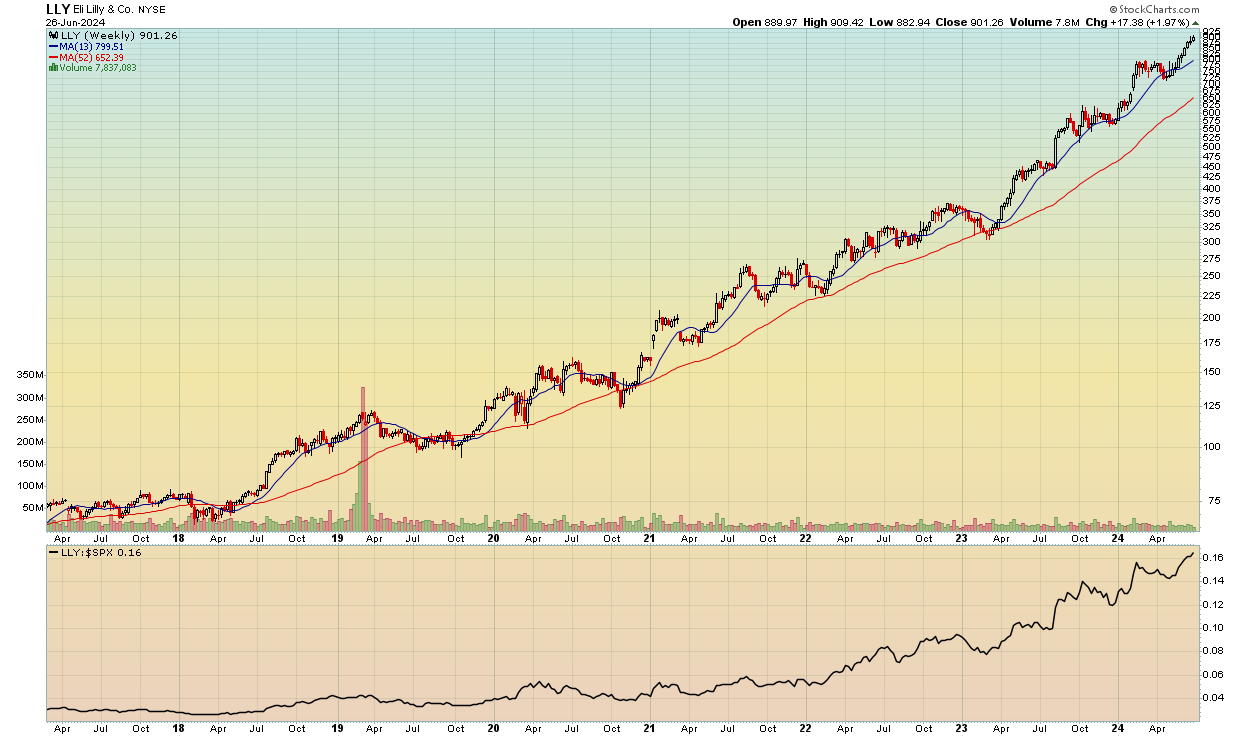

In [64]:
# display PNG files in the directory
png_files = glob.glob(os.path.join(DOWNLOAD_DIR, '*.png'))

# Loop through each PNG file and perform your desired operation
for png_file in png_files:
    display(Image(png_file))


In [ ]:
# TODO:

# review tearsheet.ipynb

# growth metrics
# valuation metrics
# technicals

# compare to market and to peers

# competitors etc., top etfs, review obb stuff
# analyst updates

# get better top news
# get better analyst updates
# review obb for other stuff to include.

# review tearsheet newsapi newsfilter etc.
# scrape tearsheet sites
# twitter

# chart
# profile


# growth metrics
# valuation metrics
# technicals

# compare to market and to peers
